In [1]:
# %matplotlib ipympl

In [2]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import entropy
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as Patch
import seaborn as sns

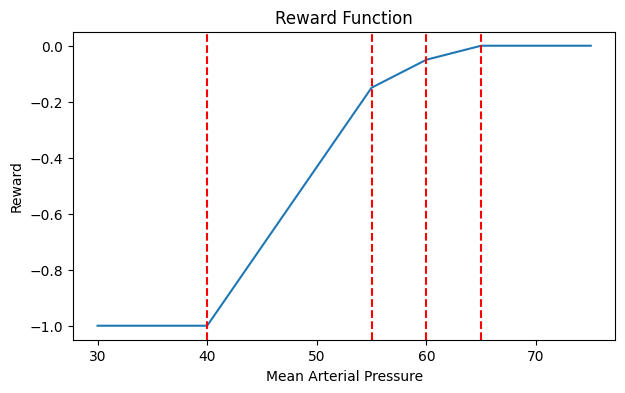

In [127]:
def r_demo(map_value):
    if map_value < 40:
        reward = -1
    elif map_value < 55:
        reward = (-0.15 - -1) / (55 - 40) *  (map_value - 40) + -1
    elif map_value < 60:
        reward = (-0.05 - -0.15) / (60 - 55) *  (map_value - 55) + -0.15
    elif map_value < 65:
        reward = (0 - -0.05) / (65 - 60) *  (map_value - 60) + -0.05
    else:
        reward = 0
    return reward

x = np.linspace(30, 75, 100)
y = [r_demo(i) for i in x]

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(x, y)
ax.axvline(x=40, color='r', linestyle='--', label='40')
ax.axvline(x=55, color='r', linestyle='--', label='55')
ax.axvline(x=60, color='r', linestyle='--', label='60')
ax.axvline(x=65, color='r', linestyle='--', label='65')
ax.set_xlabel('Mean Arterial Pressure')
ax.set_ylabel('Reward')
ax.set_title('Reward Function')
plt.savefig('figures/Reward_Function.png', dpi=300)
plt.show()

In [4]:
def set_seed(seed):
    np.random.seed(seed)

In [5]:
def train_test_split_patient(S, A, S_next, R, Traj, test_size=0.5, seed=42):
    n_patient = len(Traj) - 1
    train_idx, test_idx = train_test_split(range(n_patient), test_size=test_size, random_state=seed)
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)

    print(train_idx.shape, test_idx.shape)

    S_train = []
    A_train = []
    S_next_train = []
    R_train = []
    Traj_train = [0]
    count_train = 0

    S_test = []
    A_test = []
    S_next_test = []
    R_test = []
    Traj_test = [0]
    count_test = 0
    
    for i in train_idx:
        S_train.append(S[Traj[i]:Traj[i+1]])
        A_train.append(A[Traj[i]:Traj[i+1]])
        S_next_train.append(S_next[Traj[i]:Traj[i+1]])
        R_train.append(R[Traj[i]:Traj[i+1]])
        count_train += Traj[i+1] - Traj[i]
        Traj_train.append(count_train)
    
    for i in test_idx:
        S_test.append(S[Traj[i]:Traj[i+1]])
        A_test.append(A[Traj[i]:Traj[i+1]])
        S_next_test.append(S_next[Traj[i]:Traj[i+1]])
        R_test.append(R[Traj[i]:Traj[i+1]])
        count_test += Traj[i+1] - Traj[i]
        Traj_test.append(count_test)

    S_train = np.concatenate(S_train)
    A_train = np.concatenate(A_train)
    S_next_train = np.concatenate(S_next_train)
    R_train = np.concatenate(R_train)
    Traj_train = np.array(Traj_train)
    
    S_test = np.concatenate(S_test)
    A_test = np.concatenate(A_test)
    S_next_test = np.concatenate(S_next_test)
    R_test = np.concatenate(R_test)
    Traj_test = np.array(Traj_test)

    print(S_train.shape, A_train.shape, S_next_train.shape, R_train.shape, Traj_train.shape)

    return S_train, A_train, S_next_train, R_train, Traj_train, S_test, A_test, S_next_test, R_test, Traj_test

# Preprocessing

In [6]:
seed = 42
set_seed(seed)

In [7]:
S = pd.read_csv('data/S.csv', index_col=0)
A = pd.read_csv('data/A.csv', index_col=0)
S_next = pd.read_csv('data/S_next.csv', index_col=0)
R = pd.read_csv('data/R.csv', index_col=0)
Traj = pd.read_csv('data/Traj.csv', index_col=0)

# Clipping
for column in S.columns:
    q1 = S[column].quantile(0.01)
    q99 = S[column].quantile(0.99)
    S[column] = S[column].clip(q1, q99)
    S_next[column] = S_next[column].clip(q1, q99)

S = S.to_numpy()
A = A.to_numpy().flatten()
S_next = S_next.to_numpy()
R = R.to_numpy().flatten()
Traj = Traj.to_numpy().flatten()

# train test split
S_train, A_train, S_next_train, R_train, Traj_train, S_test, A_test, S_next_test, R_test, Traj_test = train_test_split_patient(S, A, S_next, R, Traj, test_size=0.5, seed=seed)

(1000,) (1000,)
(26508, 10) (26508,) (26508, 10) (26508,) (1001,)


In [8]:
state_name = ['Mean BP', 'Diastolic BP', 'Systolic BP',
              'FiO2', 'PO2', 'ALT', 'AST', 'Creatinine', 'Lactate', 'GCS']

In [9]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [32, 64, 128],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'max_features': [2, 3]
}

def grid_search(S, A):
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(S, A)

    print('Best Param:', grid_search.best_params_)
    print('Best Score:', grid_search.best_score_)

    return grid_search

In [10]:
def grid_search_plot(cv_results):
    plt.figure(figsize=(15, 8))

    # Get Test Scores Mean for each grid search result
    scores_mean = cv_results['mean_test_score']

    # Iterate over unique combinations of other parameters (criterion, max_depth, etc.)
    for criterion in param_grid['criterion']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    # Filter results based on these parameters
                    mask = (
                        (cv_results['param_criterion'] == criterion) &
                        (cv_results['param_max_depth'] == max_depth) &
                        (cv_results['param_min_samples_split'] == min_samples_split) &
                        (cv_results['param_max_features'] == max_features)
                    )
                    
                    # Get the corresponding mean test scores for the current parameter set
                    filtered_scores_mean = scores_mean[mask]
                    
                    # Plot the results
                    plt.plot(param_grid['n_estimators'], filtered_scores_mean, '-o', 
                             label=f'{criterion}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}')

    plt.title("Grid Search Scores")
    plt.xlabel('N Estimators')
    plt.ylabel('CV Average Score')
    plt.legend(loc="best")
    plt.grid('on')
    plt.savefig('figures/Random_Forest_Grid_Search_Scores.png', dpi=300)
    plt.show()

In [11]:
def grid_plot_heatmap(S, A, S_next):
    param_combinations = list(itertools.product(
        param_grid['criterion'], 
        param_grid['n_estimators'], 
        param_grid['max_depth'], 
        param_grid['min_samples_split'], 
        param_grid['max_features'],
        [32, 64]
    ))

    decision_points = {}

    for params in tqdm(param_combinations):
        param_dict = {
            'criterion': params[0], 
            'n_estimators': params[1],
            'max_depth': params[2],
            'min_samples_split': params[3],
            'max_features': params[4],
        }
        n = params[5]
        var, clf = variance_capture(S, A, param_dict, verbose=False)
        train_high_var_idx, train_safe_idx, r = decision_point(S, var, threshold=0.75, N_min=n, verbose=False)
        decision_points[params] = train_safe_idx

    stability_results = np.eye(len(param_combinations))

    for i in range(len(param_combinations)):
        for j in range(i+1, len(param_combinations)):
            param_set_1 = param_combinations[i]
            param_set_2 = param_combinations[j]
            
            dp_1 = decision_points[param_set_1]
            dp_2 = decision_points[param_set_2]

            jaccard_sim = len(np.intersect1d(dp_1, dp_2)) / len(np.union1d(dp_1, dp_2))

            stability_results[i, j] = jaccard_sim
            stability_results[j, i] = jaccard_sim

    plt.figure(figsize=(15, 10))
    sns.heatmap(stability_results, annot=False, cmap="viridis", square=True, vmin=0,
                xticklabels=range(len(param_combinations)), 
                yticklabels=range(len(param_combinations)))
    
    stability_results_df = pd.DataFrame(stability_results, index=param_combinations, columns=param_combinations)
    stability_results_df.to_csv('data/Random_Forest_Grid_Search_Heatmap.csv')
    
    plt.title('Jaccard Similarity Heatmap between Parameter Combinations')
    plt.xlabel('Parameter Combination Index')
    plt.ylabel('Parameter Combination Index')
    plt.show()

In [12]:
def variance_capture(S, A, best_params, verbose=True):
    # Random Forest Classifier
    clf = RandomForestClassifier(random_state=42, **best_params)
    clf.fit(S, A)

    # Accuracy of clf
    if verbose:
        print('16 actions')
        print(clf.score(S, A))

    # get entorpy
    predicted_action = clf.predict_proba(S)
    action_entropy = np.array([entropy(p) for p in predicted_action])

    if verbose:
        var_plot(action_entropy)

    return action_entropy, clf

def var_plot(action_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    sns.histplot(action_entropy, ax=ax, bins=100)
    ax.set_title('Action Entropy')
    ax.set_xlim(0, -np.log(1/16))
    plt.savefig('figures/Random_Forest_Action_Entropy.png', dpi=300)
    plt.show()

In [82]:
def feature_importance_plot(clf, S):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.bar(range(S.shape[1]), importances[indices])
    ax.set_xticks(range(S.shape[1]))
    ax.set_xticklabels(np.array(state_name)[indices])
    ax.set_title('Feature Importance')
    plt.savefig('figures/Random_Forest_Feature_Importance.png', dpi=300)
    plt.show()

In [14]:
def contour_plot(clf, S, scaler):
    num_features = S.shape[1]
    feature_pairs = [(i, j) for i in range(num_features) for j in range(i + 1, num_features)]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(25, 20))

    for i, j in feature_pairs:
        x = np.linspace(S[:, i].min(), S[:, i].max(), 100)
        y = np.linspace(S[:, j].min(), S[:, j].max(), 100)
        xx, yy = np.meshgrid(x, y)

        grid = np.zeros((xx.ravel().shape[0], num_features))
        grid[:, i] = xx.ravel()
        grid[:, j] = yy.ravel()

        probs = clf.predict_proba(grid)
        entropies = np.array([entropy(p) for p in probs])
        zz = entropies.reshape(xx.shape)

        S_unscaled = scaler.inverse_transform(grid)
        xx_unscaled = S_unscaled[:, i].reshape(xx.shape)
        yy_unscaled = S_unscaled[:, j].reshape(yy.shape)

        ax = axes[i, j]
        contour = ax.contourf(xx_unscaled, yy_unscaled, zz, levels=20, cmap='viridis')
        ax.set_xlabel(state_name[i])
        ax.set_ylabel(state_name[j])
        fig.colorbar(contour, ax=ax, shrink=0.8)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('Action Entropy Contour Plot')
    plt.savefig('figures/Random_Forest_Action_Entropy_Contour.png', dpi=300)
    plt.show()

In [15]:
def decision_point(S, var, threshold=0.75, N_min=50, verbose=True):
    # get the threshold for the variance
    threshold = np.quantile(var, threshold)

    high_var_idx = np.where(var >= threshold)[0]

    r_best = 0
    high_var_dist = np.array([np.linalg.norm(S - s, axis=1) for s in S])
    for i in np.linspace(0, 2.5, 251):
        high_var_safe_idx = np.intersect1d(high_var_idx, np.where(np.sum(high_var_dist <= i, axis=1) - 1 >= N_min)[0])
        if high_var_safe_idx.shape[0] / high_var_idx.shape[0] <= 0.5:
            r_best = i
        else:
            break

    high_var_safe_idx = np.intersect1d(high_var_idx, np.where(np.sum(high_var_dist <= r_best, axis=1) - 1 >= N_min)[0])

    if verbose:
        print(r_best)

        print(high_var_safe_idx.shape[0] / high_var_idx.shape[0])
        print(high_var_safe_idx.shape[0] / S.shape[0])

        dp_plot(S, high_var_dist, high_var_idx, high_var_safe_idx, N_min, r_best)

    return high_var_idx, high_var_safe_idx, r_best

def dp_plot(S, high_var_dist, high_var_idx, high_var_safe_idx, N_min, r):
    # r, N selection
    N_list = []
    N_LQ = []
    N_Mid = []
    N_UQ = []
    N_least = []
    for i in np.linspace(0, 20, 100):
        N = np.sum(high_var_dist <= i, axis=1) - 1
        N_list.append(np.mean(N))
        N_LQ.append(np.quantile(N, 0.25))
        N_Mid.append(np.quantile(N, 0.5))
        N_UQ.append(np.quantile(N, 0.75))
        N_least.append(np.min(N))

    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(np.linspace(0, 20, 100), N_Mid, linestyle='--', label='Median')
    ax1.fill_between(np.linspace(0, 20, 100), N_LQ, N_UQ, alpha=0.5)
    ax1.plot(np.linspace(0, 20, 100), N_list, label='Mean')
    ax1.axhline(N_min, color='r', linestyle='--')
    ax1.axvline(r, color='r', linestyle='--')
    ax1.set_xlim([0, 2])
    ax1.set_ylim([0, 2000])
    ax1.set_xlabel('r')
    ax1.set_ylabel('N(s)')
    plt.legend()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.linspace(0, 20, 100), N_least)
    ax2.set_xlim([0, 20])
    ax2.set_xlabel('r')
    ax2.set_ylabel('least N')
    plt.suptitle('r N Plot')
    plt.show()

    # plot the decision point
    high_var_state = S[high_var_idx]
    low_var_state = np.delete(S, high_var_idx, axis=0)

    pca = PCA(n_components=3)
    pca.fit(S)
    high_var_pca = pca.transform(high_var_state)
    low_var_pca = pca.transform(low_var_state)

    x_min = min(low_var_pca[:, 0].min(), high_var_pca[:, 0].min())
    x_max = max(low_var_pca[:, 0].max(), high_var_pca[:, 0].max())
    y_min = min(low_var_pca[:, 1].min(), high_var_pca[:, 1].min())
    y_max = max(low_var_pca[:, 1].max(), high_var_pca[:, 1].max())
    z_min = min(low_var_pca[:, 2].min(), high_var_pca[:, 2].min())
    z_max = max(low_var_pca[:, 2].max(), high_var_pca[:, 2].max())

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter3D(low_var_pca[:, 0], low_var_pca[:, 1], low_var_pca[:, 2], color='b', label='Low Entropy State')
    ax1.scatter3D(high_var_pca[:, 0], high_var_pca[:, 1], high_var_pca[:, 2], color='r', label='High Entropy State')
    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([y_min, y_max])
    ax1.set_zlim([z_min, z_max])
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')
    plt.legend()
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter3D(high_var_pca[:, 0], high_var_pca[:, 1], high_var_pca[:, 2], color='r', label='High Entropy State')
    ax2.set_xlim([x_min, x_max])
    ax2.set_ylim([y_min, y_max])
    ax2.set_zlim([z_min, z_max])
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    plt.suptitle('Data Points with High Action Entropy')
    plt.legend()
    plt.savefig('figures/Random_Forest_Potential_Decision_Point.png', dpi=300)
    plt.show()

    # plot the decision point
    high_var_safe_state = S[high_var_safe_idx]
    low_var_safe_state = np.delete(S, high_var_safe_idx, axis=0)

    pca = PCA(n_components=3)
    pca.fit(S)
    high_var_pca = pca.transform(high_var_safe_state)
    low_var_pca = pca.transform(low_var_safe_state)

    x_min = min(low_var_pca[:, 0].min(), high_var_pca[:, 0].min())
    x_max = max(low_var_pca[:, 0].max(), high_var_pca[:, 0].max())
    y_min = min(low_var_pca[:, 1].min(), high_var_pca[:, 1].min())
    y_max = max(low_var_pca[:, 1].max(), high_var_pca[:, 1].max())
    z_min = min(low_var_pca[:, 2].min(), high_var_pca[:, 2].min())
    z_max = max(low_var_pca[:, 2].max(), high_var_pca[:, 2].max())

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter3D(low_var_pca[:, 0], low_var_pca[:, 1], low_var_pca[:, 2], color='b', label='Non Decision Points')
    ax1.scatter3D(high_var_pca[:, 0], high_var_pca[:, 1], high_var_pca[:, 2], color='r', label='Decision Points')
    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([y_min, y_max])
    ax1.set_zlim([z_min, z_max])
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')
    plt.legend()
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter3D(high_var_pca[:, 0], high_var_pca[:, 1], high_var_pca[:, 2], color='r', label='Decision Points')
    ax2.set_xlim([x_min, x_max])
    ax2.set_ylim([y_min, y_max])
    ax2.set_zlim([z_min, z_max])
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    plt.suptitle('Data Points with High Action Entropy and Enough Neighbors')
    plt.legend()
    plt.savefig('figures/Random_Forest_Decision_Point.png', dpi=300)
    plt.show()

In [161]:
def evaluate_learned(cluster_idx, n_clusters, clf, policy_learned, S, A, R, Traj, gamma=0.9):
    V_pi_b_list = []
    V_IS_list = []
    V_PDIS_list = []
    V_WIS_list = []
    V_PDWIS_list = []

    improved_list = []

    miss = 0

    for i in tqdm(range(100)):
        return_pi_b = 0
        return_IS = 0
        return_PD = 0
        weight_total_IS = []
        weight_total_PD = []

        bootstrap_samples = np.random.choice(range(len(Traj)-1), len(Traj)-1, replace=True)

        for b in bootstrap_samples:
            S_Traj = S[Traj[b]:Traj[b+1]]
            A_Traj = A[Traj[b]:Traj[b+1]]
            R_Traj = R[Traj[b]:Traj[b+1]]

            return_traj = 0
            weight_PD = 1

            for t, (s, a, r) in enumerate(zip(S_Traj, A_Traj, R_Traj)):
                idx = Traj[b] + t

                pi_b_prob = clf.predict_proba(s.reshape(1, -1))[0]
                pi_b = pi_b_prob[a]

                if cluster_idx[idx] == n_clusters or cluster_idx[idx] == n_clusters + 1:
                    pi_e = clf.predict_proba(s.reshape(1, -1))[0][a]
                    is_dp = 0
                else:
                    pi_e = policy_learned[int(cluster_idx[idx])][a]
                    is_dp = 1
                improved_list.append(is_dp)

                if pi_b == 0:
                    miss += 1
                    break

                # PDIS, PDWIS
                weight_PD *= pi_e / pi_b

                return_traj += gamma**t * r
                return_PD += gamma**t * r * weight_PD

                weight_total_PD.append(gamma**t * weight_PD)

            # pi_b, IS, WIS
            return_pi_b += return_traj
            return_IS += return_traj * weight_PD

            weight_total_IS.append(weight_PD)

        N = len(bootstrap_samples)
        V_pi_b_list.append(return_pi_b / N)
        V_IS_list.append(return_IS / N)
        V_PDIS_list.append(return_PD / N)
        V_WIS_list.append(return_IS / np.sum(weight_total_IS))
        V_PDWIS_list.append(return_PD / np.sum(weight_total_PD))

    print()
    print('Behaviour Policy:')
    print()
    print('V_pi_b:', np.mean(V_pi_b_list), '+/-', np.std(V_pi_b_list))
    print(np.quantile(V_pi_b_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('Proposed Policy:')
    print()
    print('V_IS:', np.mean(V_IS_list), '+/-', np.std(V_IS_list))
    print(np.quantile(V_IS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_PDIS:', np.mean(V_PDIS_list), '+/-', np.std(V_PDIS_list))
    print(np.quantile(V_PDIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_WIS:', np.mean(V_WIS_list), '+/-', np.std(V_WIS_list))
    print(np.quantile(V_WIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_PDWIS:', np.mean(V_PDWIS_list), '+/-', np.std(V_PDWIS_list))
    print(np.quantile(V_PDWIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('Percentage of Decision Points:', np.mean(improved_list), '(', np.sum(improved_list), '/', len(improved_list), ')')
    print()
    print('Miss:', miss)

In [162]:
def test_learned(knn, n_clusters, clf, policy_learned, S, A, R, Traj, gamma=0.9):
    V_pi_b_list = []
    V_IS_list = []
    V_PDIS_list = []
    V_WIS_list = []
    V_PDWIS_list = []

    dp_list = []

    miss = 0

    for i in tqdm(range(100)):
        return_pi_b = 0
        return_IS = 0
        return_PD = 0
        weight_total_IS = []
        weight_total_PD = []

        bootstrap_samples = np.random.choice(range(len(Traj)-1), len(Traj)-1, replace=True)

        for b in bootstrap_samples:
            S_Traj = S[Traj[b]:Traj[b+1]]
            A_Traj = A[Traj[b]:Traj[b+1]]
            R_Traj = R[Traj[b]:Traj[b+1]]

            return_traj = 0
            weight_PD = 1

            for t, (s, a, r) in enumerate(zip(S_Traj, A_Traj, R_Traj)):
                cluster_idx = knn.predict(s.reshape(1, -1))[0]

                pi_b_prob = clf.predict_proba(s.reshape(1, -1))[0]
                pi_b = pi_b_prob[a]

                if cluster_idx == n_clusters or cluster_idx == n_clusters + 1:
                    pi_e = clf.predict_proba(s.reshape(1, -1))[0][a]
                    is_dp = 0
                else:
                    pi_e = policy_learned[int(cluster_idx)][a]
                    is_dp = 1
                dp_list.append(is_dp)

                if pi_b == 0:
                    miss += 1
                    break

                # PDIS, PDWIS
                weight_PD *= pi_e / pi_b

                return_traj += gamma**t * r
                return_PD += gamma**t * r * weight_PD

                weight_total_PD.append(gamma**t * weight_PD)

            # pi_b, IS, WIS
            return_pi_b += return_traj
            return_IS += return_traj * weight_PD

            weight_total_IS.append(weight_PD)

        N = len(bootstrap_samples)
        V_pi_b_list.append(return_pi_b / N)
        V_IS_list.append(return_IS / N)
        V_PDIS_list.append(return_PD / N)
        V_WIS_list.append(return_IS / np.sum(weight_total_IS))
        V_PDWIS_list.append(return_PD / np.sum(weight_total_PD))

    print()
    print('Behaviour Policy:')
    print()
    print('V_pi_b:', np.mean(V_pi_b_list), '+/-', np.std(V_pi_b_list))
    print(np.quantile(V_pi_b_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('Proposed Policy:')
    print()
    print('V_IS:', np.mean(V_IS_list), '+/-', np.std(V_IS_list))
    print(np.quantile(V_IS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_PDIS:', np.mean(V_PDIS_list), '+/-', np.std(V_PDIS_list))
    print(np.quantile(V_PDIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_WIS:', np.mean(V_WIS_list), '+/-', np.std(V_WIS_list))
    print(np.quantile(V_WIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('V_PDWIS:', np.mean(V_PDWIS_list), '+/-', np.std(V_PDWIS_list))
    print(np.quantile(V_PDWIS_list, [0, 0.25, 0.5, 0.75, 1]))
    print()
    print('Percentage of Decision Points:', np.mean(dp_list), '(', np.sum(dp_list), '/', len(dp_list), ')')
    print()
    print('Miss:', miss)

In [97]:
def check_dp_state(cluster_idx, n_clusters, S, A, R, Traj, scaler):
    dp_state = []
    all_state = []

    for i in range(len(Traj)-1):
        S_Traj = S[Traj[i]:Traj[i+1]]
        A_Traj = A[Traj[i]:Traj[i+1]]
        R_Traj = R[Traj[i]:Traj[i+1]]
        
        T = len(S_Traj)+1

        for t, (s, a, r) in enumerate(zip(S_Traj, A_Traj, R_Traj)):
            idx = Traj[i] + t

            if cluster_idx[idx] == n_clusters or cluster_idx[idx] == n_clusters + 1:
                is_dp = 0
            else:
                is_dp = 1
            s = s.tolist()
            s.extend([t, t/T])
            if is_dp:
                dp_state.append(s)
            all_state.append(s)

    dp_state = np.array(dp_state)
    all_state = np.array(all_state)

    print(dp_state.shape, all_state.shape)

    print('Percentage of Decision Points:', dp_state.shape[0]/all_state.shape[0], '(', dp_state.shape[0], '/', all_state.shape[0], ')')

    # Reverse scaler transform
    dp_state[:, :10] = scaler.inverse_transform(dp_state[:, :10])
    all_state[:, :10] = scaler.inverse_transform(all_state[:, :10])

    # Plot for each column
    fig, axes = plt.subplots(5, 2, figsize=(10, 10))
    for i in range(10):
        min_val = min(dp_state[:, i].min(), all_state[:, i].min())
        max_val = max(dp_state[:, i].max(), all_state[:, i].max())
        if i == 3:
            max_val = 120
        elif i == 4:
            max_val = 410
        elif i == 5:
            max_val = 200
        elif i == 6:
            max_val = 300
        elif i == 7:
            max_val = 7
        elif i == 8:
            max_val = 6
        bins = np.linspace(min_val, max_val, int(max_val - min_val + 2))
        if i != 0 and i != 1 and i != 2:
            bins = np.linspace(min_val, max_val, 50)
        
        # Plot histograms
        sns.histplot(dp_state[:, i], ax=axes[i//2, i%2], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, i], ax=axes[i//2, i%2], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        
        # Calculate and plot percentages
        counts_DP, _ = np.histogram(dp_state[:, i], bins=bins)
        counts_all, _ = np.histogram(all_state[:, i], bins=bins)
        # Avoid division by zero by replacing zeros with a small number
        counts_all[counts_all == 0] = 1
        percentages = (counts_DP / counts_all) * 100
        ln, = axes[i//2, i%2].twinx().plot(bins[:-1], percentages, color='g', linestyle='--', label='DP / All')
        
        # Collect and combine legends from both axes
        lns = axes[i//2, i%2].get_legend_handles_labels()[0] + [ln]
        labs = axes[i//2, i%2].get_legend_handles_labels()[1] + [ln.get_label()]
        axes[i//2, i%2].legend(lns, labs, loc='upper right')
        axes[i//2, i%2].set_title(state_name[i])
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('DP vs All State for Features')
    plt.savefig('figures/Evaluation_DP_States.png', dpi=300)
    plt.show()

    # Plot for columns 11, 12
    t_name = ['t', 't/T']
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for i in range(2):
        min_val = min(dp_state[:, 10+i].min(), all_state[:, 10+i].min())
        max_val = max(dp_state[:, 10+i].max(), all_state[:, 10+i].max())
        bins_num = int(max(dp_state[:, 10].max(), all_state[:, 10].max()) - min(dp_state[:, 10].min(), all_state[:, 10].min()) + 2)
        bins = np.linspace(min_val, max_val, bins_num)
        
        # Plot histograms
        sns.histplot(dp_state[:, 10+i], ax=axes[i], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, 10+i], ax=axes[i], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        
        # Calculate and plot percentages
        counts_DP, _ = np.histogram(dp_state[:, 10+i], bins=bins)
        counts_all, _ = np.histogram(all_state[:, 10+i], bins=bins)
        # Avoid division by zero by replacing zeros with a small number
        counts_all[counts_all == 0] = 1
        percentages = (counts_DP / counts_all) * 100
        ln, = axes[i].twinx().plot(bins[:-1], percentages, color='g', linestyle='--', label='DP / All')
        
        # Collect and combine legends from both axes
        lns = axes[i].get_legend_handles_labels()[0] + [ln]
        labs = axes[i].get_legend_handles_labels()[1] + [ln.get_label()]
        axes[i].legend(lns, labs, loc='upper right')
        axes[i].set_title(t_name[i])
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.suptitle('DP vs All State for Time')
    plt.savefig('figures/Evaluation_DP_Time.png', dpi=300)
    plt.show()

    # Side-by-side plots for first 10 columns
    fig, axes = plt.subplots(10, 2, figsize=(10, 20))
    for i in range(10):
        min_val = min(dp_state[:, i].min(), all_state[:, i].min())
        max_val = max(dp_state[:, i].max(), all_state[:, i].max())
        if i == 3:
            max_val = 120
        elif i == 4:
            max_val = 410
        elif i == 5:
            max_val = 200
        elif i == 6:
            max_val = 300
        elif i == 7:
            max_val = 7
        elif i == 8:
            max_val = 6
        bins = np.linspace(min_val, max_val, int(max_val - min_val + 2))
        if i != 0 and i != 1 and i != 2:
            bins = np.linspace(min_val, max_val, 50)
        
        # Plot histograms side by side
        sns.histplot(dp_state[:, i], ax=axes[i, 0], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, i], ax=axes[i, 1], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        axes[i, 0].set_title('DP State for '+state_name[i])
        axes[i, 1].set_title('All State for '+state_name[i])
        axes[i, 0].legend()
        axes[i, 1].legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('Side-by-Side Comparison for Features')
    plt.show()

    # Side-by-side plots for columns 11, 12
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    t_name = ['t', 't/T']
    for i in range(2):
        min_val = min(dp_state[:, 10+i].min(), all_state[:, 10+i].min())
        max_val = max(dp_state[:, 10+i].max(), all_state[:, 10+i].max())
        bins_num = int(max(dp_state[:, 10].max(), all_state[:, 10].max()) - min(dp_state[:, 10].min(), all_state[:, 10].min()) + 2)
        bins = np.linspace(min_val, max_val, bins_num)
        
        # Plot histograms side by side
        sns.histplot(dp_state[:, 10+i], ax=axes[i, 0], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, 10+i], ax=axes[i, 1], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        axes[i, 0].set_title(f'DP State for {t_name[i]}')
        axes[i, 1].set_title(f'All State for {t_name[i]}')
        axes[i, 0].legend()
        axes[i, 1].legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('Side-by-Side Comparison for Time')
    plt.show()

In [98]:
def check_test_state(knn, n_clusters, S, A, R, Traj, scaler):
    dp_state = []
    all_state = []

    for i in range(len(Traj)-1):
        S_Traj = S[Traj[i]:Traj[i+1]]
        A_Traj = A[Traj[i]:Traj[i+1]]
        R_Traj = R[Traj[i]:Traj[i+1]]
        
        T = len(S_Traj)+1

        for t, (s, a, r) in enumerate(zip(S_Traj, A_Traj, R_Traj)):
            cluster_idx = knn.predict(s.reshape(1, -1))[0]
            
            if cluster_idx == n_clusters or cluster_idx == n_clusters + 1:
                is_dp = 0
            else:
                is_dp = 1

            s = s.tolist()
            s.extend([t, t/T])
            if is_dp:
                dp_state.append(s)
            all_state.append(s)

    dp_state = np.array(dp_state)
    all_state = np.array(all_state)

    print(dp_state.shape, all_state.shape)

    print('Percentage of Decision Points:', dp_state.shape[0]/all_state.shape[0], '(', dp_state.shape[0], '/', all_state.shape[0], ')')

    # Reverse scaler transform
    dp_state[:, :10] = scaler.inverse_transform(dp_state[:, :10])
    all_state[:, :10] = scaler.inverse_transform(all_state[:, :10])

    # Plot for each column
    fig, axes = plt.subplots(5, 2, figsize=(10, 10))
    for i in range(10):
        min_val = min(dp_state[:, i].min(), all_state[:, i].min())
        max_val = max(dp_state[:, i].max(), all_state[:, i].max())
        if i == 3:
            max_val = 120
        elif i == 4:
            max_val = 410
        elif i == 5:
            max_val = 200
        elif i == 6:
            max_val = 300
        elif i == 7:
            max_val = 7
        elif i == 8:
            max_val = 6
        bins = np.linspace(min_val, max_val, int(max_val - min_val + 1))
        if i != 0 and i != 1 and i != 2:
            bins = np.linspace(min_val, max_val, 50)
        
        # Plot histograms
        sns.histplot(dp_state[:, i], ax=axes[i//2, i%2], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, i], ax=axes[i//2, i%2], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        
        # Calculate and plot percentages
        counts_DP, _ = np.histogram(dp_state[:, i], bins=bins)
        counts_all, _ = np.histogram(all_state[:, i], bins=bins)
        # Avoid division by zero by replacing zeros with a small number
        counts_all[counts_all == 0] = 1
        percentages = counts_DP / counts_all
        ln, = axes[i//2, i%2].twinx().plot(bins[:-1], percentages, color='g', linestyle='--', label='DP / All')
        
        # Collect and combine legends from both axes
        lns = axes[i//2, i%2].get_legend_handles_labels()[0] + [ln]
        labs = axes[i//2, i%2].get_legend_handles_labels()[1] + [ln.get_label()]
        axes[i//2, i%2].legend(lns, labs, loc='upper right')
        axes[i//2, i%2].set_title(state_name[i])
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('DP vs All State for Features')
    plt.savefig('figures/Test_DP_states.png', dpi=300)
    plt.show()

    # Plot for columns 11, 12
    t_name = ['t', 't/T']
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for i in range(2):
        min_val = min(dp_state[:, 10+i].min(), all_state[:, 10+i].min())
        max_val = max(dp_state[:, 10+i].max(), all_state[:, 10+i].max())
        bins_num = int(max(dp_state[:, 10].max(), all_state[:, 10].max()) - min(dp_state[:, 10].min(), all_state[:, 10].min()) + 2)
        bins = np.linspace(min_val, max_val, bins_num)
        
        # Plot histograms
        sns.histplot(dp_state[:, 10+i], ax=axes[i], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, 10+i], ax=axes[i], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        
        # Calculate and plot percentages
        counts_DP, _ = np.histogram(dp_state[:, 10+i], bins=bins)
        counts_all, _ = np.histogram(all_state[:, 10+i], bins=bins)
        # Avoid division by zero by replacing zeros with a small number
        counts_all[counts_all == 0] = 1
        percentages = counts_DP / counts_all
        ln, = axes[i].twinx().plot(bins[:-1], percentages, color='g', linestyle='--', label='DP / All')
        
        # Collect and combine legends from both axes
        lns = axes[i].get_legend_handles_labels()[0] + [ln]
        labs = axes[i].get_legend_handles_labels()[1] + [ln.get_label()]
        axes[i].legend(lns, labs, loc='upper right')
        axes[i].set_title(t_name[i])
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.suptitle('DP vs All State for Time')
    plt.savefig('figures/Test_DP_Time.png', dpi=300)
    plt.show()

    # Side-by-side plots for first 10 columns
    fig, axes = plt.subplots(10, 2, figsize=(10, 20))
    for i in range(10):
        min_val = min(dp_state[:, i].min(), all_state[:, i].min())
        max_val = max(dp_state[:, i].max(), all_state[:, i].max())
        if i == 3:
            max_val = 120
        elif i == 4:
            max_val = 410
        elif i == 5:
            max_val = 200
        elif i == 6:
            max_val = 300
        elif i == 7:
            max_val = 7
        elif i == 8:
            max_val = 6
        bins = np.linspace(min_val, max_val, int(max_val - min_val + 1))
        if i != 0 and i != 1 and i != 2:
            bins = np.linspace(min_val, max_val, 50)
        
        # Plot histograms side by side
        sns.histplot(dp_state[:, i], ax=axes[i, 0], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, i], ax=axes[i, 1], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        axes[i, 0].set_title(f'DP State for Column {i+1}')
        axes[i, 1].set_title(f'All State for Column {i+1}')
        axes[i, 0].legend()
        axes[i, 1].legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('Side-by-Side Comparison for Features')
    plt.show()

    # Side-by-side plots for columns 11, 12
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    t_name = ['t', 't/T']
    for i in range(2):
        min_val = min(dp_state[:, 10+i].min(), all_state[:, 10+i].min())
        max_val = max(dp_state[:, 10+i].max(), all_state[:, 10+i].max())
        bins_num = int(max(dp_state[:, 10].max(), all_state[:, 10].max()) - min(dp_state[:, 10].min(), all_state[:, 10].min()) + 2)
        bins = np.linspace(min_val, max_val, bins_num)

        # Plot histograms side by side
        sns.histplot(dp_state[:, 10+i], ax=axes[i, 0], bins=bins, color='r', alpha=0.5, label='DP', stat='count')
        sns.histplot(all_state[:, 10+i], ax=axes[i, 1], bins=bins, color='b', alpha=0.5, label='All', stat='count')
        axes[i, 0].set_title(f'DP State for {t_name[i]}')
        axes[i, 1].set_title(f'All State for {t_name[i]}')
        axes[i, 0].legend()
        axes[i, 1].legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle('Side-by-Side Comparison for Time')
    plt.show()

In [20]:
N_min = 64
# r = 1
SA_min = 4

# Random Forest

In [21]:
# Preprocessing
scaler = StandardScaler()
S_train_scaled = scaler.fit_transform(S_train)
S_next_train_scaled = scaler.transform(S_next_train)
S_test_scaled = scaler.transform(S_test)

In [23]:
# Find Param for Variance Capture
grid_search_rf = grid_search(S_train_scaled, A_train)

Best Param: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 128}
Best Score: 0.4273804911153536


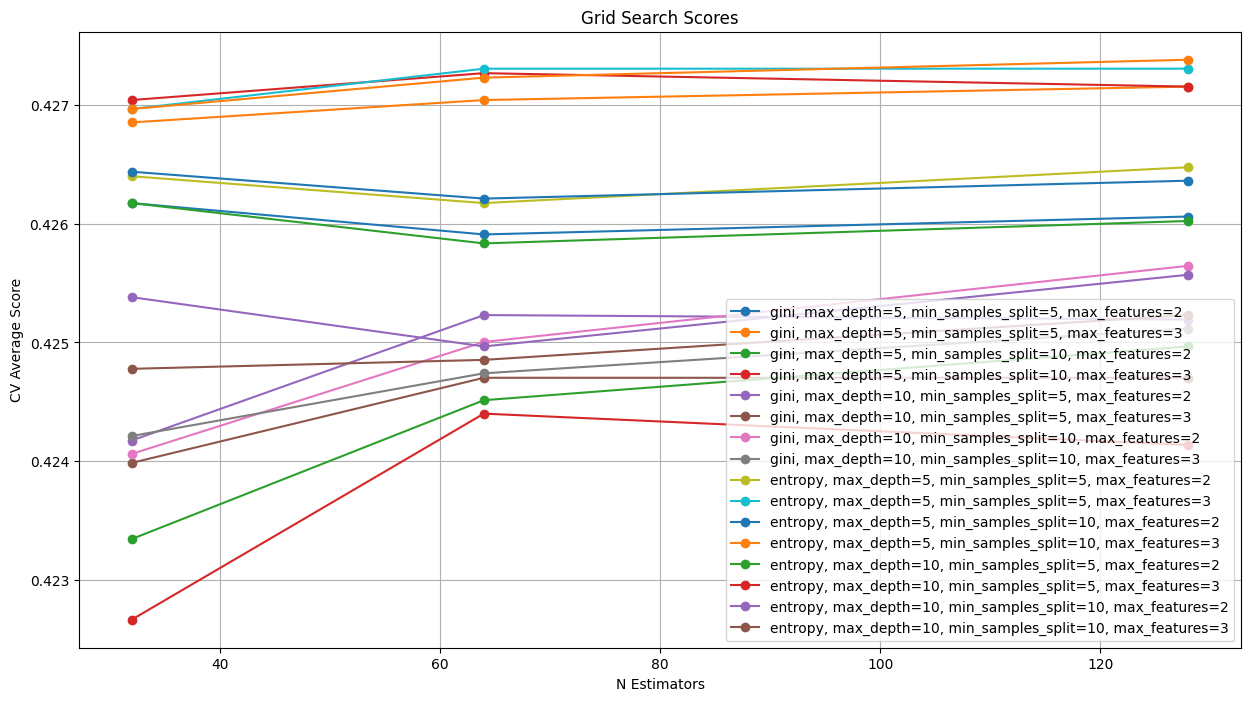

In [24]:
grid_search_plot(grid_search_rf.cv_results_)

100%|██████████| 96/96 [2:10:44<00:00, 81.71s/it]  


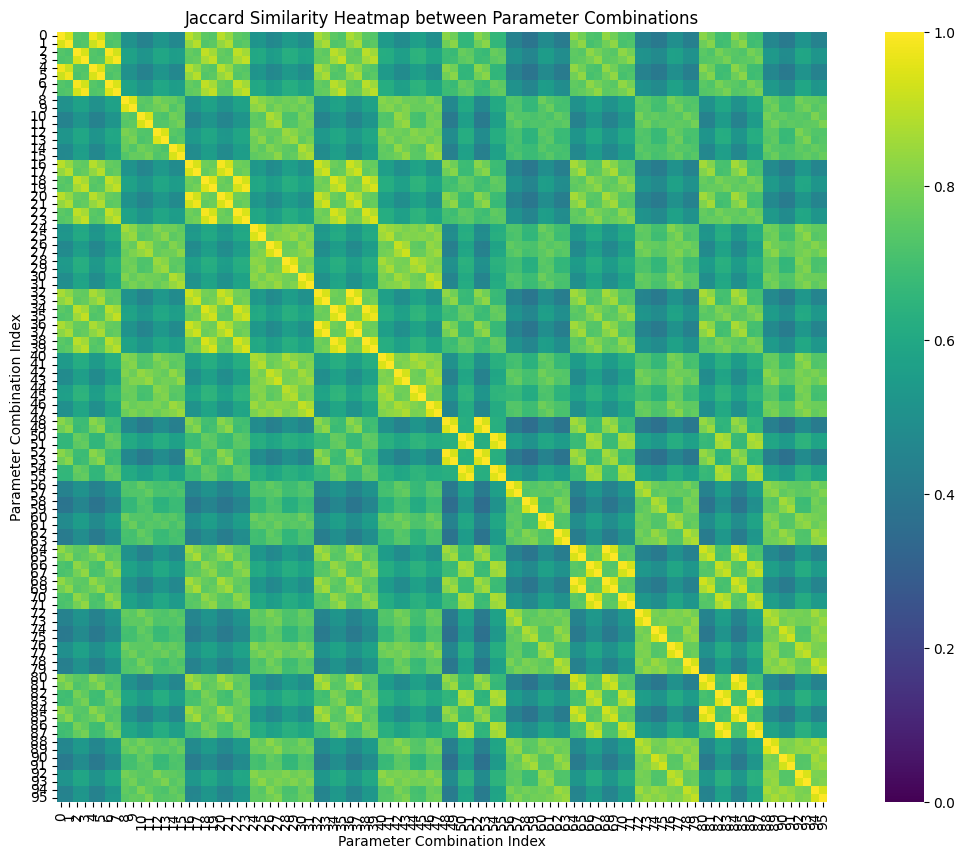

In [25]:
grid_plot_heatmap(S_train_scaled, A_train, S_next_train_scaled)

# Kernel

In [22]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt

In [23]:
class BatchDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [24]:
class GaussianKernel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(GaussianKernel, self).__init__()
        torch.manual_seed(42)
        self.kernel = nn.Parameter(torch.randn(input_dim), requires_grad=True)
        self.omega = torch.randn((input_dim, hidden_dim))
        self.b = torch.rand(hidden_dim) * math.pi * 2
        self.D = hidden_dim
        self.rff = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x * torch.exp(self.kernel)
        x = math.sqrt(2 / self.D) * torch.cos((torch.mm(x, self.omega) + self.b))
        x = self.rff(x)
        return x

    def get_kernel(self):
        with torch.no_grad():
            return torch.exp(self.kernel).numpy()

In [25]:
class SigmoidKernel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SigmoidKernel, self).__init__()
        torch.manual_seed(42)
        self.alpha = nn.Parameter(torch.randn(1), requires_grad=True)
        self.beta = nn.Parameter(torch.randn(1), requires_grad=True)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.alpha * torch.mm(x, x.t()) + self.beta)
        x = self.fc(x)
        return x

    def get_kernel(self):
        with torch.no_grad():
            return self.alpha.numpy(), self.beta.numpy()

In [26]:
def train_kernel(model, X_train, y_train, device, num_epochs=250, lr=4e-2, batch_size=4):
    
    X_train = torch.tensor(X_train, dtype=torch.float, device=device)
    y_train = torch.tensor(y_train, dtype=torch.long, device=device)
    data_loader = DataLoader(BatchDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    # print(len(data_loader))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train kernel
    model.train()
    for epoch in range(num_epochs):
        acc_loss = []
        for data, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            acc_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        if (epoch+1) % 50 == 0:
            print('Epoch {0}/{1}, Learning Kernel Loss: {2}'.format(epoch+1, num_epochs, sum(acc_loss) / len(acc_loss)))

    return model

In [35]:
def kernels(S, A, device):
    model = GaussianKernel(S.shape[1], 16, 512).to(device)
    model = train_kernel(model, S, A, device)
    Gaussian_kernel = model.get_kernel()
    Gaussian_kernel = pd.DataFrame(Gaussian_kernel, columns=['GaussianKernel'])
    Gaussian_kernel.to_csv('data/GaussianKernel.csv', index=False)

def DP_kernels(S, A):
    Similarities = []

    # Learned
    Gaussian_kernel = pd.read_csv('data/GaussianKernel.csv')['GaussianKernel'].values
    S_weighted = S * Gaussian_kernel
    norms = np.sum(S_weighted ** 2, axis=1)
    dist_squared = norms[:, np.newaxis] + norms[np.newaxis, :] - 2 * np.dot(S_weighted, S_weighted.T)
    Gaussian_Similary = np.exp(-dist_squared)
    Similarities.append(Gaussian_Similary)

    # Simple
    Similarity = np.dot(S, S.T)
    Similarity = Similarity / np.max(Similarity)
    Similarities.append(Similarity)

    # Self Defined
    Kernel = np.array([15, 5, 5, 15, 3, 5, 5, 3, 10, 15])
    S_weighted = S * Kernel
    Similarity = np.dot(S_weighted, S_weighted.T)
    Similarity = Similarity / np.max(Similarity)
    Similarities.append(Similarity)

    N = [5, 10, 20]
    dp_list = []

    for idx_n, n in enumerate(N):
        print('N:', n)
        for idx_s, sim in enumerate(Similarities):
            for i in np.linspace(0, 1, 101):
                decision_points = []
                for j in range(S.shape[0]):
                    neighbours = np.where(sim[j] >= i)[0]
                    unique, counts = np.unique(A[neighbours], return_counts=True)
                    if len(counts) < 2:
                        continue
                    sorted_counts = np.sort(counts)[::-1]
                    if sorted_counts[1] >= n:
                        decision_points.append(j)

                if len(decision_points) / S.shape[0] <= 0.125:
                    print(idx_s, i)
                    print(len(decision_points) / S.shape[0])
                    break

            dp_list.append(decision_points)

    return dp_list

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
kernels(S_train_scaled, A_train, device)

Epoch 50/250, Learning Kernel Loss: 1.9544098118779094
Epoch 100/250, Learning Kernel Loss: 1.9367202911213979
Epoch 150/250, Learning Kernel Loss: 1.9095218617604548
Epoch 200/250, Learning Kernel Loss: 1.8928966533009852
Epoch 250/250, Learning Kernel Loss: 1.8809138133467567


In [36]:
dp_list = DP_kernels(S_train_scaled, A_train)

N: 5
0 0.87
0.12169910970273125
1 0.12
0.12441527086162668
2 0.22
0.12139731401840953
N: 10
0 0.8200000000000001
0.11479553342387204
1 0.12
0.10396861324883054
2 0.21
0.11796438810925004
N: 20
0 0.76
0.11490870680549269
1 0.1
0.12275539459785725
2 0.19
0.11879432624113476


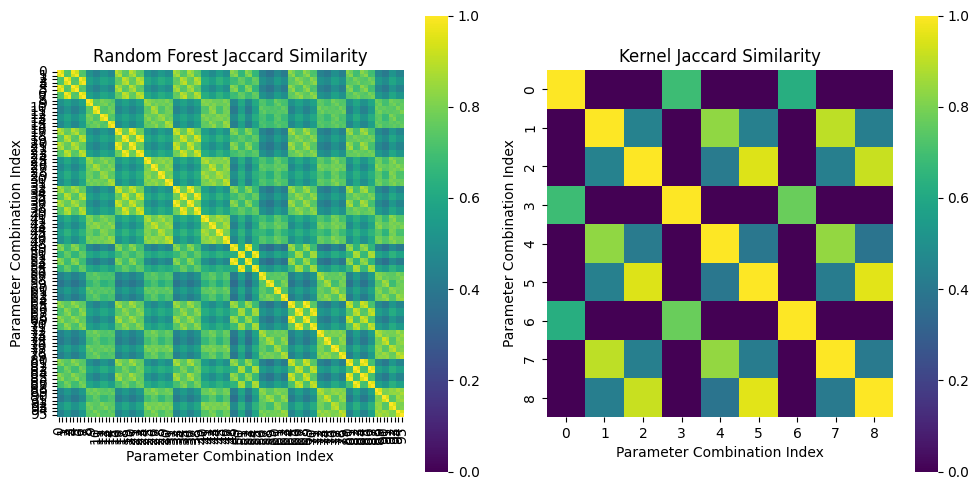

In [61]:
stability_results_random_forest = pd.read_csv('data/Random_Forest_Grid_Search_Heatmap.csv', index_col=0)
stability_results_random_forest = np.array(stability_results_random_forest)

stability_results_kernel = np.eye(len(dp_list))

for i in range(len(dp_list)):
    for j in range(i+1, len(dp_list)):
        dp_1 = dp_list[i]
        dp_2 = dp_list[j]

        jaccard_sim = len(np.intersect1d(dp_1, dp_2)) / len(np.union1d(dp_1, dp_2))

        stability_results_kernel[i, j] = jaccard_sim
        stability_results_kernel[j, i] = jaccard_sim

stability_results_kernel_df = pd.DataFrame(stability_results_kernel, index=range(len(dp_list)), columns=range(len(dp_list)))
stability_results_kernel_df.to_csv('data/Kernel_Grid_Search_Heatmap.csv')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(stability_results_random_forest, annot=False, cmap="viridis", square=True, vmin=0,
            ax=axes[0],
            xticklabels=range(stability_results_random_forest.shape[0]), 
            yticklabels=range(stability_results_random_forest.shape[0]))
axes[0].set_title('Random Forest Jaccard Similarity')
axes[0].set_xlabel('Parameter Combination Index')
axes[0].set_ylabel('Parameter Combination Index')

sns.heatmap(stability_results_kernel, annot=False, cmap="viridis", square=True, vmin=0,
            ax=axes[1],
            xticklabels=range(len(dp_list)), 
            yticklabels=range(len(dp_list)))
axes[1].set_title('Kernel Jaccard Similarity')
axes[1].set_xlabel('Parameter Combination Index')
axes[1].set_ylabel('Parameter Combination Index')

plt.tight_layout()
plt.savefig('figures/Random_Forest_Grid_Search_Heatmap.png', dpi=300)
plt.show()

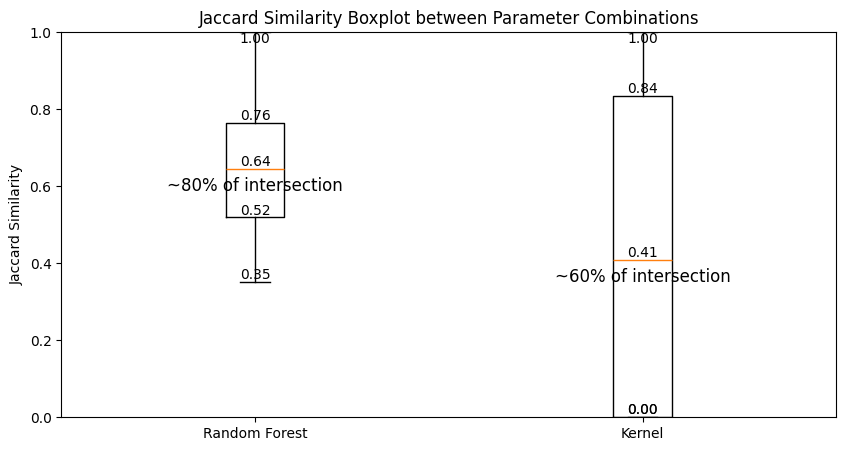

In [72]:
data_grid = pd.read_csv('data/Random_Forest_Grid_Search_Heatmap.csv', index_col=0)
data_grid = data_grid.to_numpy().flatten()

data_kernel = pd.read_csv('data/Kernel_Grid_Search_Heatmap.csv', index_col=0)
data_kernel = data_kernel.to_numpy().flatten()

plt.figure(figsize=(10, 5))
plt.boxplot([data_grid, data_kernel], labels=['Random Forest', 'Kernel'])

for i, data in enumerate([data_grid, data_kernel]):
    q0 = np.quantile(data, 0)
    q1 = np.quantile(data, 0.25)
    q2 = np.quantile(data, 0.5)
    q3 = np.quantile(data, 0.75)
    q4 = np.quantile(data, 1)
    for j, q in enumerate([q0, q1, q2, q3]):
        plt.text(i+1, q, f'{q:.2f}', ha='center', va='bottom', color='black')
    plt.text(i+1, q4, f'{q4:.2f}', ha='center', va='top', color='black')
    plt.text(i+1, q2-0.02, '~{}% of intersection'.format([80, 60][i]), fontsize=12, ha='center', va='top', color='black')

plt.ylim(0, 1)
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity Boxplot between Parameter Combinations')
plt.savefig('figures/Random_Forest_Grid_Search_Boxplot.png', dpi=300)
plt.show()

# Decision Points

In [77]:
best_params = {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 128}

16 actions
0.4293798098687189


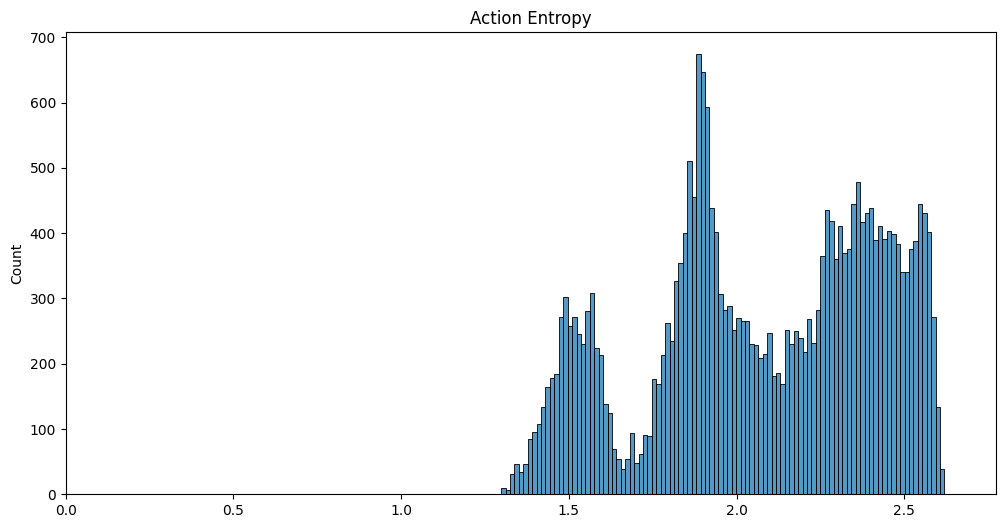

In [78]:
# Captrue Variance
var, clf = variance_capture(S_train_scaled, A_train, best_params)

In [41]:
print('16 actions')
print(clf.score(S_test_scaled, A_test))

16 actions
0.42889704462043654


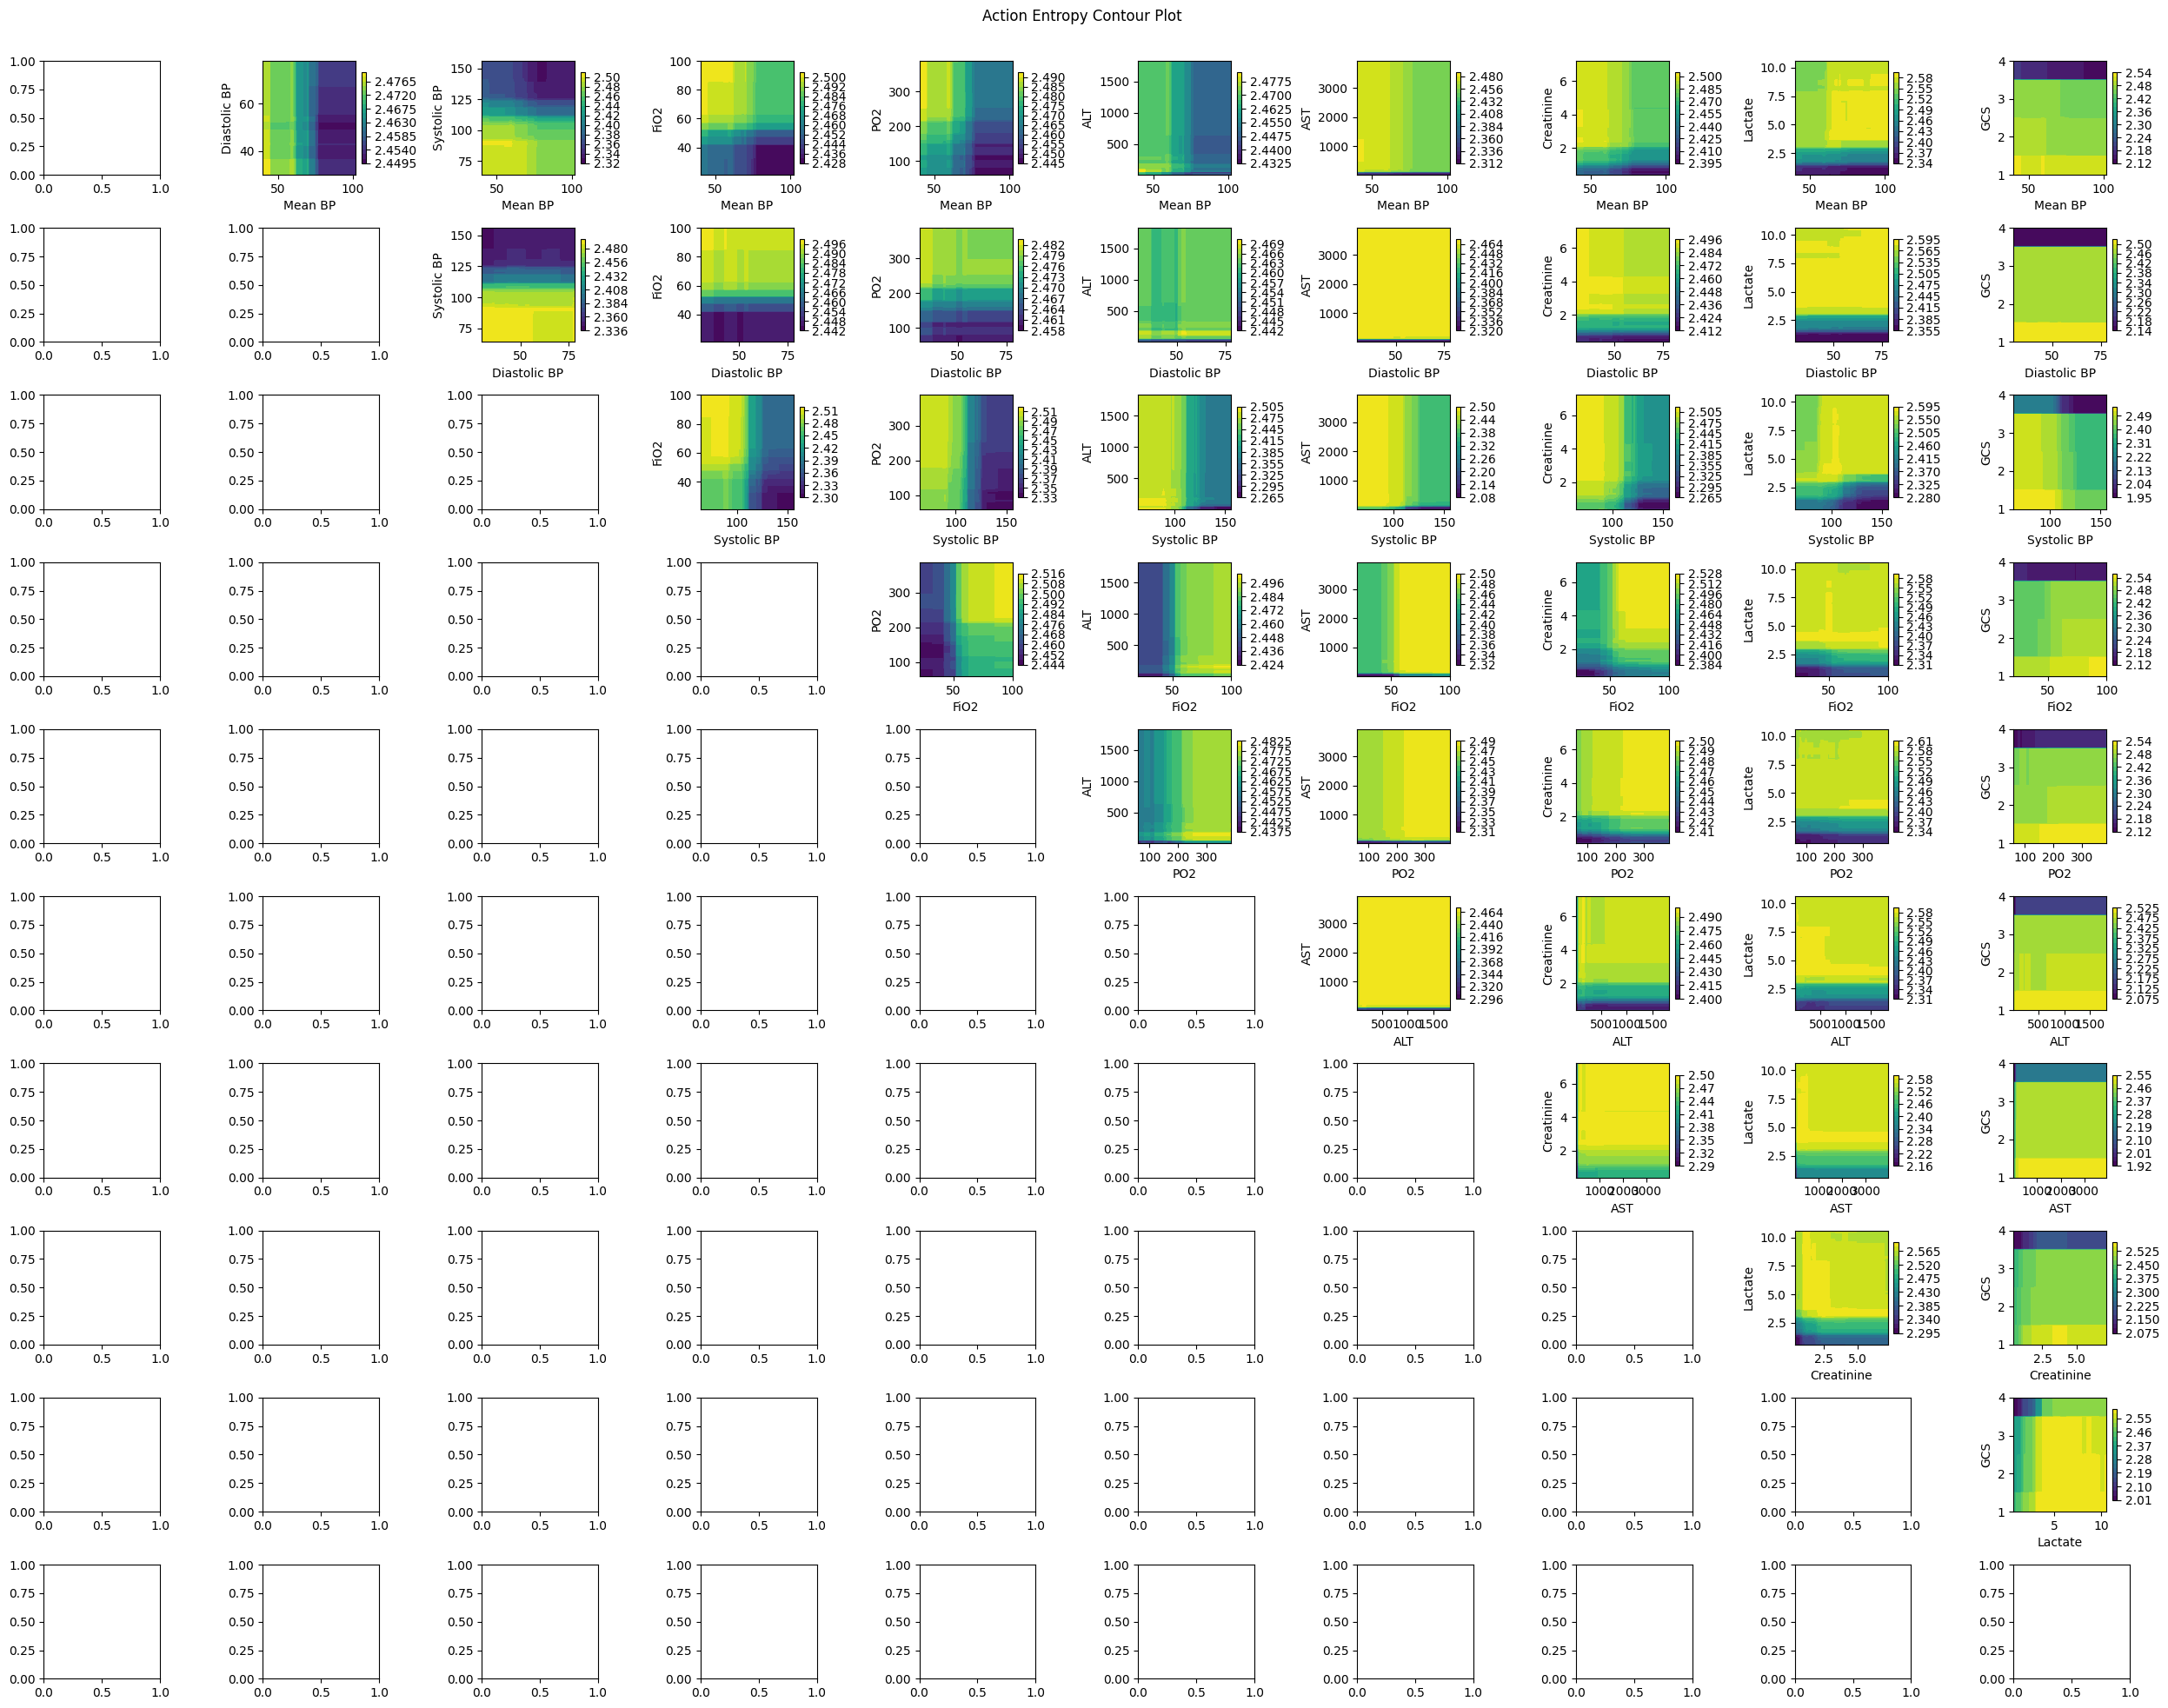

In [ ]:
contour_plot(clf, S_train_scaled, scaler)

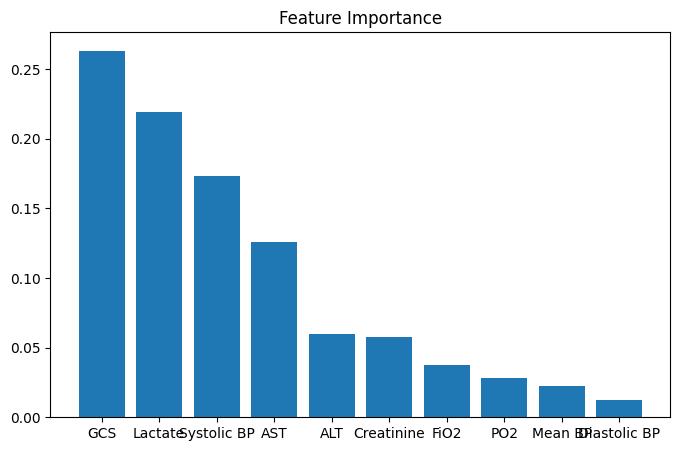

In [83]:
feature_importance_plot(clf, S_train_scaled)

In [79]:
gamma = 0.98

1.59
0.49630300286705903
0.12407575071676476


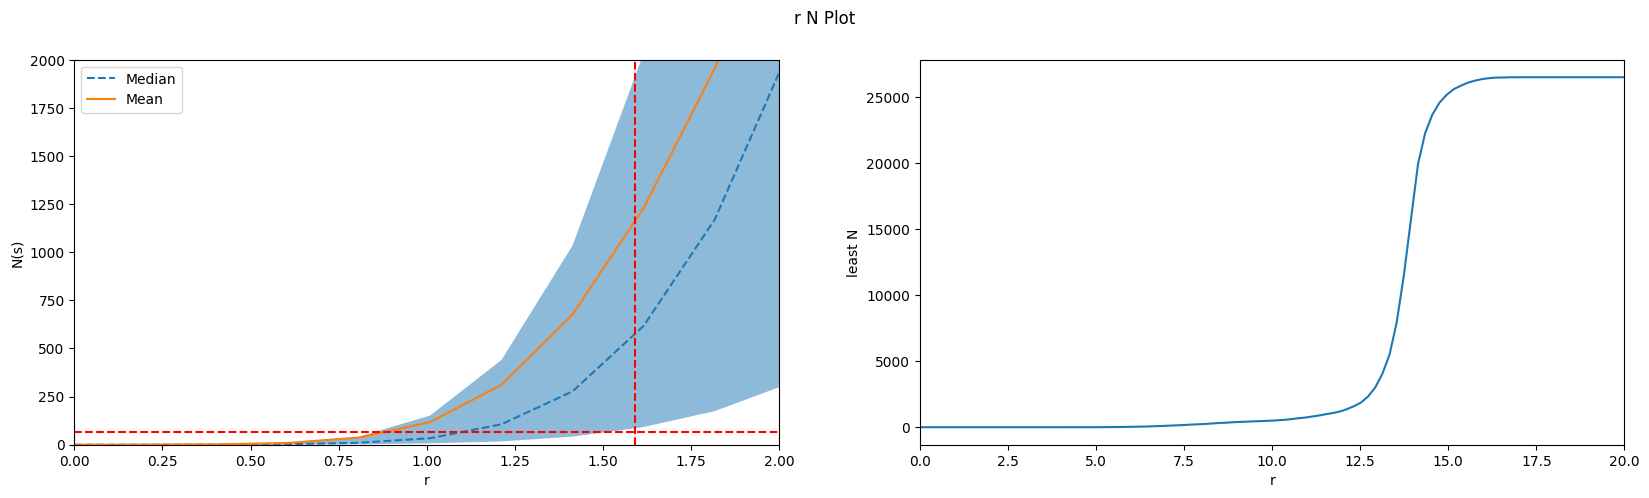

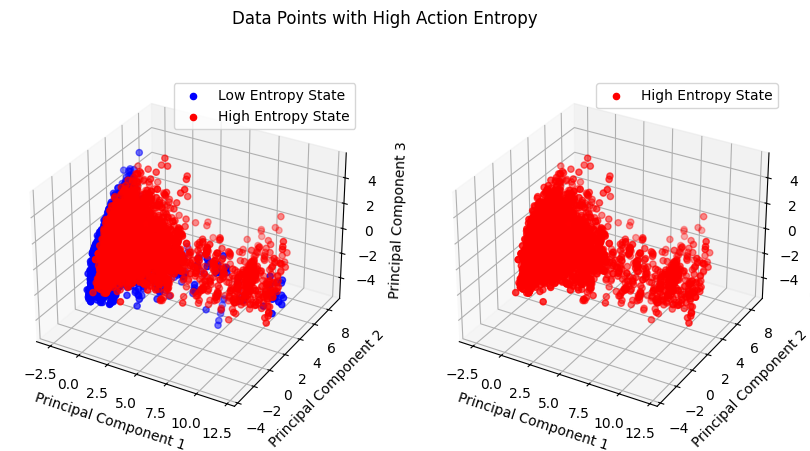

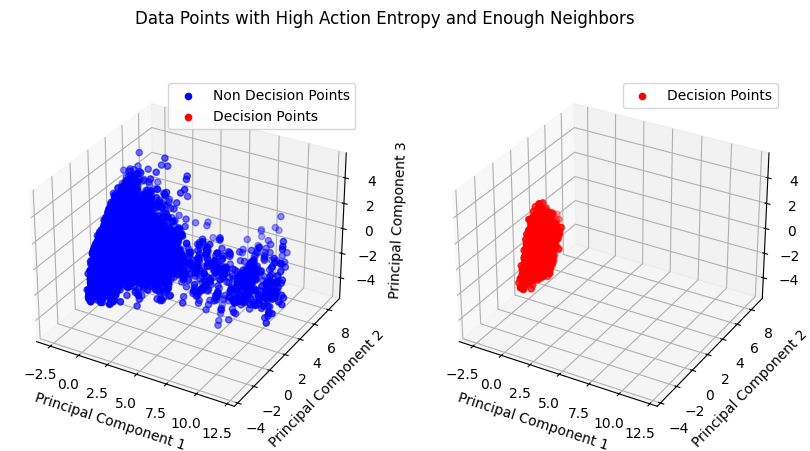

In [80]:
# Decision Point Selection
train_high_var_idx, train_safe_idx, r = decision_point(S_train_scaled, var, threshold=0.75, N_min=N_min)

# Decision Regions

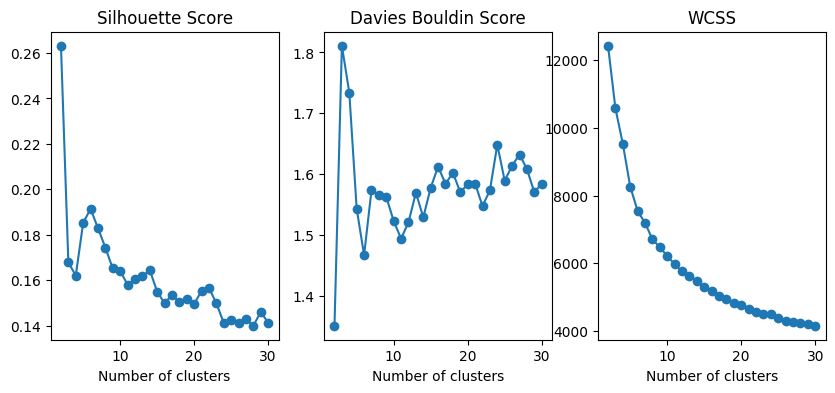

In [139]:
decision_points = S_train_scaled[train_safe_idx]

range_n_clusters = list(range(2, 31))
silhouette_scores = []
davies_bouldin_scores = []
wcss = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(decision_points)

    silhouette_avg = silhouette_score(decision_points, cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(decision_points, cluster_labels)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    wcss.append(clusterer.inertia_)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

ax1.plot(range_n_clusters, silhouette_scores, marker='o')
ax1.set_xlabel('Number of clusters')
ax1.set_title('Silhouette Score')

ax2.plot(range_n_clusters, davies_bouldin_scores, marker='o')
ax2.set_xlabel('Number of clusters')
ax2.set_title('Davies Bouldin Score')

ax3.plot(range_n_clusters, wcss, marker='o')
ax3.set_xlabel('Number of clusters')
ax3.set_title('WCSS')

plt.savefig('figures/Decision_Region_Metrics.png', dpi=300)
plt.show()

/var/folders/0k/dgv5msk922b5dj2df0q6mhs00000gn/T/ipykernel_6769/1248765985.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(decision_points_pca[cluster_labels == i, 0], decision_points_pca[cluster_labels == i, 1], decision_points_pca[cluster_labels == i, 2], c=colors[i], label=f'Cluster {i}')


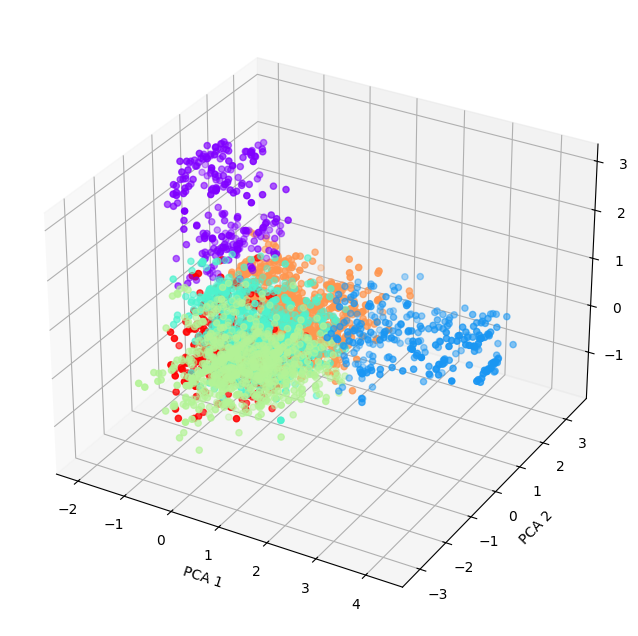

In [150]:
n_clusters = 6
clusterer = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = clusterer.fit_predict(decision_points)

cluster_idx = np.zeros(S_train.shape[0])
cluster_idx = cluster_idx + n_clusters
cluster_idx[train_safe_idx] = cluster_labels
cluster_idx[Traj_train[1:]-1] = np.where(R_train[Traj_train[1:]-1] == -1, n_clusters+1, n_clusters)

pca = PCA(n_components=10)
decision_points_pca = pca.fit_transform(decision_points)

fig = plt.figure(figsize=(15, 8))
colors = cm.rainbow(np.linspace(0, 1, n_clusters))

ax = fig.add_subplot(111, projection='3d')
x_min, x_max = decision_points_pca[:, 0].min(), decision_points_pca[:, 0].max()
y_min, y_max = decision_points_pca[:, 1].min(), decision_points_pca[:, 1].max()
z_min, z_max = decision_points_pca[:, 2].min(), decision_points_pca[:, 2].max()
for i in range(n_clusters):
    ax.scatter(decision_points_pca[cluster_labels == i, 0], decision_points_pca[cluster_labels == i, 1], decision_points_pca[cluster_labels == i, 2], c=colors[i], label=f'Cluster {i}')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
# plt.title('K-Means Clustering of Decision Points')
plt.savefig('figures/Decision_Region_Clustering.png', dpi=300)
plt.show()

In [151]:
sas_dp = []
rar_dp = []

for i in range(Traj_train.shape[0]-1):
    Traj_start = Traj_train[i]
    Traj_end = Traj_train[i+1]

    S_Traj = S_train[Traj_start:Traj_end]
    A_Traj = A_train[Traj_start:Traj_end]
    R_Traj = R_train[Traj_start:Traj_end]
    DR_Traj = cluster_idx[Traj_start:Traj_end]

    last_s = None
    last_a = None
    last_dr = None

    for idx, (s, a, dr) in enumerate(zip(S_Traj, A_Traj, DR_Traj)):
        dr = int(dr)

        # Decision Points
        if dr < n_clusters and last_dr != dr:

            # First Visit
            if last_s is not None:
                sas = np.concatenate((last_s, [last_a], s))
                sas_dp.append((sas))
                rar_dp.append((last_dr, last_a, dr))

            last_s = s
            last_a = a
            last_dr = dr

        # Same Cluster
        elif dr < n_clusters and dr == last_dr:
            last_fluid = last_a // 4
            last_vasopressor = last_a % 4
            fluid = a // 4
            vasopressor = a % 4

            max_fluid = max(last_fluid, fluid)
            max_vasopressor = max(last_vasopressor, vasopressor)
            max_action = max_fluid * 4 + max_vasopressor

            last_a = max_action

        # Termination
        elif last_s is not None and idx == len(S_Traj) - 1:
            sas = np.concatenate((last_s, [last_a], s))
            sas_dp.append((sas))
            if R_Traj[-1] == 0:
                rar_dp.append((last_dr, last_a, n_clusters))
            else:
                rar_dp.append((last_dr, last_a, n_clusters+1))

sas_dp = np.array(sas_dp)
rar_dp = np.array(rar_dp).astype(int)

print(sas_dp.shape, rar_dp.shape)

(1565, 21) (1565, 3)


In [152]:
loop_idx = np.where(rar_dp[:, 0] == rar_dp[:, 2])[0]

for i in loop_idx:
    a = rar_dp[i, 1]
    a_next = rar_dp[i+1, 1]

    fluid = a // 4
    vasopressor = a % 4
    fluid_next = a_next // 4
    vasopressor_next = a_next % 4

    max_fluid = max(fluid, fluid_next)
    max_vasopressor = max(vasopressor, vasopressor_next)
    max_action = max_fluid * 4 + max_vasopressor

    sas_dp[i+1, 10] = max_action
    rar_dp[i+1, 1] = max_action

sas_dp = np.delete(sas_dp, loop_idx, axis=0)
rar_dp = np.delete(rar_dp, loop_idx, axis=0)
print(sas_dp.shape, rar_dp.shape)

(1565, 21) (1565, 3)


In [153]:
feature_means = []
for i in range(n_clusters):
    feature_means.append(np.mean(sas_dp[rar_dp[:, 0] == i][:, 0], axis=0))

feature_means = np.array(feature_means)
sort_order = np.argsort(-feature_means)
# new_cluster_labels = np.zeros_like(cluster_labels)
# for i, label in enumerate(sort_order):
#     new_cluster_labels[cluster_labels == label] = i
# cluster_labels = new_cluster_labels
new_cluster_idx = np.zeros_like(cluster_idx)
for i, label in enumerate(sort_order):
    new_cluster_idx[cluster_idx == label] = i
new_cluster_idx[cluster_idx == n_clusters] = n_clusters
new_cluster_idx[cluster_idx == n_clusters+1] = n_clusters+1
cluster_idx = new_cluster_idx

new_rar_dp = np.zeros_like(rar_dp)
for i, label in enumerate(sort_order):
    new_rar_dp[rar_dp[:, 0] == label, 0] = i
    new_rar_dp[rar_dp[:, 2] == label, 2] = i
new_rar_dp[rar_dp[:, 0] == n_clusters, 0] = n_clusters
new_rar_dp[rar_dp[:, 2] == n_clusters, 2] = n_clusters
new_rar_dp[rar_dp[:, 0] == n_clusters+1, 0] = n_clusters+1
new_rar_dp[rar_dp[:, 2] == n_clusters+1, 2] = n_clusters+1
new_rar_dp[:, 1] = rar_dp[:, 1]
rar_dp = new_rar_dp

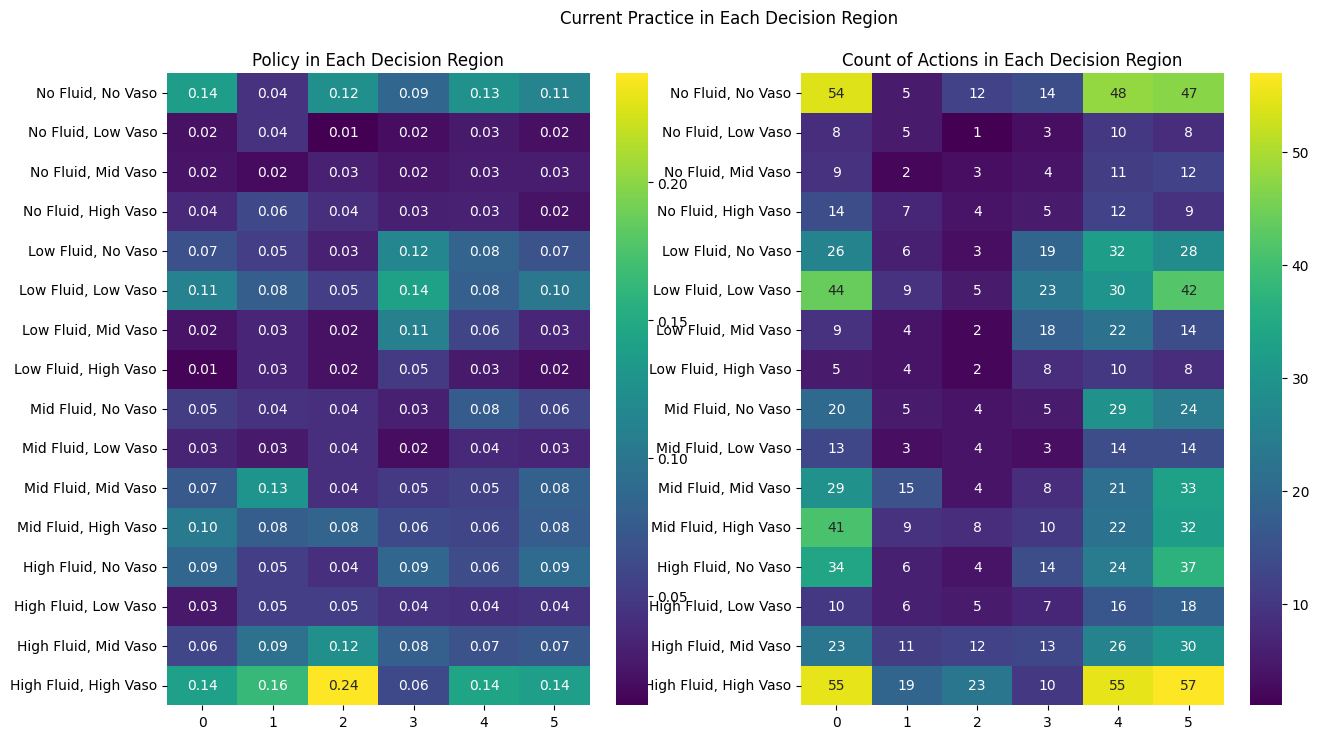

In [91]:
action_names = ['No Fluid, No Vaso', 'No Fluid, Low Vaso', 'No Fluid, Mid Vaso', 'No Fluid, High Vaso',
                'Low Fluid, No Vaso', 'Low Fluid, Low Vaso', 'Low Fluid, Mid Vaso', 'Low Fluid, High Vaso',
                'Mid Fluid, No Vaso', 'Mid Fluid, Low Vaso', 'Mid Fluid, Mid Vaso', 'Mid Fluid, High Vaso',
                'High Fluid, No Vaso', 'High Fluid, Low Vaso', 'High Fluid, Mid Vaso', 'High Fluid, High Vaso']

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

current_practice = np.zeros((16, n_clusters))
for i in range(n_clusters):
    current_practice[:, i] = np.bincount(rar_dp[rar_dp[:, 0] == i][:, 1], minlength=16)
current_practice = current_practice / np.sum(current_practice, axis=0)
current_practice = pd.DataFrame(current_practice, index=action_names, columns=range(n_clusters))
sns.heatmap(current_practice, annot=True, fmt='.2f', cmap='viridis', ax=axes[0])
axes[0].set_title('Policy in Each Decision Region')

current_practice = np.zeros((16, n_clusters))
for i in range(n_clusters):
    current_practice[:, i] = np.bincount(rar_dp[rar_dp[:, 0] == i][:, 1], minlength=16)
current_practice = pd.DataFrame(current_practice, index=action_names, columns=range(n_clusters))
sns.heatmap(current_practice, annot=True, cmap='viridis', ax=axes[1])
axes[1].set_title('Count of Actions in Each Decision Region')

plt.suptitle('Current Practice in Each Decision Region')
plt.subplots_adjust(top=0.9)
plt.savefig('figures/Decision_Region_Current_Practice.png', dpi=300)
plt.show()

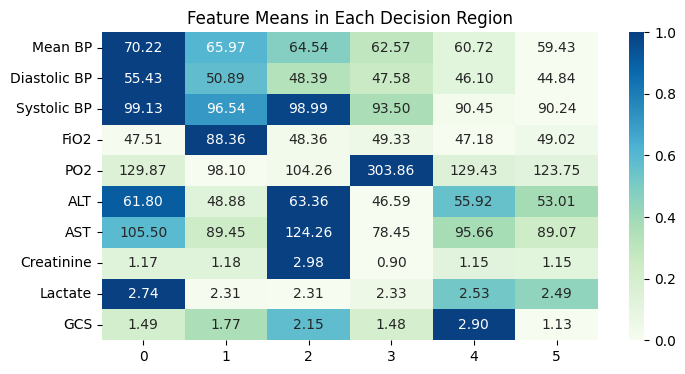

In [148]:
feature_means = []
for i in range(n_clusters):
    feature_means.append(np.mean(sas_dp[rar_dp[:, 0] == i][:, :10], axis=0))
feature_means = np.array(feature_means, dtype=float)
feature_means = feature_means.T
feature_means = pd.DataFrame(feature_means, index=state_name, columns=range(n_clusters))
feature_means_norm = (feature_means - np.min(feature_means, axis=1).values.reshape(-1, 1)) / (np.max(feature_means, axis=1) - np.min(feature_means, axis=1)).values.reshape(-1, 1)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(feature_means_norm, annot=feature_means, fmt='.2f', cmap='GnBu', ax=ax)
plt.yticks(rotation=0)
plt.title('Feature Means in Each Decision Region')
plt.savefig('figures/Decision_Region_Feature_Mean.png', dpi=300)
plt.show()

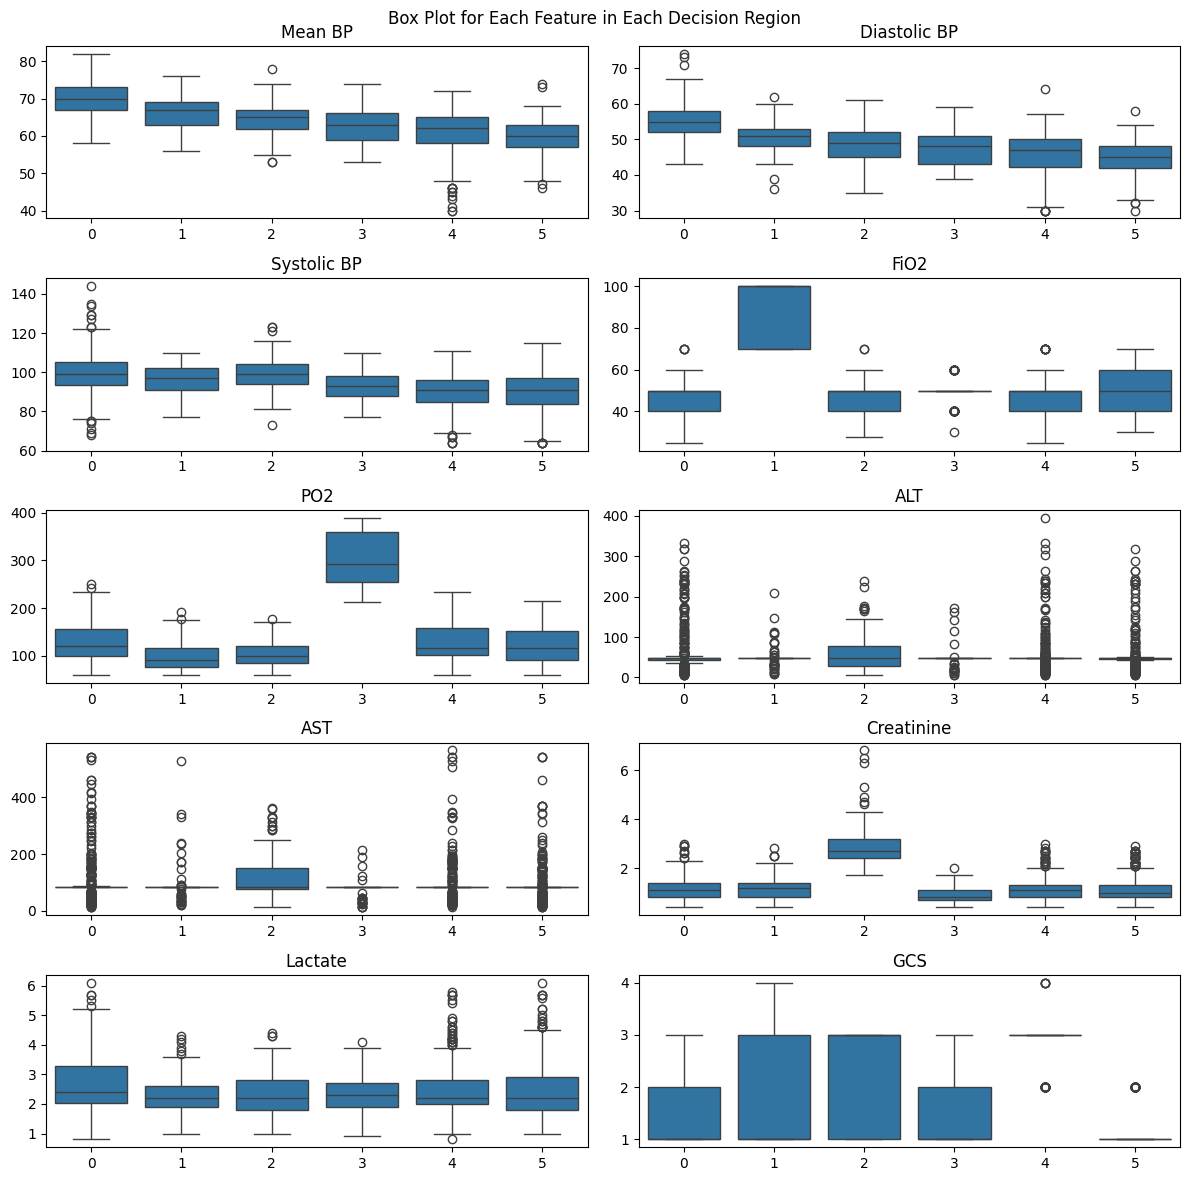

In [93]:
# Box plot for each feature in each decision region
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
for i in range(10):
    sns.boxplot(x=rar_dp[:, 0], y=sas_dp[:, i], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlim(-0.5, n_clusters-0.5)
    axes[i//2, i%2].set_title(state_name[i])
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Box Plot for Each Feature in Each Decision Region')
plt.savefig('figures/Decision_Region_Feature_Boxplot.png', dpi=300)
plt.show()

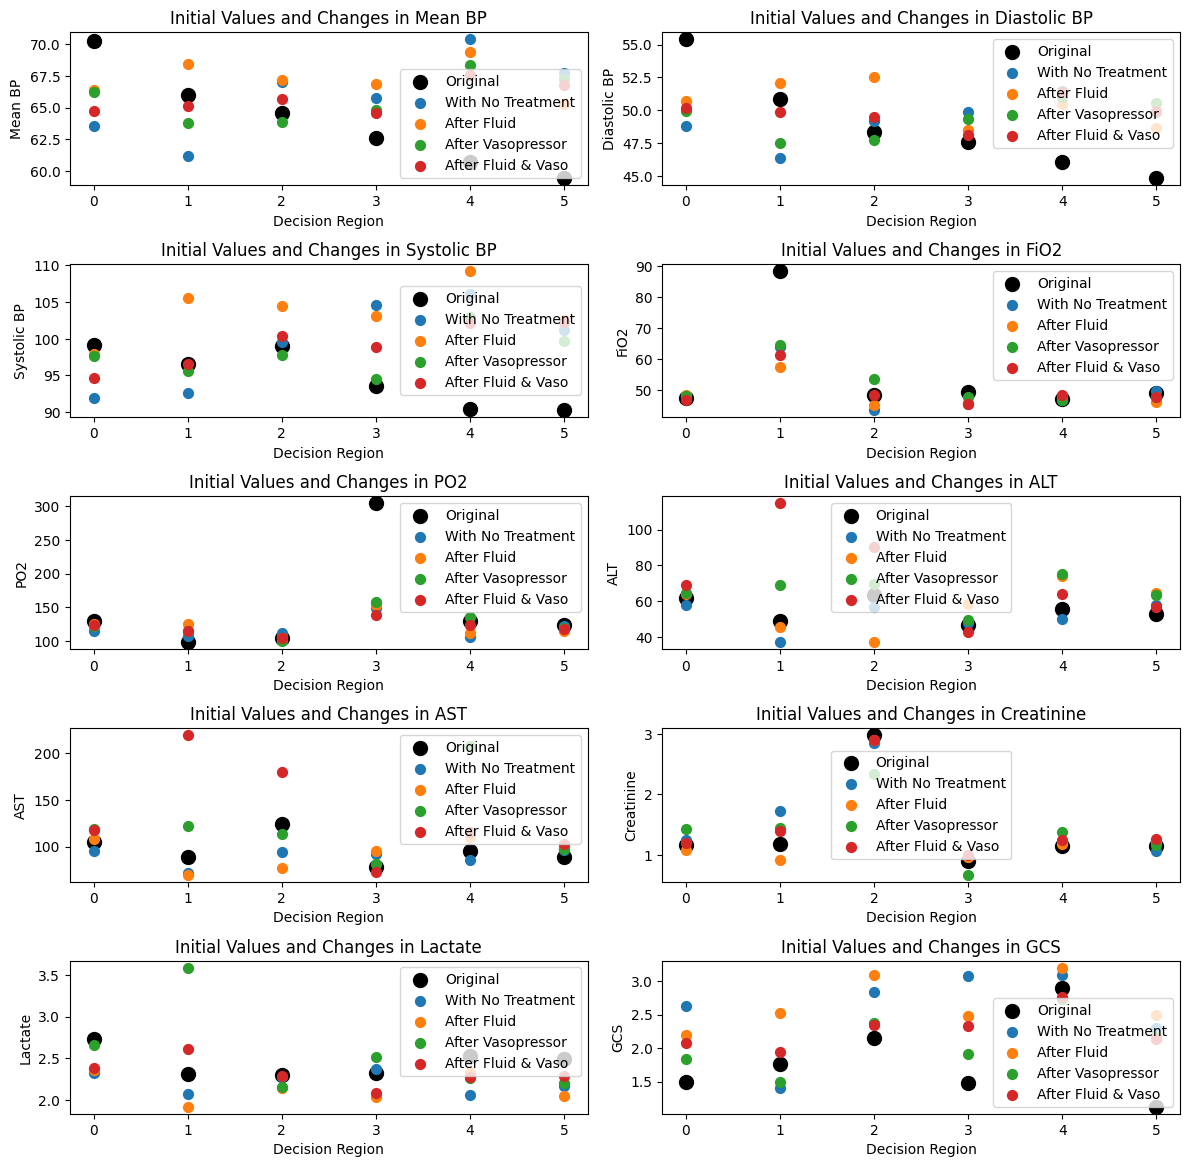

In [130]:
action_names_001 = ['Original', 'With No Treatment', 'After Fluid', 'After Vasopressor', 'After Fluid & Vaso']
action_combination = [[0], [4, 8, 12], [1, 2, 3], [5, 6, 7, 9, 10, 11, 13, 14, 15]]

fig, axes = plt.subplots(5, 2, figsize=(12, 12))

# Loop through each k value to create a plot in the appropriate subplot
for k in range(10):
    values = np.zeros((n_clusters, 5))
    for i in range(n_clusters):
        # Mean for the original data in the first column
        values[i, 0] = np.mean(sas_dp[rar_dp[:, 0] == i][:, 0+k], axis=0)
        # Loop over action combinations for the remaining columns
        for j in range(1, 5):
            action = action_combination[j-1]
            data = sas_dp[(rar_dp[:, 0] == i) & np.isin(rar_dp[:, 1], action)][:, 11+k]
            values[i, j] = np.mean(data, axis=0)

    values_df = pd.DataFrame(values, index=range(n_clusters), columns=action_names_001)

    row = k // 2
    col = k % 2

    ax = axes[row, col]
    ax.scatter(range(n_clusters), values_df.iloc[:, 0], label='Original', marker='o', color='black', s=100)
    
    for i in range(1, 5):
        ax.scatter(range(n_clusters), values_df.iloc[:, i], label=action_names_001[i], s=50)

    ax.set_xlabel('Decision Region')
    ax.set_ylabel(state_name[k])
    ax.set_title('Initial Values and Changes in ' + state_name[k])
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('figures/Decision_Region_After_Feature_Mean_01.png', dpi=300)
plt.show()

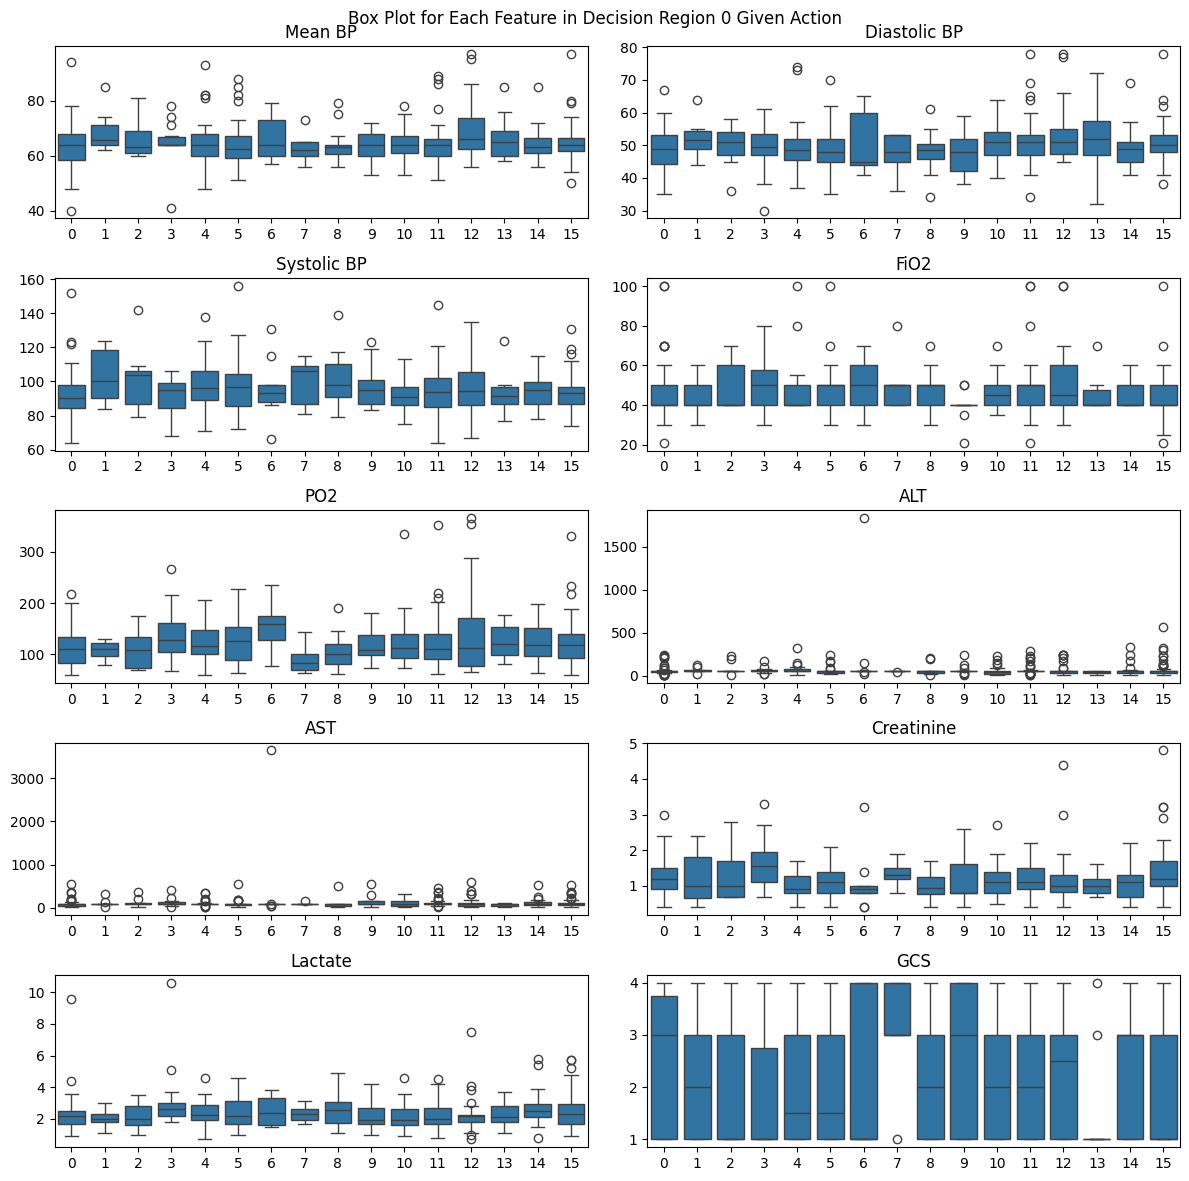

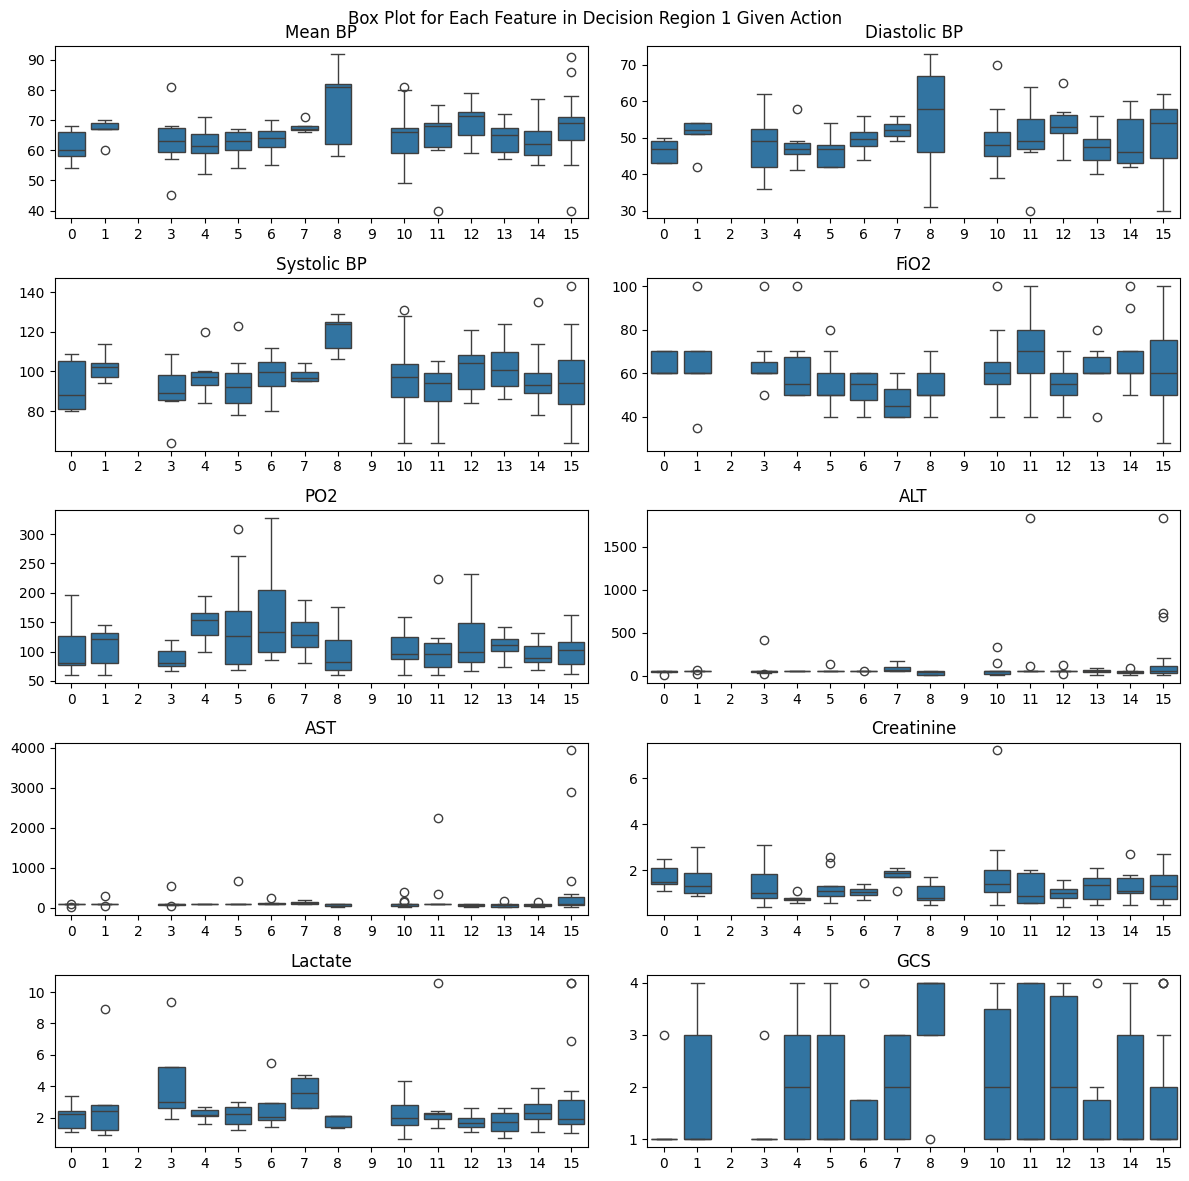

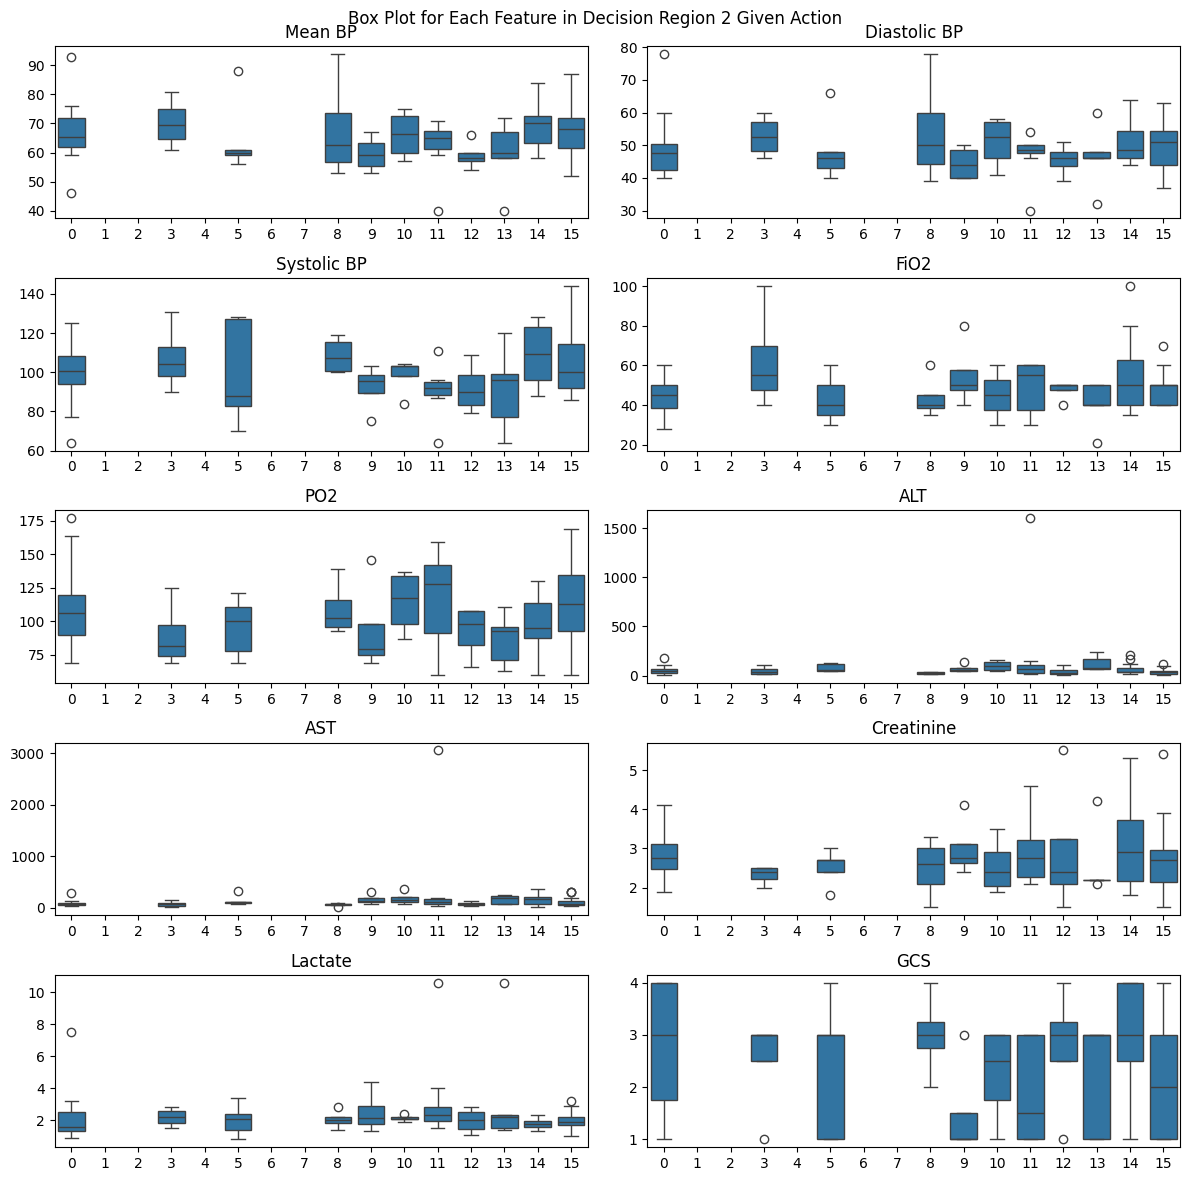

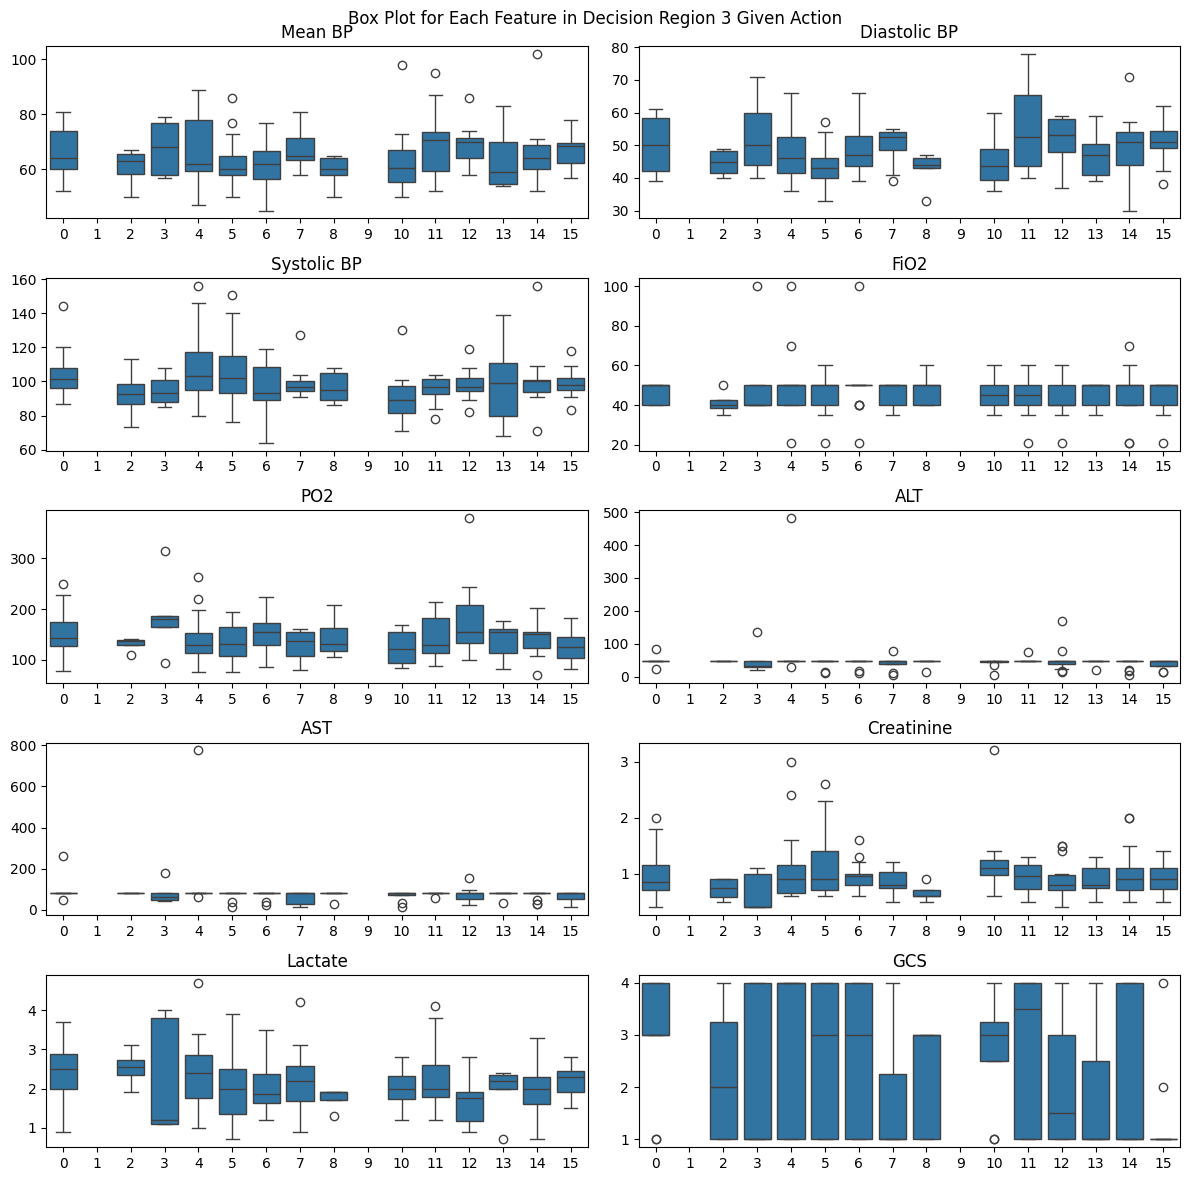

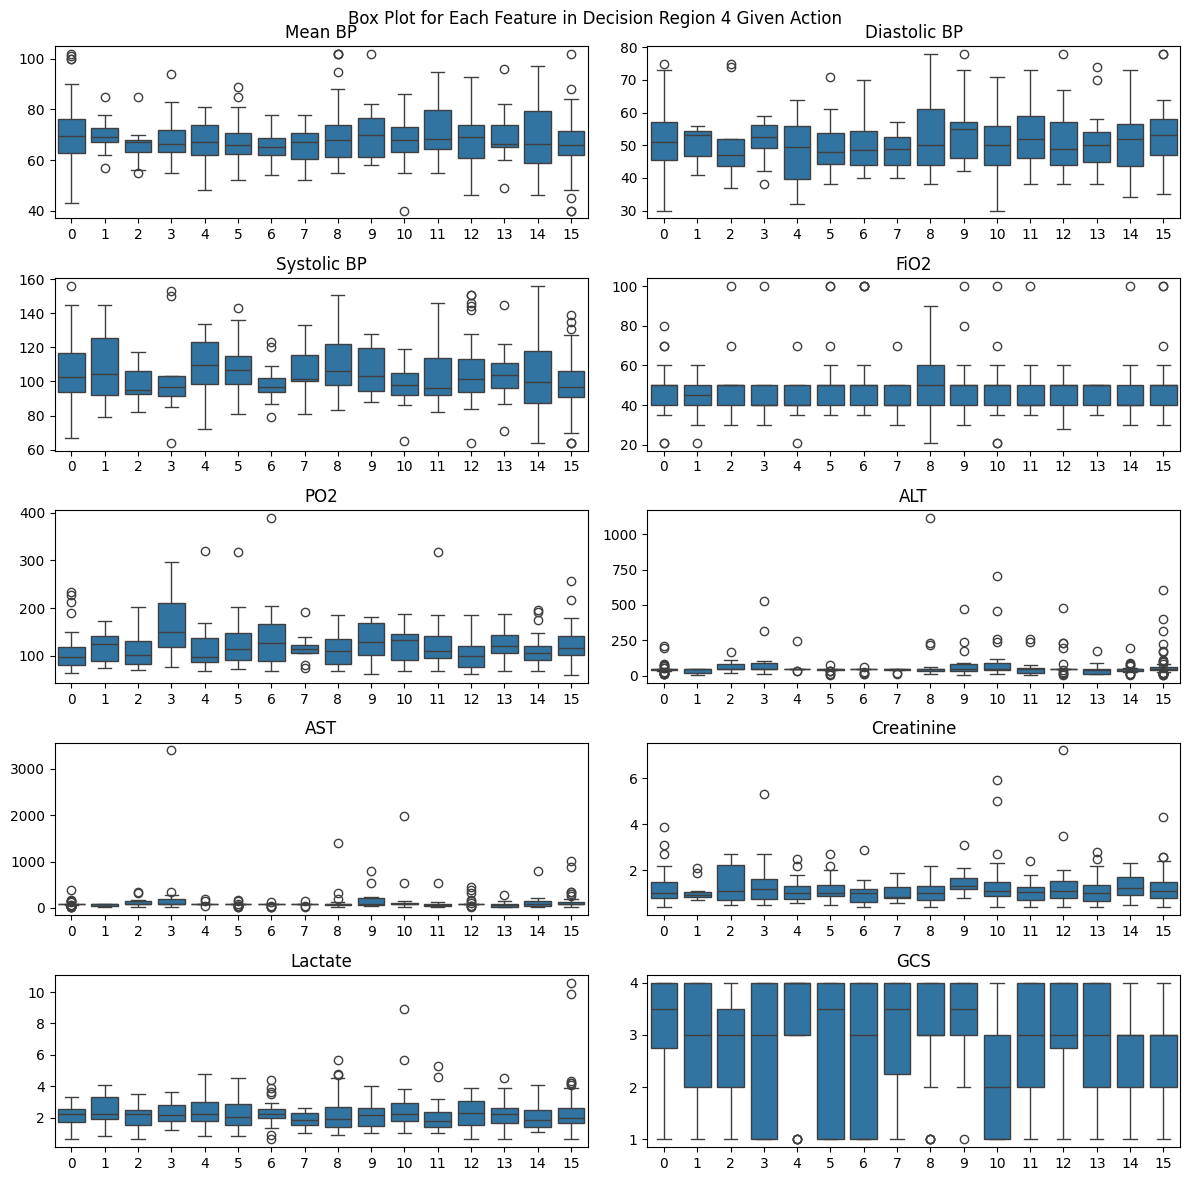

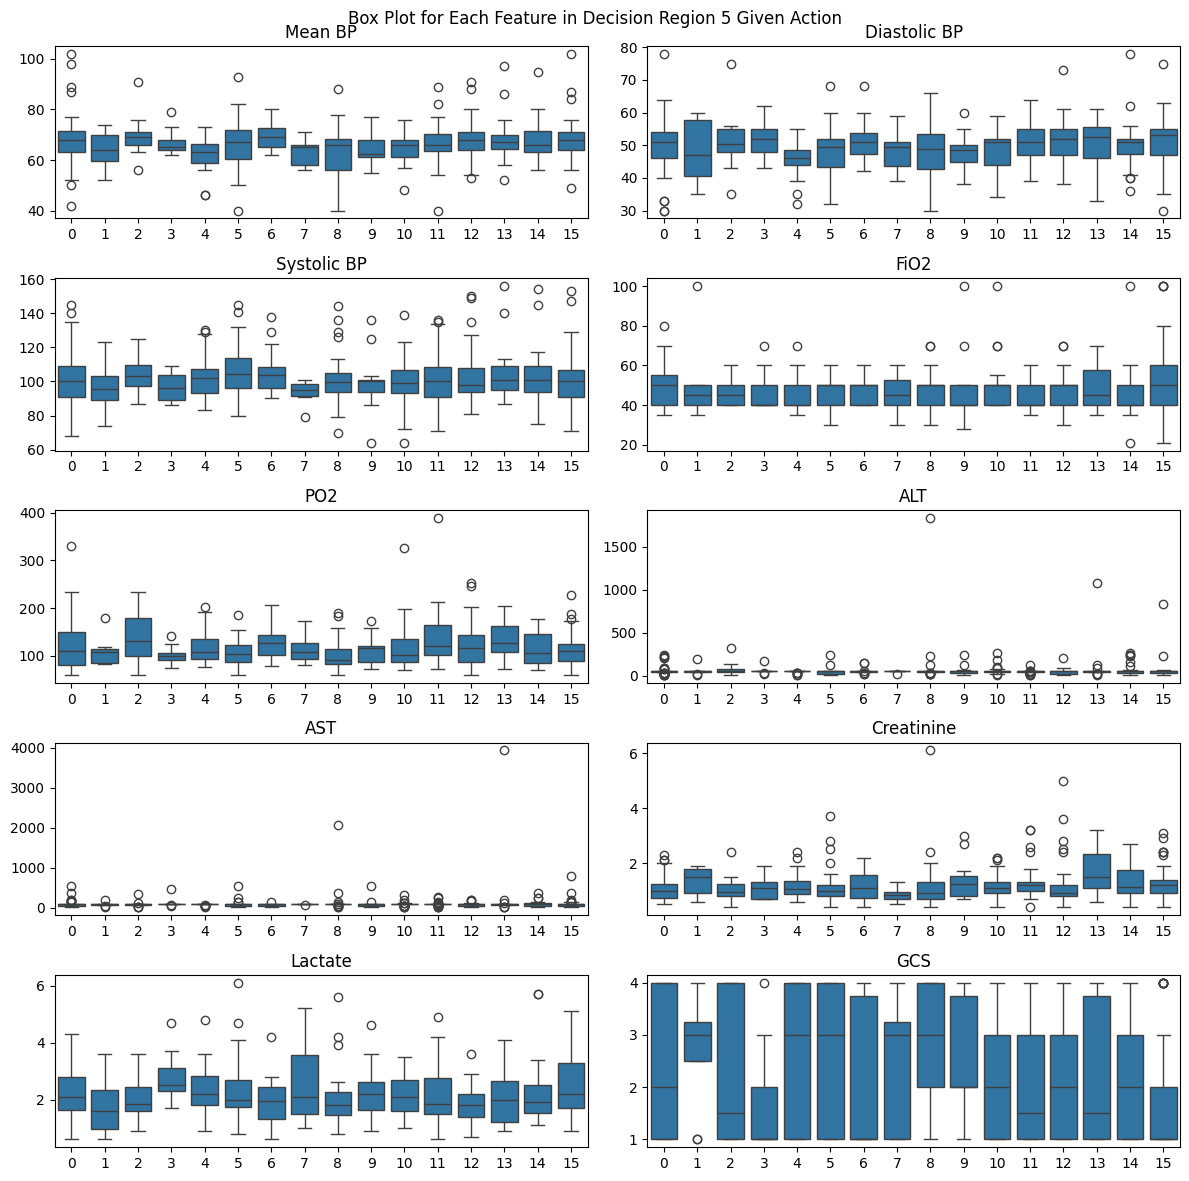

In [123]:
# Box plot for each feature in each decision region given action
count = np.zeros((n_clusters, 16))
for i in range(n_clusters):
    count[i] = np.bincount(rar_dp[rar_dp[:, 0] == i][:, 1], minlength=16)

sas_dp_clean = sas_dp.copy()
rar_dp_clean = rar_dp.copy()
for i in range(n_clusters):
    for j in range(16):
        if count[i, j] < SA_min:
            sas_dp_clean = sas_dp_clean[~((rar_dp_clean[:, 0] == i) & (rar_dp_clean[:, 1] == j))]
            rar_dp_clean = rar_dp_clean[~((rar_dp_clean[:, 0] == i) & (rar_dp_clean[:, 1] == j))]

for i in range(n_clusters):
    fig, axes = plt.subplots(5, 2, figsize=(12, 12))
    for j in range(10):
        sns.boxplot(x=rar_dp_clean[rar_dp_clean[:, 0] == i][:, 1], y=sas_dp_clean[rar_dp_clean[:, 0] == i][:, 11+j], order=range(16), ax=axes[j//2, j%2])
        axes[j//2, j%2].set_title(state_name[j])
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle(f'Box Plot for Each Feature in Decision Region {i} Given Action')
    plt.savefig(f'figures/Decision_Region_After_Feature_Boxplot_{i}.png', dpi=300)
    plt.show()

# KNN

In [101]:
param_grid = {'n_neighbors': range(1, 31)}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(S_train_scaled, cluster_idx)

print('Best Param:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Param: {'n_neighbors': 17}
Best Score: 0.9248903450954893


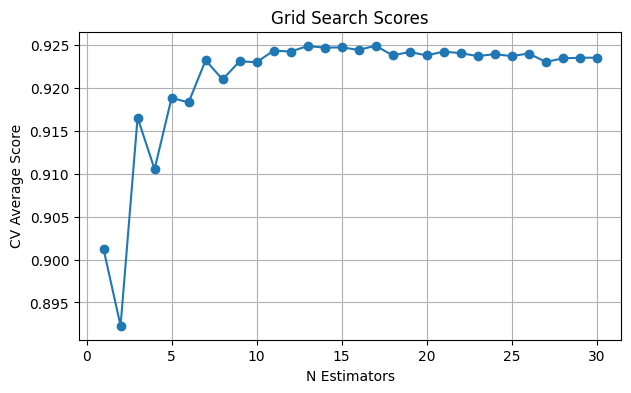

In [129]:
plt.figure(figsize=(7, 4))

    # Get Test Scores Mean for each grid search result
plt.plot(range(1, 31), grid_search.cv_results_['mean_test_score'], label='CV Average Score', marker='o')

plt.title("Grid Search Scores")
plt.xlabel('N Estimators')
plt.ylabel('CV Average Score')
plt.grid('on')
plt.savefig('figures/KNN_Grid_Search.png', dpi=300)
plt.show()

In [154]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(S_train_scaled, cluster_idx)

print('KNN Score:', knn.score(S_train_scaled, cluster_idx))
print()

for i in range(n_clusters+2):
    print(f'Cluster {i} ({np.sum(cluster_idx == i)})')
    print(knn.score(S_train_scaled[cluster_idx == i], cluster_idx[cluster_idx == i]))
    print()

KNN Score: 0.9478647955334238

Cluster 0 (791)
0.7003792667509482

Cluster 1 (242)
0.7231404958677686

Cluster 2 (331)
0.5830815709969789

Cluster 3 (267)
0.8801498127340824

Cluster 4 (838)
0.6957040572792362

Cluster 5 (780)
0.867948717948718

Cluster 6 (23097)
0.9832012815517167

Cluster 7 (162)
0.0



In [104]:
for i in range(10):
    print(knn.predict(S_train_scaled[i].reshape(1, -1))[0], cluster_idx[i])

6.0 6.0
6.0 6.0
3.0 3.0
3.0 3.0
3.0 3.0
0.0 0.0
6.0 6.0
6.0 6.0
6.0 6.0
6.0 6.0


# T, R

In [111]:
def map_to_reward(map_list, dr_list):

    reward_list = []

    for map_value, dr_value in zip(map_list, dr_list):
        # MAP value
        if map_value < 40:
            reward = -1
        elif map_value < 55:
            reward = (-0.15 - -1) / (55 - 40) *  (map_value - 40) + -1
        elif map_value < 60:
            reward = (-0.05 - -0.15) / (60 - 55) *  (map_value - 55) + -0.15
        elif map_value < 65:
            reward = (0 - -0.05) / (65 - 60) *  (map_value - 60) + -0.05
        else:
            reward = 0

        # Alive or Dead
        if dr_value == n_clusters:
            reward = 0
        elif dr_value == n_clusters+1:
            reward = -1

        reward_list.append(reward)

    return reward_list

(8, 16, 8)


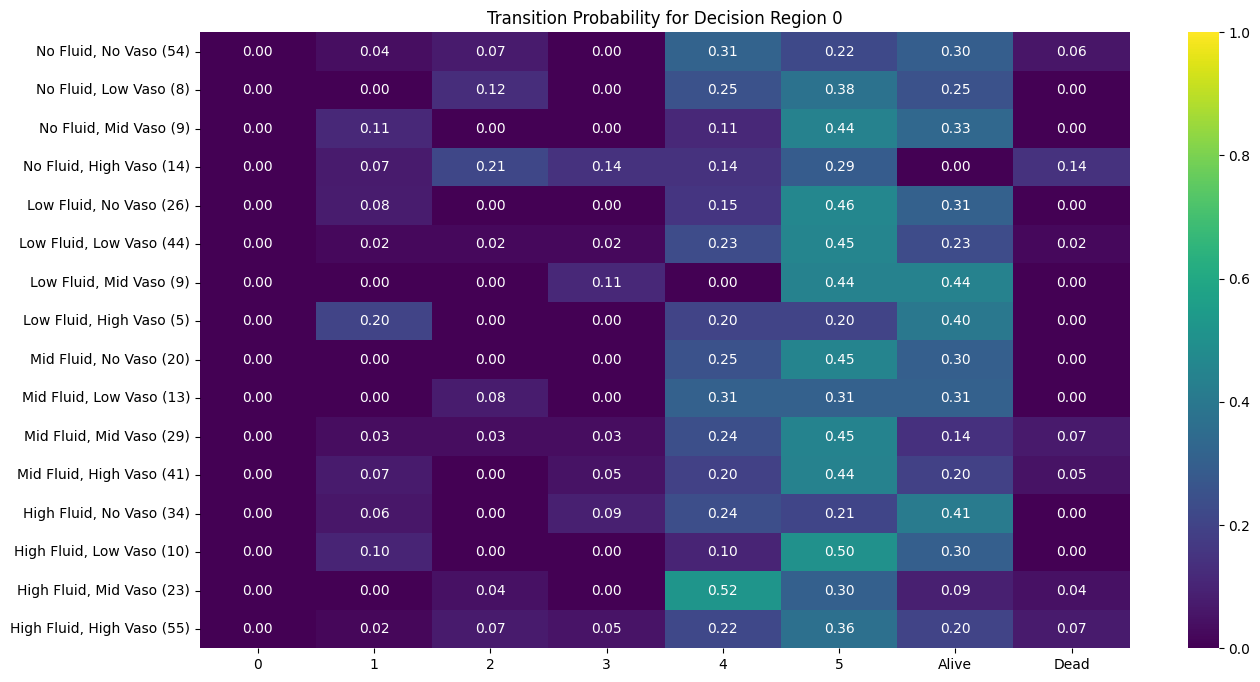

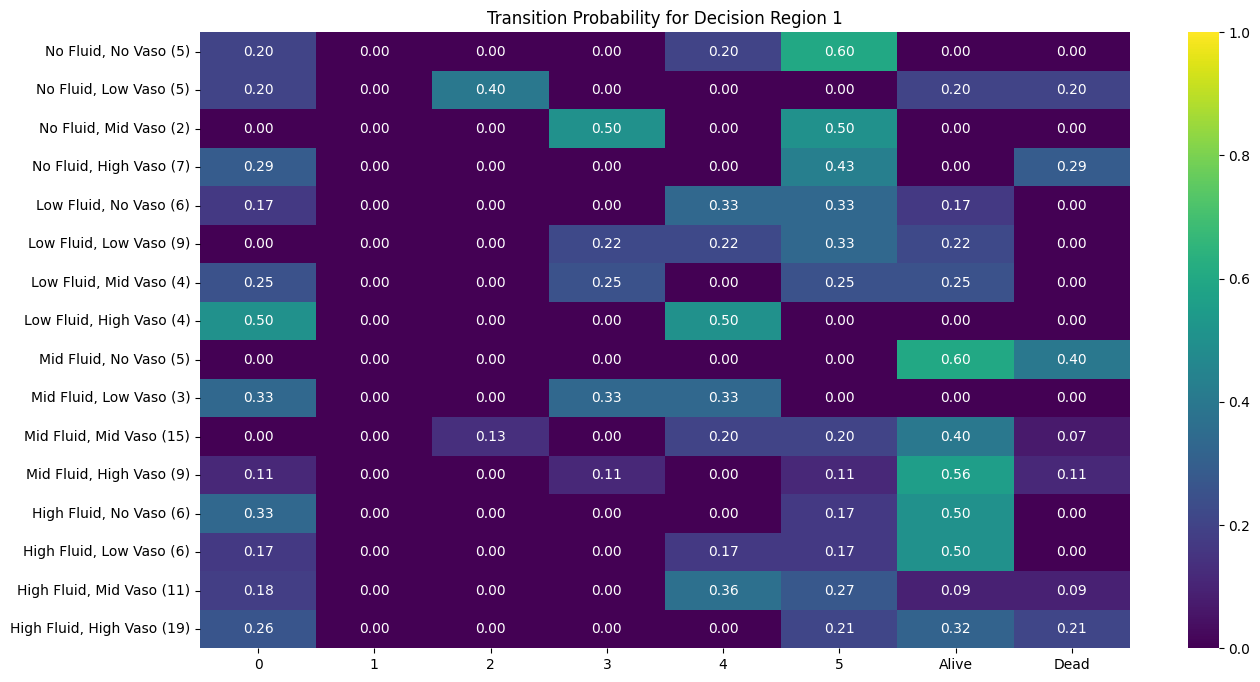

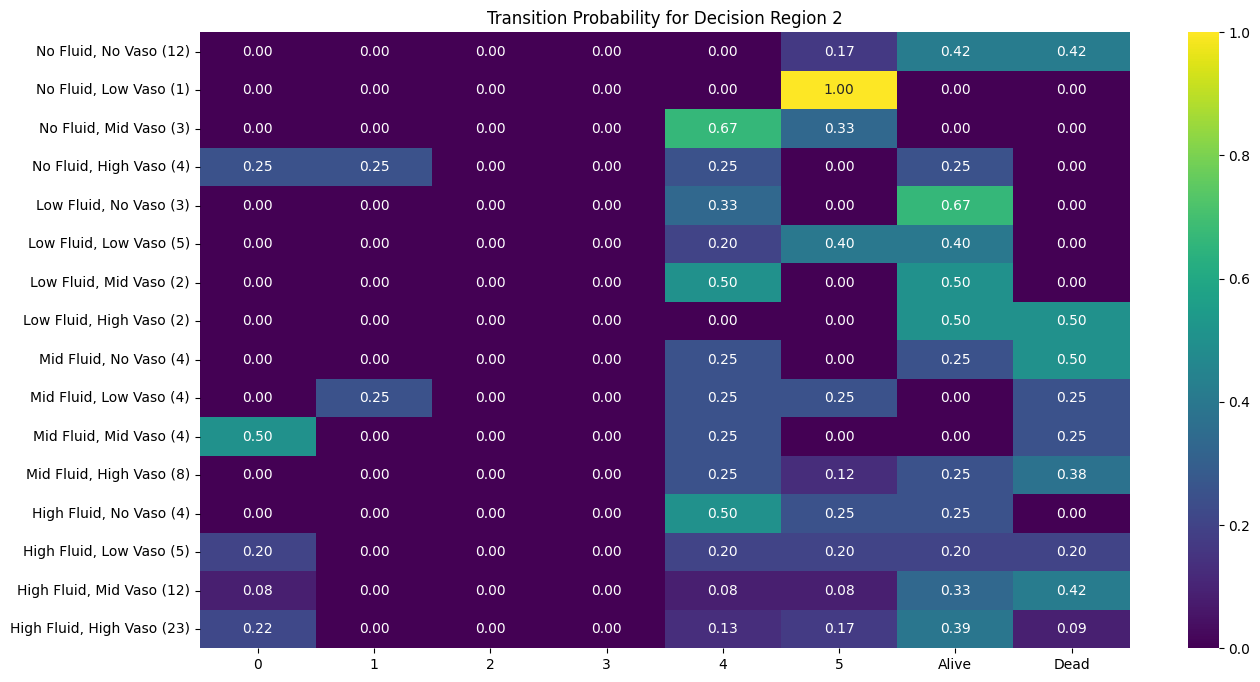

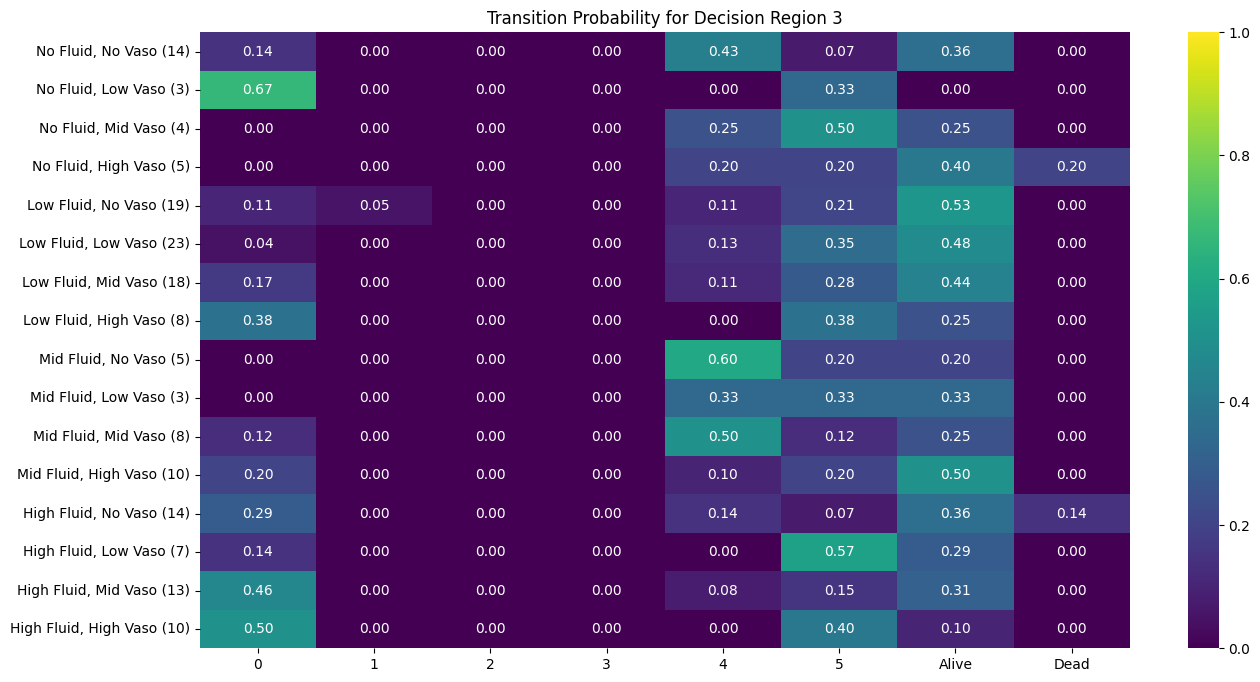

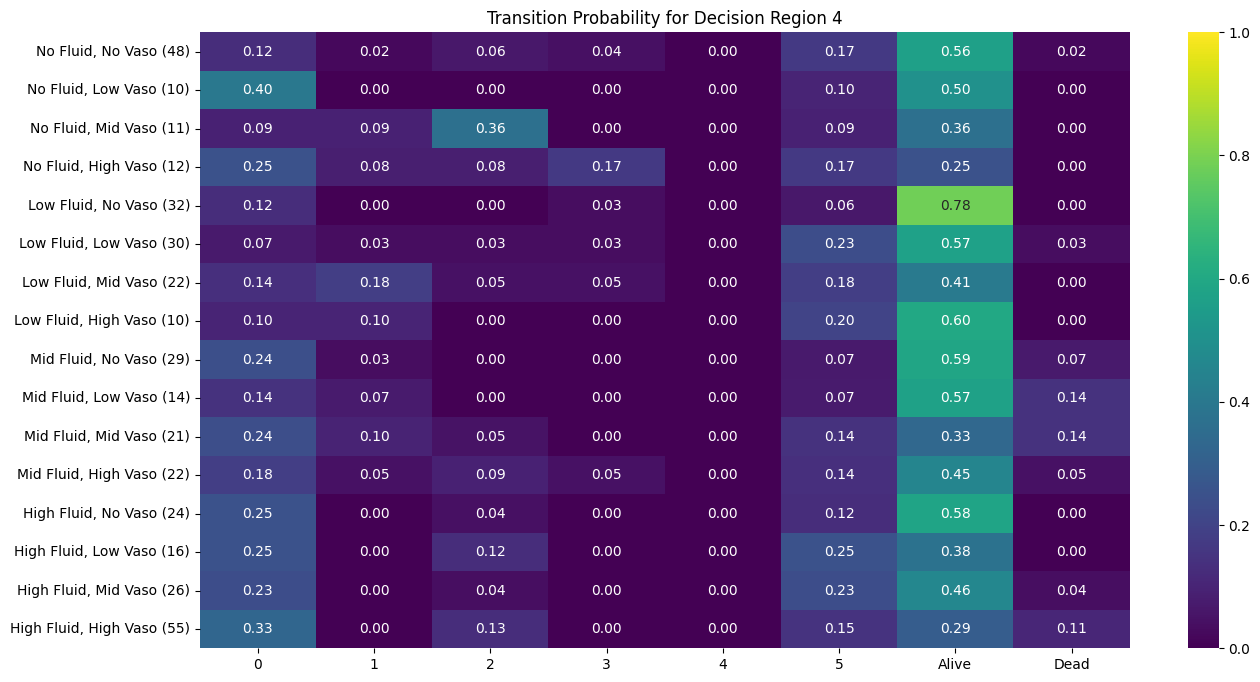

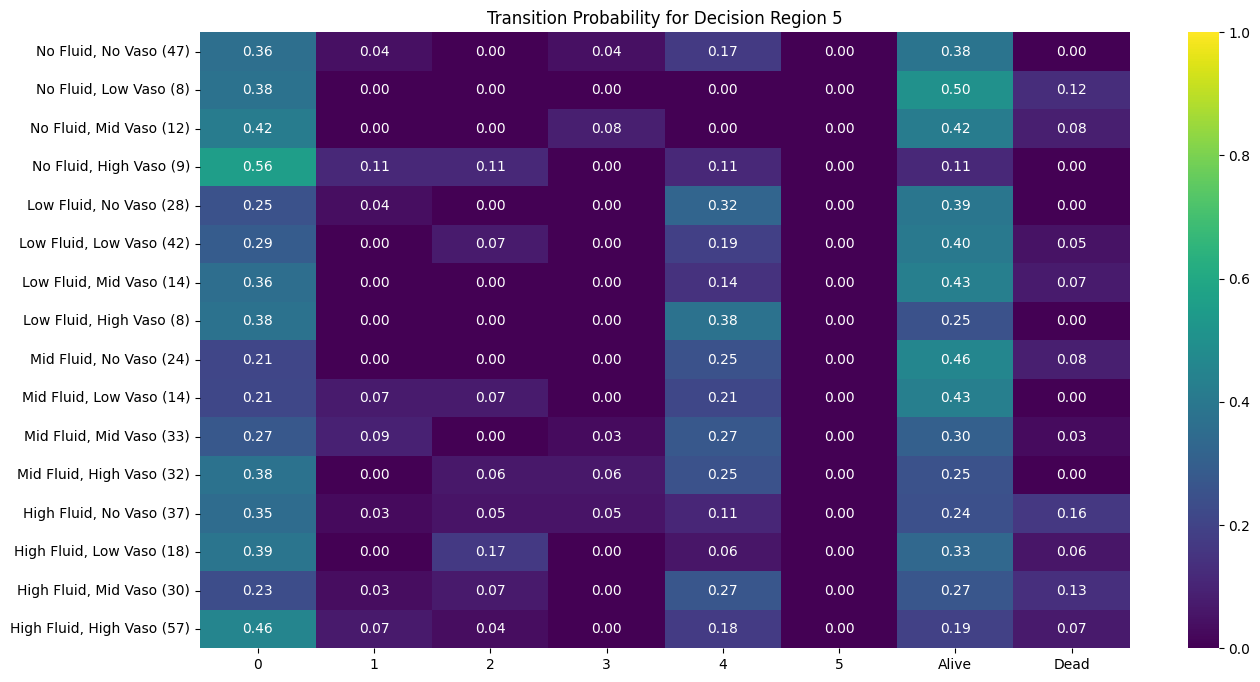

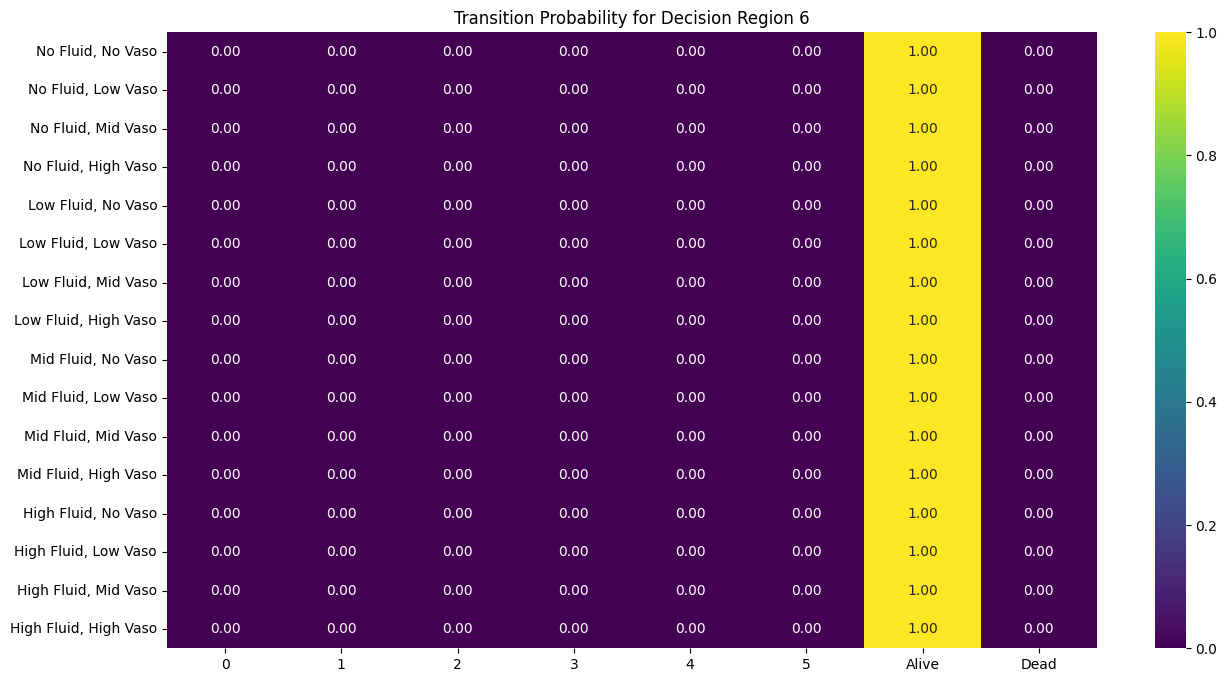

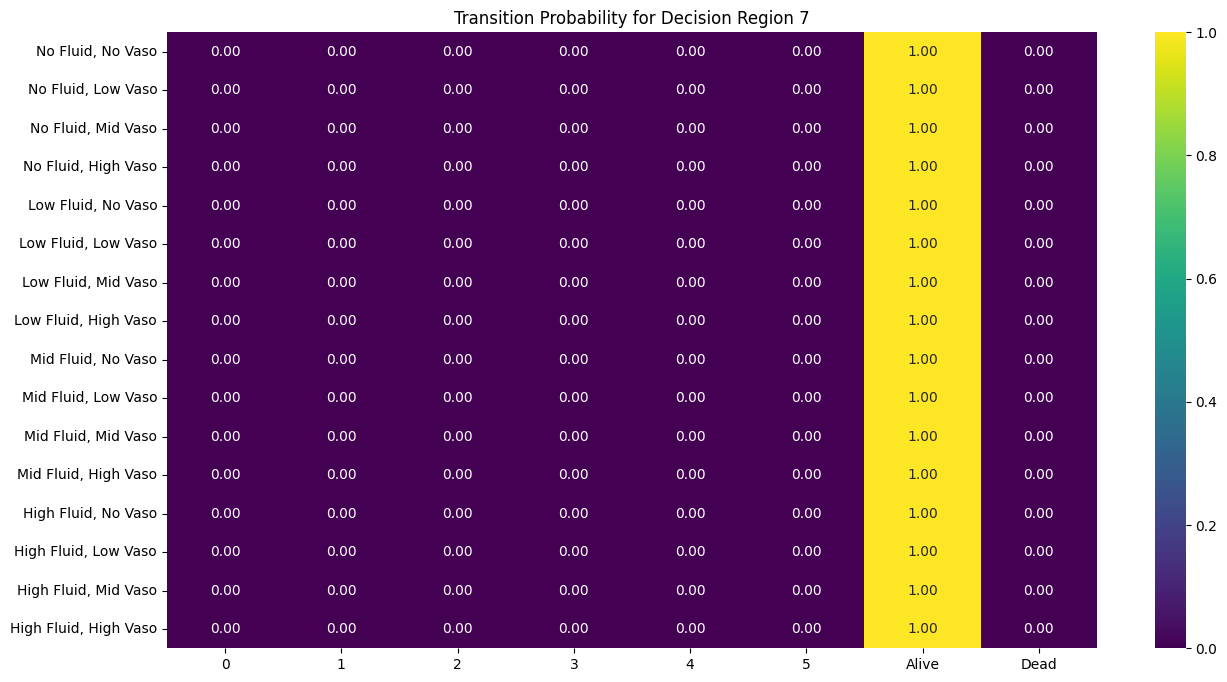

In [144]:
T_mat = np.zeros((n_clusters+2, 16, n_clusters+2))

for dr in range(n_clusters):
    for a in range(16):
        next_dr = rar_dp[(rar_dp[:, 0] == dr) & (rar_dp[:, 1] == a)][:, 2]
        T_mat[dr, a] = np.bincount(next_dr, minlength=n_clusters+2)

T_mat[n_clusters, :, n_clusters] = 1
T_mat[n_clusters+1, :, n_clusters] = 1

sums = np.sum(T_mat, axis=2).reshape(n_clusters+2, 16, 1)
sums[sums == 0] = 1
T_mat = T_mat / sums

print(T_mat.shape)

for i in range(n_clusters+2):
    action_names_count = action_names.copy()
    if i < n_clusters:
        for j in range(len(action_names_count)):
            action_names_count[j] += ' ({})'.format(int(count[i, j]))

    trans_prob = pd.DataFrame(T_mat[i], index=action_names_count, columns=list(range(n_clusters)) + ['Alive', 'Dead'])

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.heatmap(trans_prob, annot=True, fmt='.2f', cmap='viridis', ax=ax, vmax=1)
    plt.title('Transition Probability for Decision Region {}'.format(i))
    if i < n_clusters:
        plt.savefig('figures/Policy_Learning_T_{}.png'.format(i), dpi=300)
    plt.show()

In [113]:
R_mat = np.zeros((n_clusters+2, 16, n_clusters+2))

for i in range(n_clusters):
    map_values = sas_dp[rar_dp[:, 2] == i][:, 11]
    dr_values = rar_dp[rar_dp[:, 2] == i][:, 2]
    R_list = map_to_reward(map_values, dr_values)
    if len(R_list) != 0:
        R_mat[:, :, i] = np.mean(R_list)

R_mat[:, :, n_clusters+1] = -1

print(R_mat.shape)
print(R_mat[0, 0])

(8, 16, 8)
[-6.85920578e-04 -1.68085106e-02 -1.70000000e-02 -2.45714286e-02
 -6.14326241e-02 -8.83687943e-02  0.00000000e+00 -1.00000000e+00]


# Value Iteration

In [114]:
count = np.zeros((n_clusters+2, 16))

for i in range(n_clusters):
    count[i] = np.bincount(rar_dp[rar_dp[:, 0] == i][:, 1], minlength=16)

count[n_clusters] = SA_min
count[n_clusters+1] = SA_min

print(count)

[[54.  8.  9. 14. 26. 44.  9.  5. 20. 13. 29. 41. 34. 10. 23. 55.]
 [ 5.  5.  2.  7.  6.  9.  4.  4.  5.  3. 15.  9.  6.  6. 11. 19.]
 [12.  1.  3.  4.  3.  5.  2.  2.  4.  4.  4.  8.  4.  5. 12. 23.]
 [14.  3.  4.  5. 19. 23. 18.  8.  5.  3.  8. 10. 14.  7. 13. 10.]
 [48. 10. 11. 12. 32. 30. 22. 10. 29. 14. 21. 22. 24. 16. 26. 55.]
 [47.  8. 12.  9. 28. 42. 14.  8. 24. 14. 33. 32. 37. 18. 30. 57.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]]


In [115]:
def vi(T, R, gamma, tol=1e-10, max_iter=1000):
    n_states, n_actions, _ = T.shape
    V = np.zeros(n_states)
    Q = np.zeros((n_states, n_actions))
    policy = np.zeros(n_states)

    for i in range(max_iter):
        V_prev = np.copy(V)

        Q = np.sum(T * (R + gamma * V), axis=2)
        Q[count < SA_min] = -np.inf

        V = np.max(Q, axis=1)
        policy = np.argmax(Q, axis=1)

        if np.max(np.abs(V - V_prev)) < tol:
            break
    
    print(f'Converged in {i+1} iterations')

    return V, policy

In [116]:
V, policy = vi(T_mat, R_mat, gamma)

print(V)
print(policy)

Converged in 28 iterations
[-0.05075484 -0.03734141 -0.04525068 -0.04217847 -0.0160626  -0.03553912
  0.          0.        ]
[ 7 12  3  4  4  9  0  0]


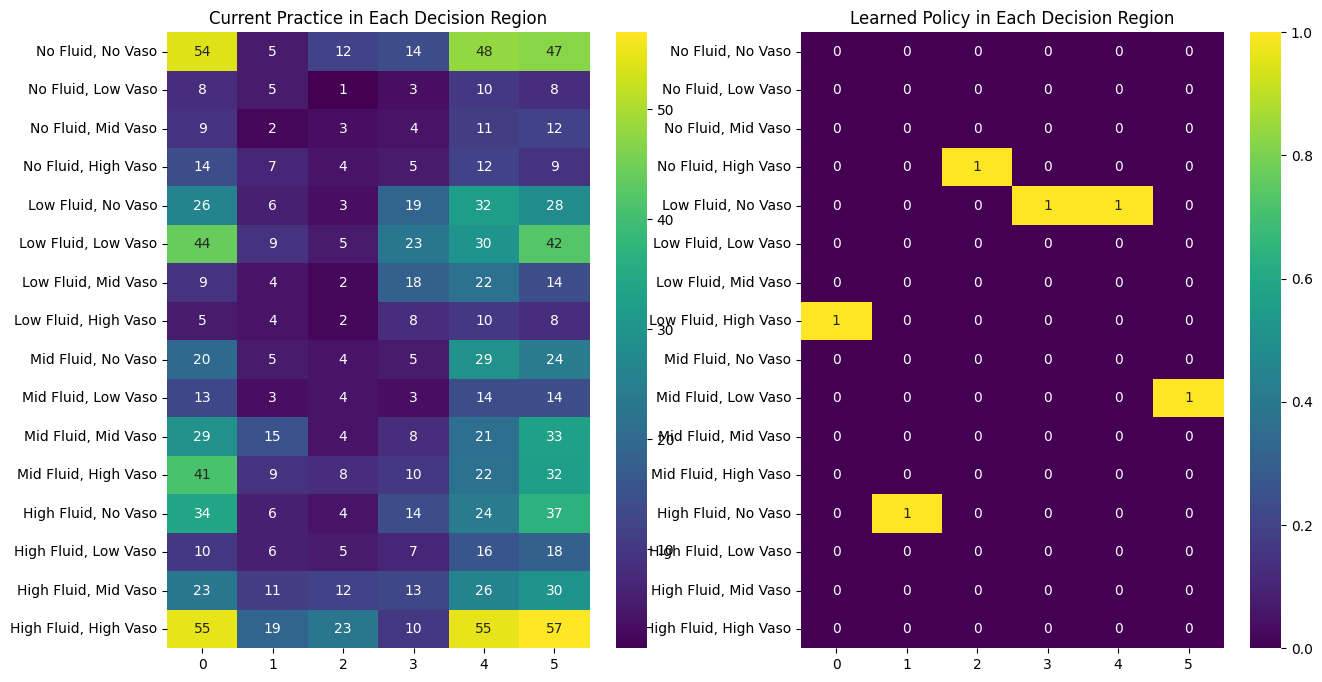

In [155]:
policy_learned = np.zeros((n_clusters, 16))
for i in range(n_clusters):
    policy_learned[i, policy[i]] = 1

policy_learned_df = pd.DataFrame(policy_learned, index=range(n_clusters), columns=action_names)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(current_practice, annot=True, cmap='viridis', ax=ax[0])
ax[0].set_title('Current Practice in Each Decision Region')
sns.heatmap(policy_learned_df.T, annot=True, cmap='viridis', ax=ax[1])
ax[1].set_title('Learned Policy in Each Decision Region')
plt.savefig('figures/Policy_Learning.png', dpi=300)
plt.show()

In [164]:
seed = 42
set_seed(seed)

In [165]:
evaluate_learned(cluster_idx, n_clusters, clf, policy_learned, S_train_scaled, A_train, R_train, Traj_train, gamma=gamma)

100%|██████████| 100/100 [2:24:29<00:00, 86.69s/it] 


Behaviour Policy:

V_pi_b: -1.1135757072166728 +/- 0.042620696567330016
[-1.20930966 -1.14518995 -1.11105499 -1.0838723  -1.01028443]

Proposed Policy:

V_IS: -0.7761980418669119 +/- 0.13987253686701115
[-1.10893012 -0.87039152 -0.7650498  -0.66123387 -0.49023129]

V_PDIS: -0.9870432579010732 +/- 0.15637572751893447
[-1.47603158 -1.08898087 -0.94586812 -0.88324148 -0.73801912]

V_WIS: -1.0218506662366307 +/- 0.07033462469575867
[-1.22681496 -1.07383786 -1.01385287 -0.96752481 -0.86525364]

V_PDWIS: -0.054519779336837375 +/- 0.006964814037603614
[-0.06926915 -0.06000924 -0.05268163 -0.04879417 -0.04163262]

Percentage of Decision Points: 0.12238563176415909 ( 324412 / 2650736 )

Miss: 0


(3249, 12) (26508, 12)
Percentage of Decision Points: 0.12256677229515618 ( 3249 / 26508 )


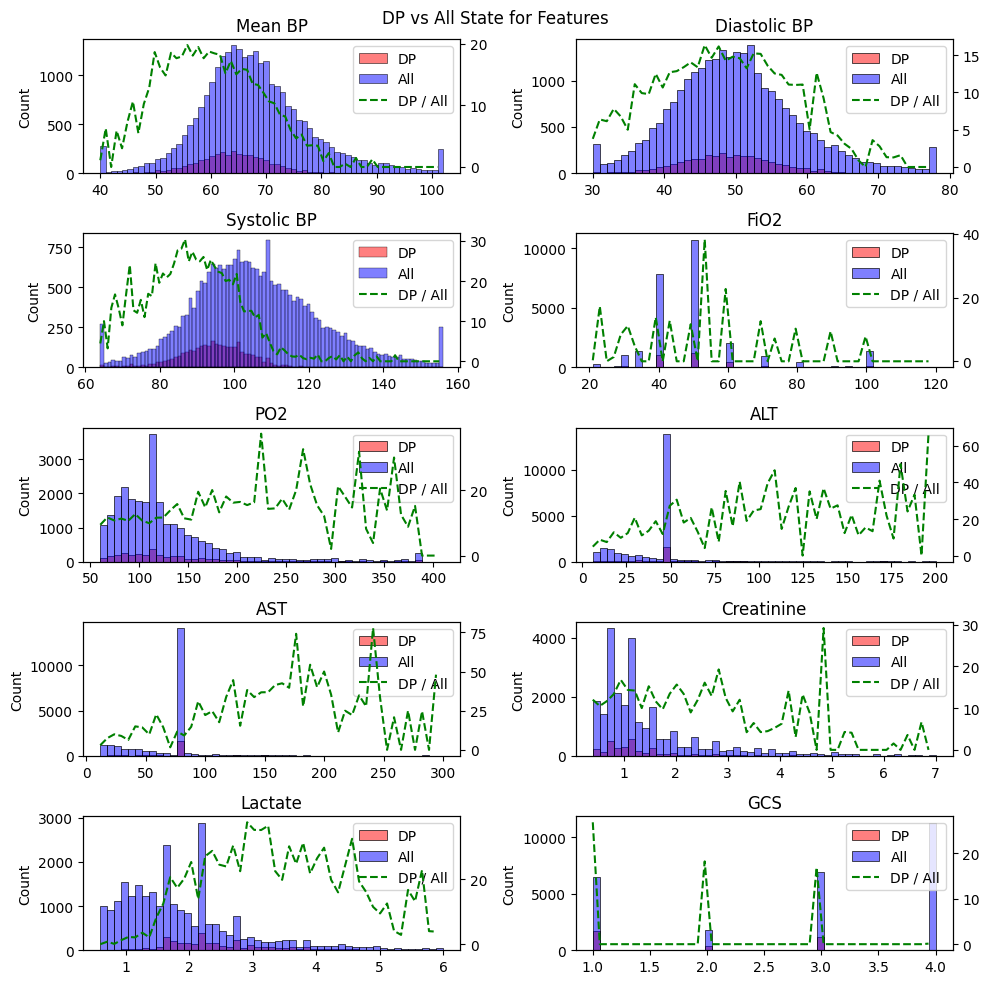

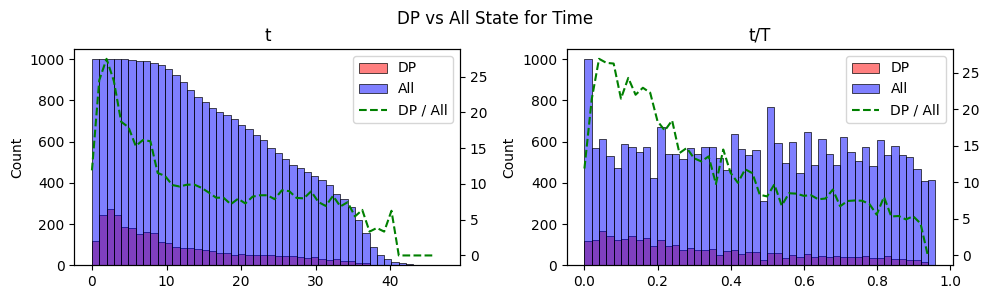

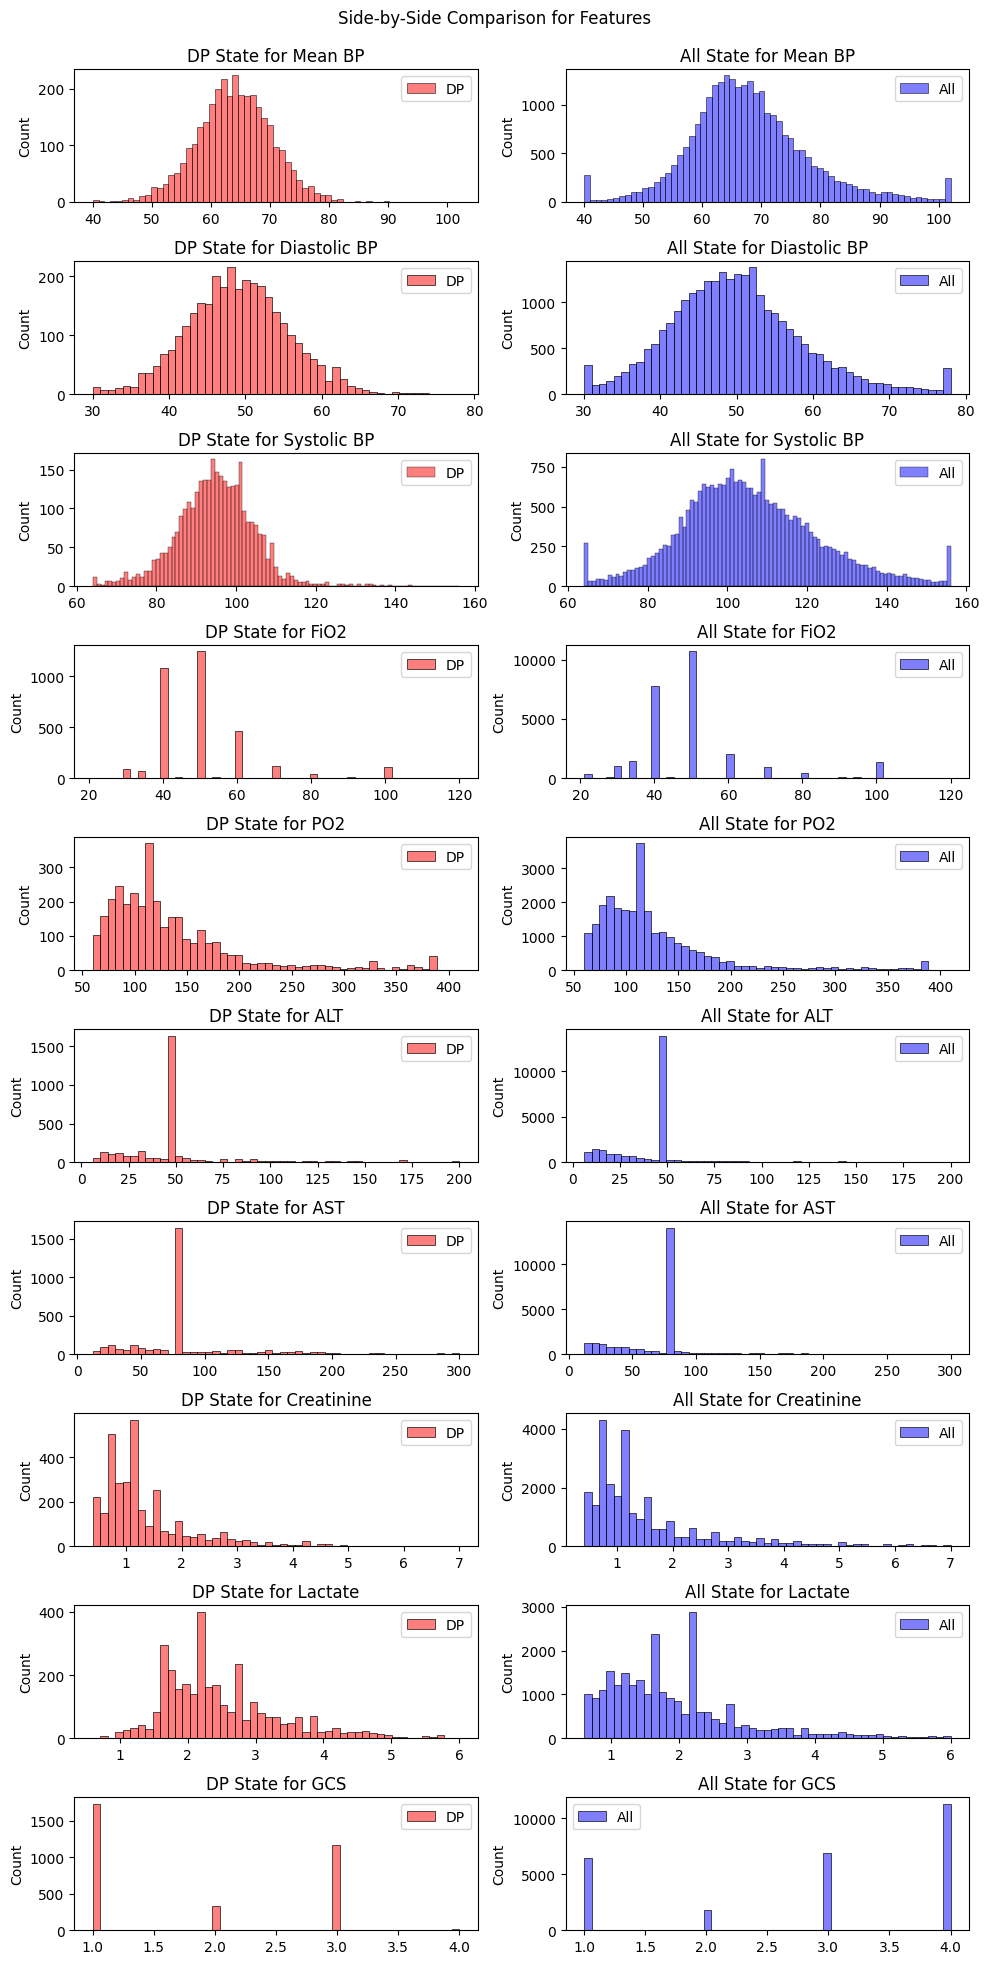

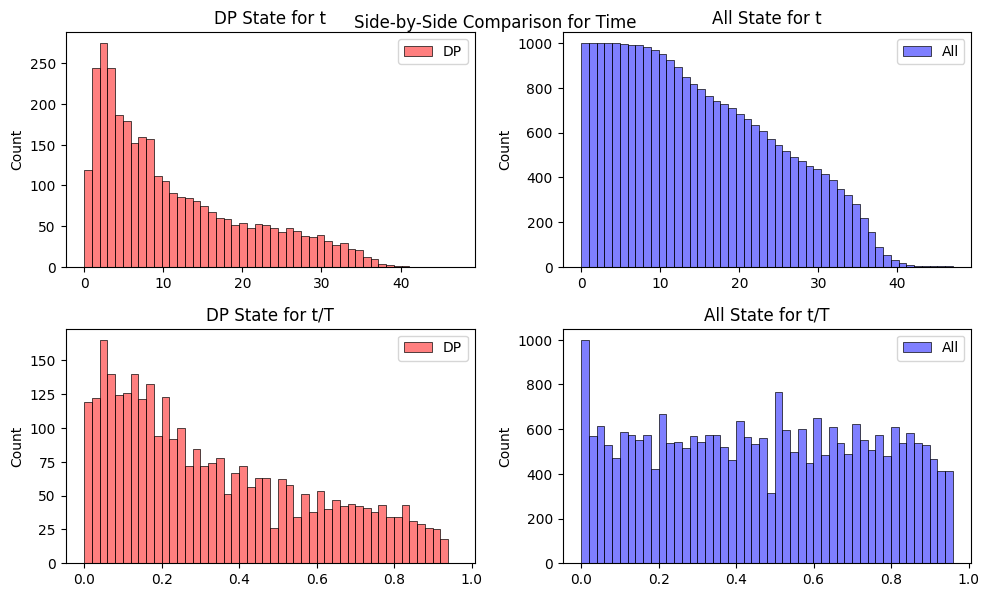

In [99]:
check_dp_state(cluster_idx, n_clusters, S_train_scaled, A_train, R_train, Traj_train, scaler)

# Samples

In [53]:
sas_dp[rar_dp[:, 0] == 5][:, 8]

array([2.2, 2.2, 3.2, 3.2, 2.5, 2.3, 1.3, 2.4, 2. , 2.5, 4.6, 2.7, 1.9,
       2.6, 2.2, 1.8, 1.8, 1.6, 5.7, 2.5, 3. , 3.2, 4.2, 2.5, 2.1, 1.9,
       2.3, 2.2, 5.6, 2.4, 1.9, 1.7, 1.8, 2.8, 1.8, 3.5, 2.2, 3. , 2.2,
       2.1, 2. , 1.8, 2.1, 1.3, 3. , 3. , 5.2, 5.2, 2.6, 1.6, 2.2, 2. ,
       1.8, 2.1, 2.4, 2.6, 2.3, 2.2, 1.3, 1.5, 3. , 2.8, 3.1, 4.6, 4.6,
       2.8, 2. , 1.7, 2. , 2.2, 2.2, 1.7, 4. , 2.5, 2.2, 2.2, 3.3, 3.3,
       1.7, 1.7, 3. , 1.6, 3. , 2.2, 2.2, 2.2, 2.4, 3.4, 3. , 2.2, 2.5,
       2.3, 1.6, 2. , 2.5, 1.8, 4.4, 1.6, 1.3, 1.7, 1.7, 1.7, 3.6, 1.5,
       1.5, 1.7, 2.4, 5. , 2.2, 3.4, 3.2, 1.8, 4. , 2.2, 3. , 2. , 2.9,
       4.2, 4.2, 3.2, 2. , 2.2, 4. , 2.3, 2.8, 2.3, 1.6, 2. , 1. , 6.1,
       2. , 5.7, 3.5, 2.2, 2.2, 2. , 4.6, 3.2, 1.9, 1.5, 1.8, 2.2, 2. ,
       2.2, 1.4, 2.4, 2.2, 2.9, 2.6, 1.8, 3.4, 2.3, 1.6, 2.2, 2.4, 2.5,
       1.7, 1.7, 1.8, 2.1, 2.8, 1.8, 1.8, 1.1, 2.7, 1.2, 4.3, 2.7, 2.1,
       1.8, 1.5, 1.4, 1.7, 1.3, 1.6, 1.5, 2.7, 2.7, 2.7, 3.4, 2.

In [54]:
idx = 7
feat = 0
value = 0

for i in range(1000):
    c_idx = (cluster_idx[Traj_train[i]:Traj_train[i+1]] == idx)
    if (np.sum(c_idx)/np.sum(cluster_idx[Traj_train[i]:Traj_train[i+1]] != n_clusters)) > 0.5:
        if np.sum(S_train[Traj_train[i]:Traj_train[i+1]][c_idx][:, feat] > value) > 0:
            print(i)

4
54
72
99
111
114
126
145
146
159
164
166
167
170
187
191
196
253
269
285
289
293
302
307
318
338
346
354
376
407
414
415
429
438
442
479
492
525
526
549
552
554
562
618
634
652
654
665
670
687
738
749
750
760
761
765
779
801
821
824
828
855
861
884
885
925
934
943
945
950
984


/var/folders/0k/dgv5msk922b5dj2df0q6mhs00000gn/T/ipykernel_75019/1428838012.py:7: RuntimeWarning: invalid value encountered in scalar divide
  if (np.sum(c_idx)/np.sum(cluster_idx[Traj_train[i]:Traj_train[i+1]] != n_clusters)) > 0.5:


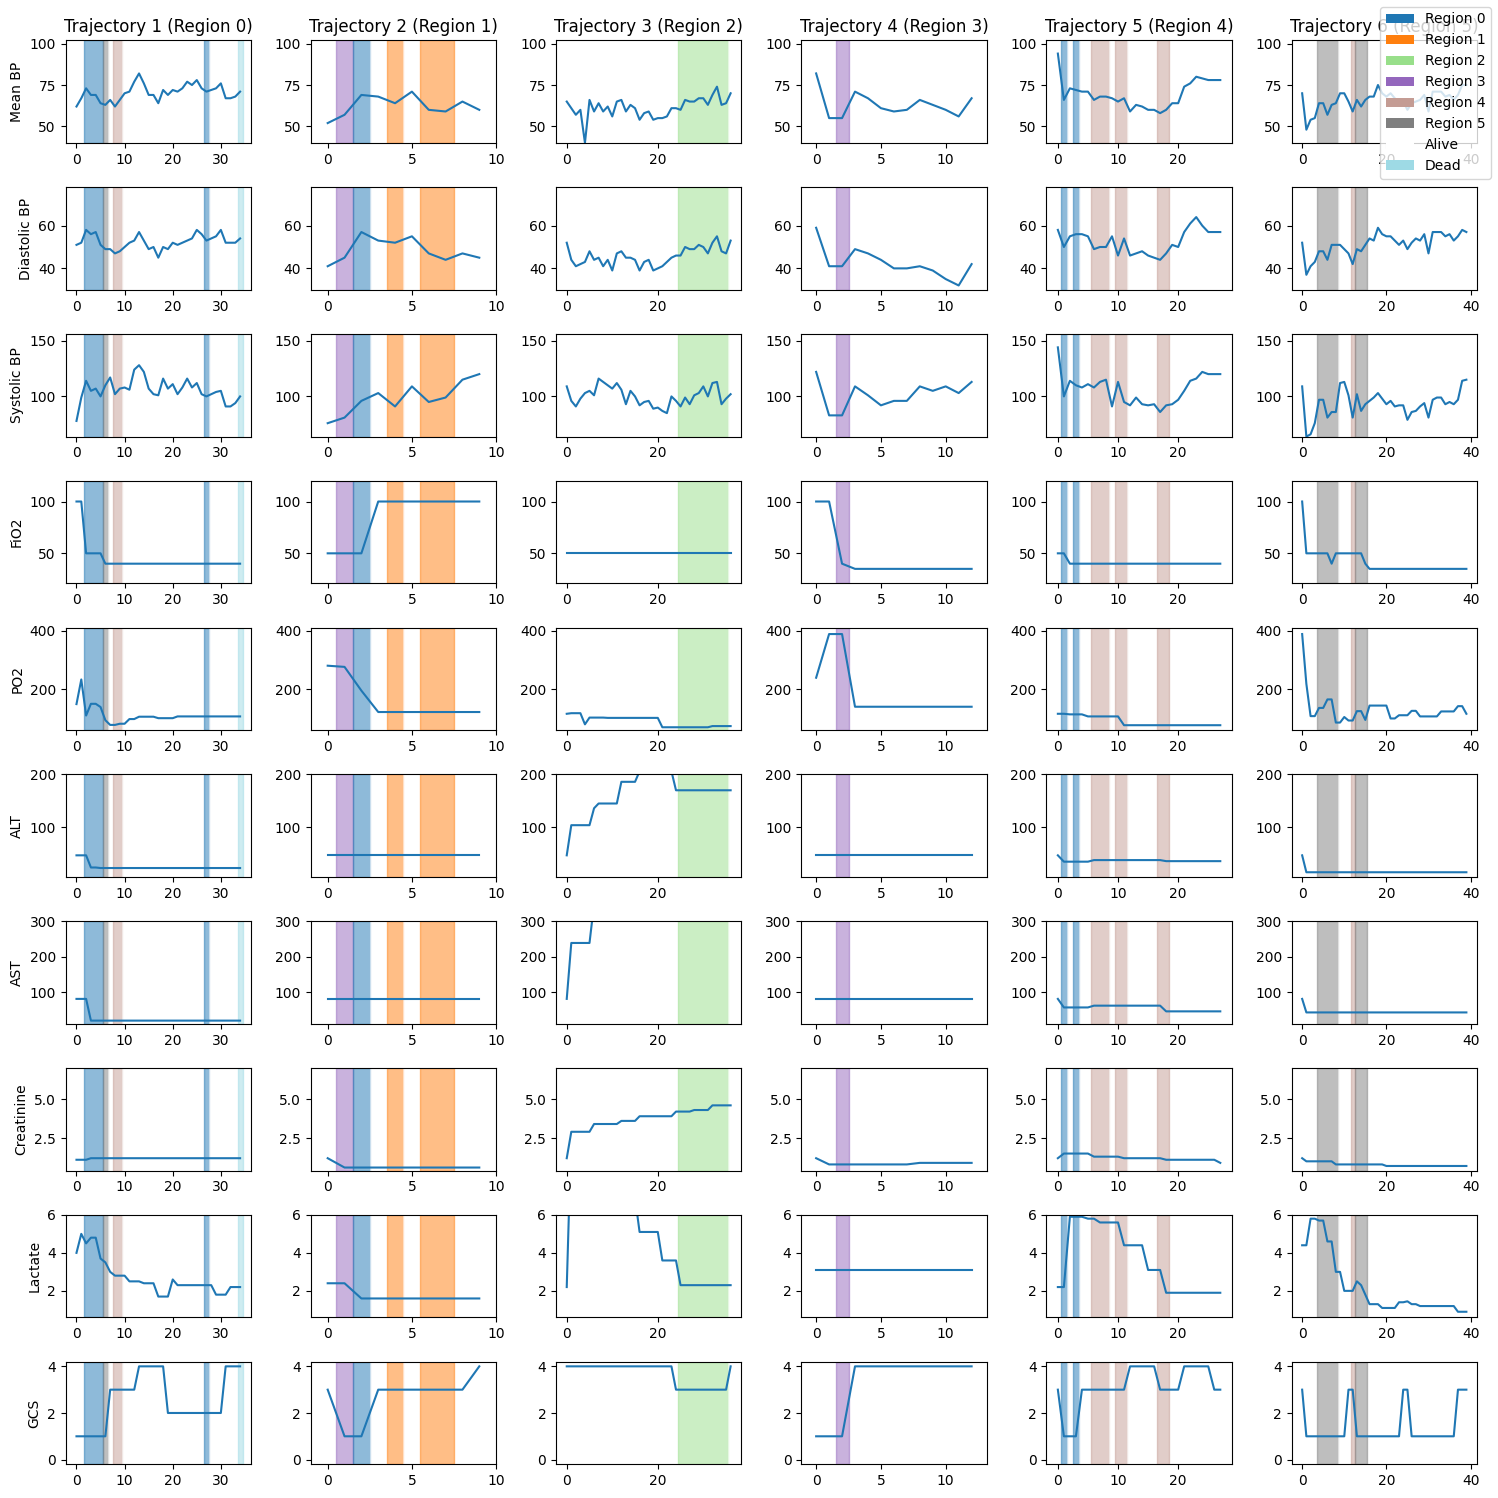

In [109]:
sample_idx = [67, 162, 703, 14, 194, 36]
r_idx = range(n_clusters)

# Define global min and max for each state feature
global_min = np.min(S_train, axis=0)
global_max = np.max(S_train, axis=0)

# Manually set specific limits for certain features
global_max[3] = 120
global_max[4] = 410
global_max[5] = 200
global_max[6] = 300
global_max[7] = 7
global_max[8] = 6
global_min[9] = -0.2
global_max[9] = 4.2

fig, ax = plt.subplots(S_train.shape[1], n_clusters, figsize=(15, 15))

# Generate colors using a colormap, ensuring enough colors for unique regions
unique_regions = np.unique(cluster_idx)
num_regions = len(unique_regions)

# Ensure the color map can accommodate all unique regions
colors = plt.cm.tab20(np.linspace(0, 1, min(num_regions, 20)))

# If there are more regions than colors, extend the color map
if num_regions > len(colors):
    extra_colors = plt.cm.viridis(np.linspace(0, 1, num_regions - len(colors)))
    colors = np.vstack((colors, extra_colors))

# Ensure the last region's color is white
if num_regions > 0:
    colors[-2] = [1, 1, 1, 1]  # RGBA for white with full opacity

for i in range(n_clusters):
    S_Traj = S_train[Traj_train[sample_idx[i]]:Traj_train[sample_idx[i]+1]]
    A_Traj = A_train[Traj_train[sample_idx[i]]:Traj_train[sample_idx[i]+1]]
    DR_Traj = cluster_idx[Traj_train[sample_idx[i]]:Traj_train[sample_idx[i]+1]]

    for j in range(S_train.shape[1]):
        ax[j, i].plot(S_Traj[:, j])

        # Shade regions based on DR_Traj
        start_idx = 0
        current_region = DR_Traj[0]
        for k in range(1, len(S_Traj)):
            if DR_Traj[k] != current_region:
                ax[j, i].axvspan(start_idx-0.5, k-0.5, color=colors[int(current_region)], alpha=0.5)
                start_idx = k
                current_region = DR_Traj[k]
            if k == len(S_Traj) - 1:
                ax[j, i].axvspan(k-0.5, k+0.5, color=colors[int(current_region)], alpha=0.5)

        if j == 0 and i != n_clusters:
            ax[j, i].set_title(f'Trajectory {i+1} (Region {r_idx[i]})')

        if i == 0:
            ax[j, i].set_ylabel(state_name[j])

        ax[j, i].set_ylim(global_min[j], global_max[j])

# Create legend handles with no edges
handles = [Patch.Rectangle((0, 0), 1, 1, color=colors[int(region)], lw=0) for region in unique_regions]
labels = [f'Region {i}' for i in range(n_clusters)] + ['Alive', 'Dead']

# Add legend to the plot
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.savefig('figures/Samples.png', dpi=300)
plt.show()


In [56]:
for idx, i in enumerate(sample_idx):
    c_idx = (cluster_idx[Traj_train[i]:Traj_train[i+1]] == r_idx[idx])

    max_fluid = 0
    max_vaso = 0
    for a in A_train[Traj_train[i]:Traj_train[i+1]][c_idx]:
        fluid = a // 4
        vasopressor = a % 4
        max_fluid = max(max_fluid, fluid)
        max_vaso = max(max_vaso, vasopressor)
    max_action = max_fluid * 4 + max_vaso

    print(max_action)
    print(action_names[max_action])

15
High Fluid, High Vaso
4
Low Fluid, No Vaso
14
High Fluid, Mid Vaso
2
No Fluid, Mid Vaso
14
High Fluid, Mid Vaso
15
High Fluid, High Vaso


In [57]:
for i in r_idx:
    print(policy_learned[i].argmax())
    print(action_names[policy_learned[i].argmax()])

7
Low Fluid, High Vaso
12
High Fluid, No Vaso
3
No Fluid, High Vaso
4
Low Fluid, No Vaso
4
Low Fluid, No Vaso
9
Mid Fluid, Low Vaso


In [58]:
print("(0)")
print("Clinician Prescribed:\tHigh\tFluid,\tHigh\tVaso")
print("Recommended Action:\tLow\tFluid,\tHigh\tVaso")
print("(1)")
print("Clinician Prescribed:\tLow\tFluid,\tNo\tVaso")
print("Recommended Action:\tHigh\tFluid,\tNo\tVaso")
print("(2)")
print("Clinician Prescribed:\tHigh\tFluid,\tMid\tVaso")
print("Recommended Action:\tNo\tFluid,\tHigh\tVaso")
print("(3)")
print("Clinician Prescribed:\tNo\tFluid,\tMid\tVaso")
print("Recommend Action:\tLow\tFluid,\tNo\tVaso")
print("(4)")
print("Clinician Prescribed:\tHigh\tFluid,\tMid\tVaso")
print("Recommend Action:\tLow\tFluid,\tNo\tVaso")
print("(5)")
print("Clinician Prescribed:\tHigh\tFluid,\tHigh\tVaso")
print("Recommend Action:\tMid\tFluid,\tLow\tVaso")

(0)
Clinician Prescribed:	High	Fluid,	High	Vaso
Recommended Action:	Low	Fluid,	High	Vaso
(1)
Clinician Prescribed:	Low	Fluid,	No	Vaso
Recommended Action:	High	Fluid,	No	Vaso
(2)
Clinician Prescribed:	High	Fluid,	Mid	Vaso
Recommended Action:	No	Fluid,	High	Vaso
(3)
Clinician Prescribed:	No	Fluid,	Mid	Vaso
Recommend Action:	Low	Fluid,	No	Vaso
(4)
Clinician Prescribed:	High	Fluid,	Mid	Vaso
Recommend Action:	Low	Fluid,	No	Vaso
(5)
Clinician Prescribed:	High	Fluid,	High	Vaso
Recommend Action:	Mid	Fluid,	Low	Vaso


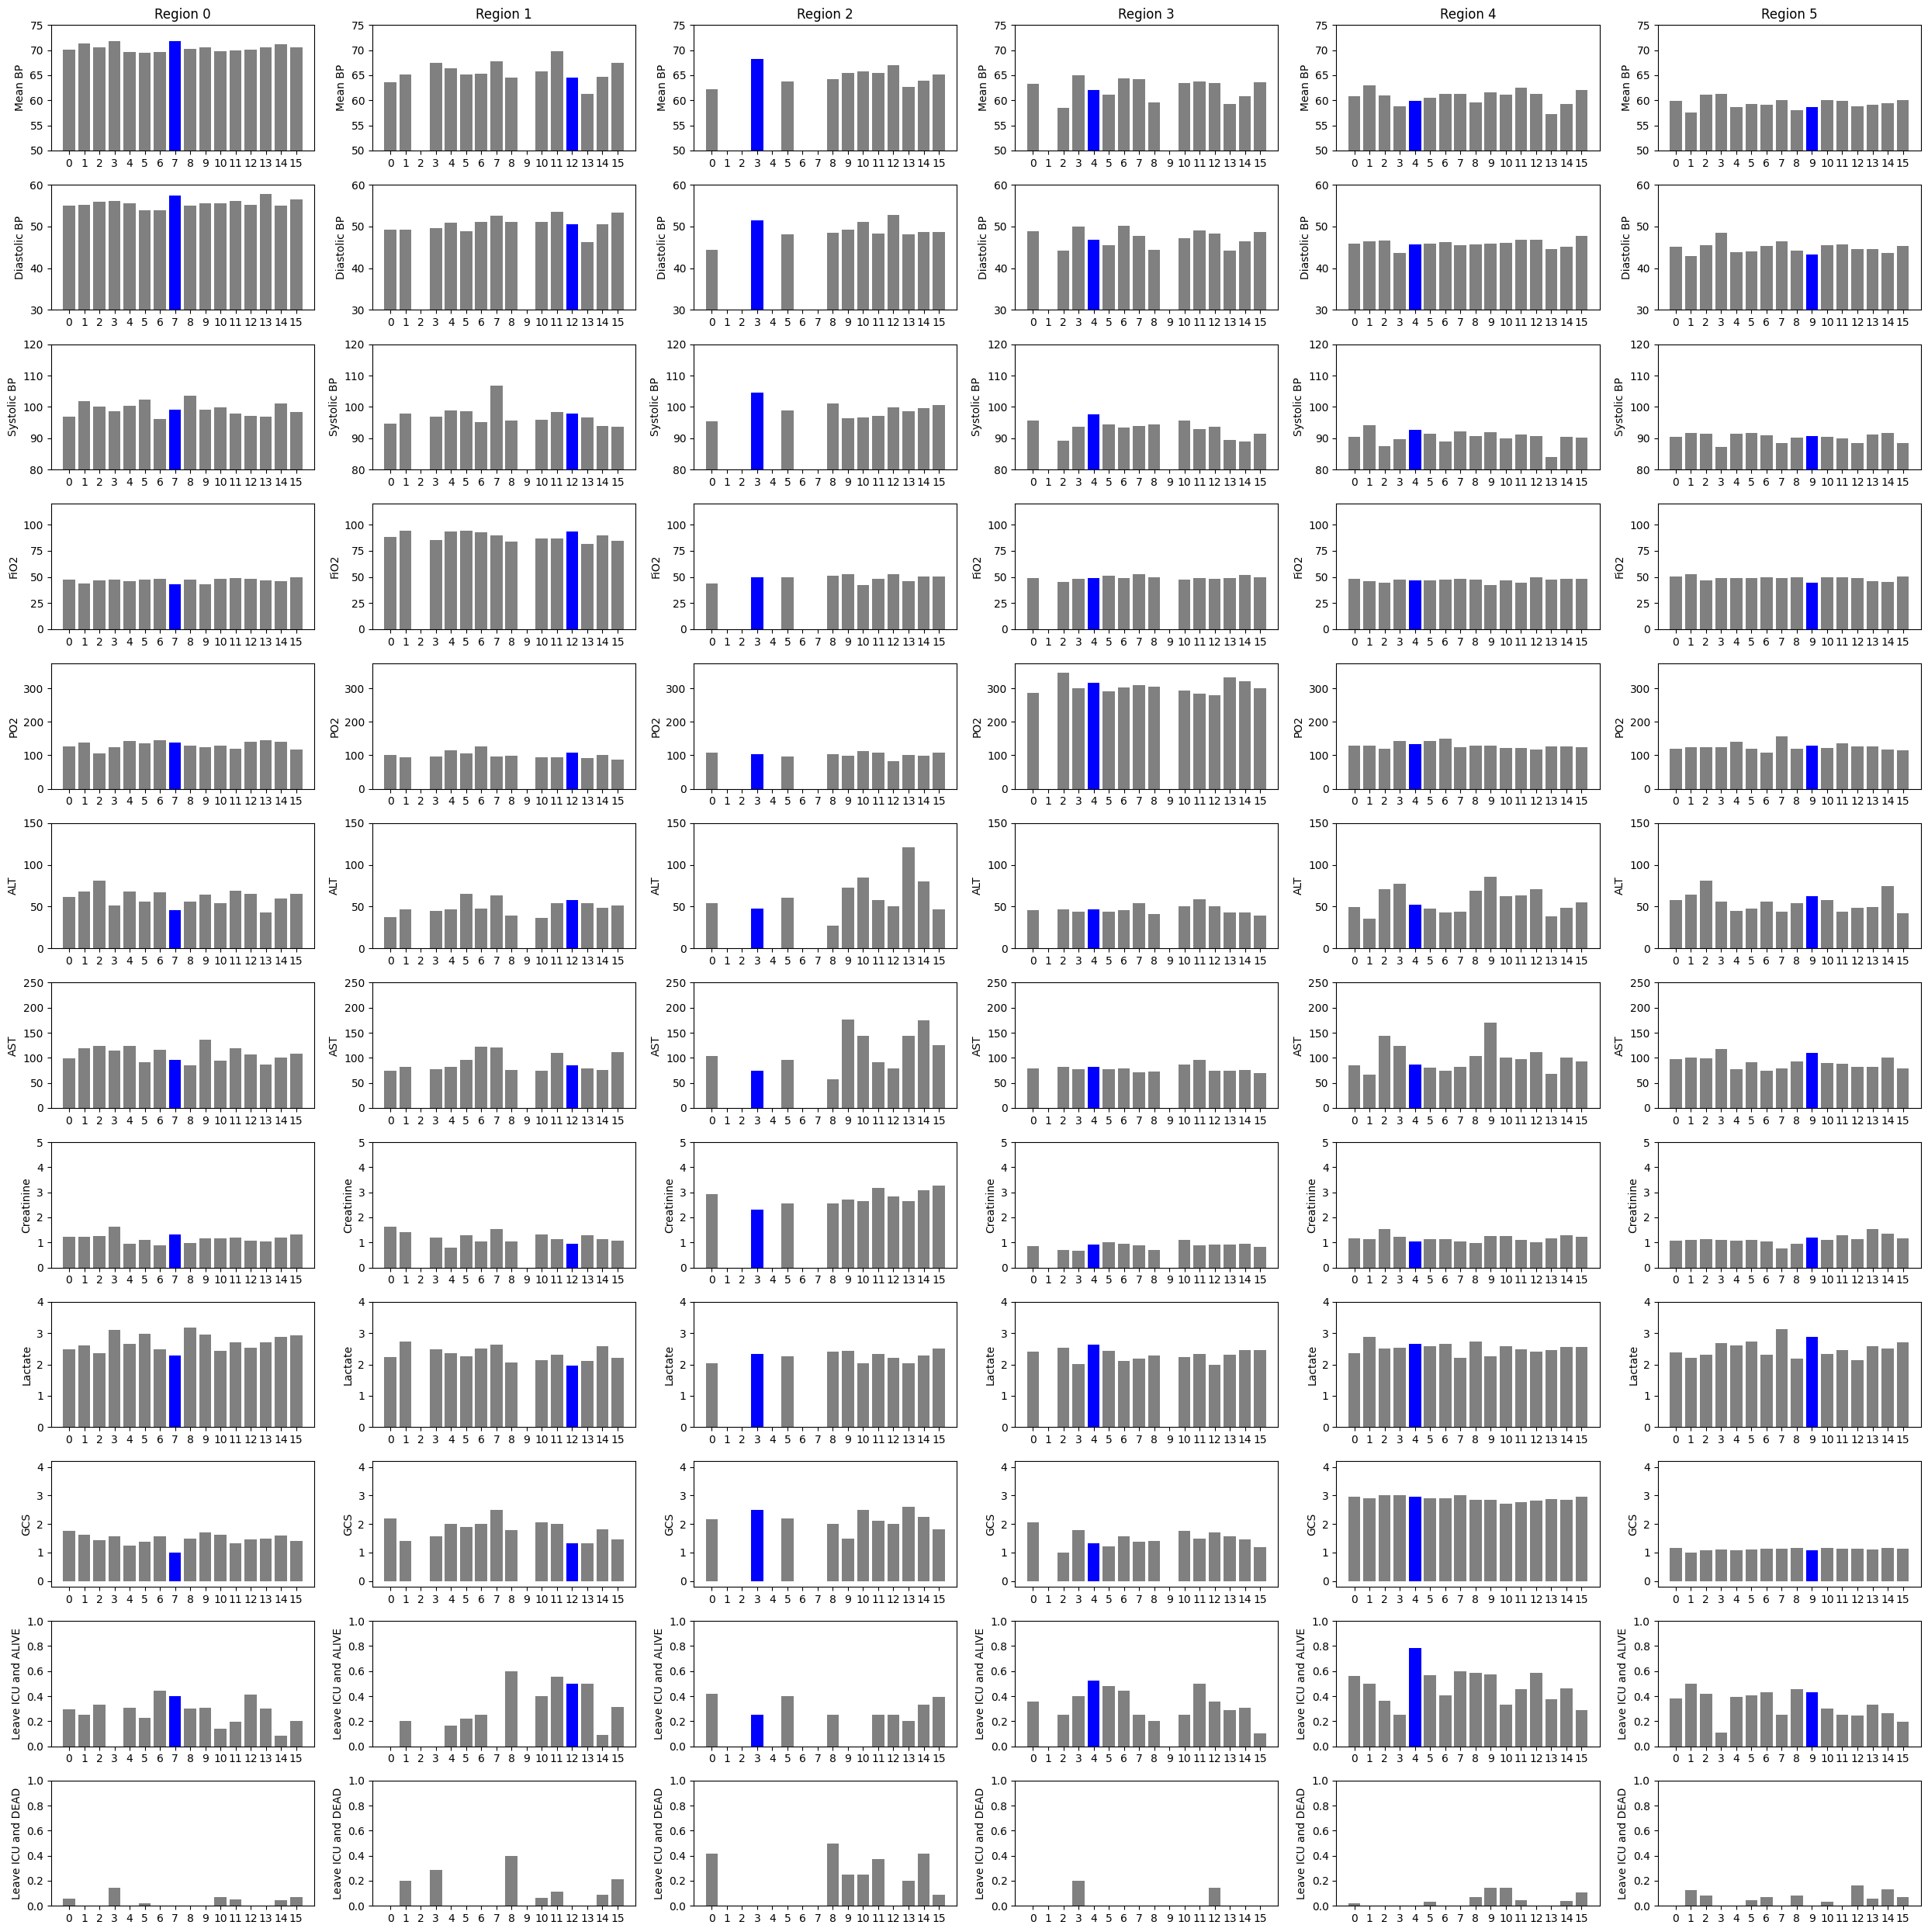

In [59]:
colors = [['grey' for _ in range(16)] for _ in range(n_clusters)]
colors[0][7] = 'blue'
colors[1][12] = 'blue'
colors[2][3] = 'blue'
colors[3][4] = 'blue'
colors[4][4] = 'blue'
colors[5][9] = 'blue'
for i in range(n_clusters):
    for j in range(16):
        if count[i, j] < SA_min:
            colors[i][j] = 'white'

limits = np.zeros((10, 2))
limits[0, :] = [50, 75]
limits[1, :] = [30, 60]
limits[2, :] = [80, 120]
limits[3, :] = [0, 120]
limits[4, :] = [0, 375]
limits[5, :] = [0, 150]
limits[6, :] = [0, 250]
limits[7, :] = [0, 5]
limits[8, :] = [0, 4]
limits[9, :] = [-0.2, 4.2]

fig, ax = plt.subplots(12, n_clusters, figsize=(25, 25))

# bar plot for each state feature, and each region, showing the mean value of that feature in that region after taking one of the 16 actions
for i in range(10):
    for j in range(n_clusters):
        for k in range(16):
            ax[i, j].bar(k, np.mean(sas_dp[(rar_dp[:, 0] == j) & (rar_dp[:, 1] == k)][:, i]), color=colors[j][k])
        if i == 0:
            ax[i, j].set_title(f'Region {j}')
        ax[i, j].set_ylabel(state_name[i])
        ax[i, j].set_xticks(range(16))
        ax[i, j].set_ylim(limits[i, :])

for i in range(2):
    for j in range(n_clusters):
        for k in range(16):
            ax[10+i, j].bar(k, T_mat[j, k, n_clusters+i], color=colors[j][k])
        ax[10+i, j].set_ylabel(['Leave ICU and ALIVE', 'Leave ICU and DEAD'][i])
        ax[10+i, j].set_xticks(range(16))
        ax[10+i, j].set_ylim([0, 1])

plt.tight_layout()
plt.show()

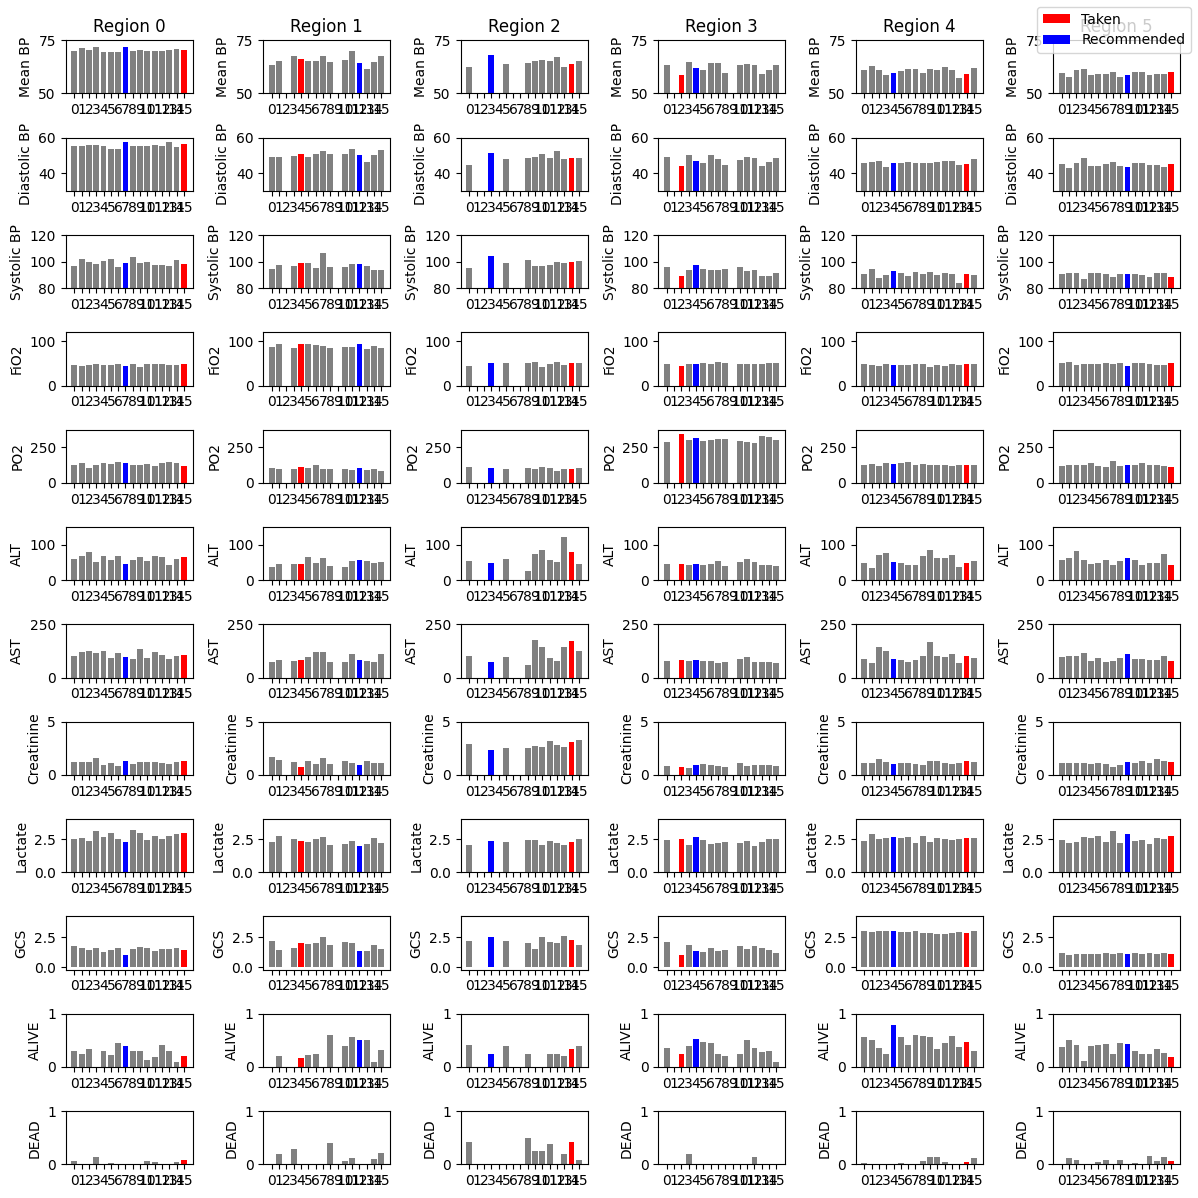

In [168]:
colors = [['grey' for _ in range(16)] for _ in range(n_clusters)]
colors[0][15] = 'red'
colors[1][4] = 'red'
colors[2][14] = 'red'
colors[3][2] = 'red'
colors[4][14] = 'red'
colors[5][15] = 'red'
colors[0][7] = 'blue'
colors[1][12] = 'blue'
colors[2][3] = 'blue'
colors[3][4] = 'blue'
colors[4][4] = 'blue'
colors[5][9] = 'blue'
for i in range(n_clusters):
    for j in range(16):
        if count[i, j] < SA_min:
            colors[i][j] = 'white'

limits = np.zeros((10, 2))
limits[0, :] = [50, 75]
limits[1, :] = [30, 60]
limits[2, :] = [80, 120]
limits[3, :] = [0, 120]
limits[4, :] = [0, 375]
limits[5, :] = [0, 150]
limits[6, :] = [0, 250]
limits[7, :] = [0, 5]
limits[8, :] = [0, 4]
limits[9, :] = [-0.2, 4.2]

fig, ax = plt.subplots(12, n_clusters, figsize=(12, 12))

# bar plot for each state feature, and each region, showing the mean value of that feature in that region after taking one of the 16 actions
for i in range(10):
    for j in range(n_clusters):
        for k in range(16):
            ax[i, j].bar(k, np.mean(sas_dp[(rar_dp[:, 0] == j) & (rar_dp[:, 1] == k)][:, i]), color=colors[j][k])
        if i == 0:
            ax[i, j].set_title(f'Region {j}')
        ax[i, j].set_ylabel(state_name[i])
        ax[i, j].set_xticks(range(16))
        ax[i, j].set_ylim(limits[i, :])

for i in range(2):
    for j in range(n_clusters):
        for k in range(16):
            ax[10+i, j].bar(k, T_mat[j, k, n_clusters+i], color=colors[j][k])
        ax[10+i, j].set_ylabel(['ALIVE', 'DEAD'][i])
        ax[10+i, j].set_xticks(range(16))
        ax[10+i, j].set_ylim([0, 1])

# Create legend handles with no edges
handles = [Patch.Rectangle((0, 0), 1, 1, color='red', lw=0), Patch.Rectangle((0, 0), 1, 1, color='blue', lw=0)]
labels = ['Taken', 'Recommended']

# Add legend to the plot
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.savefig('figures/Samples_Policy.png', dpi=300)
plt.show()

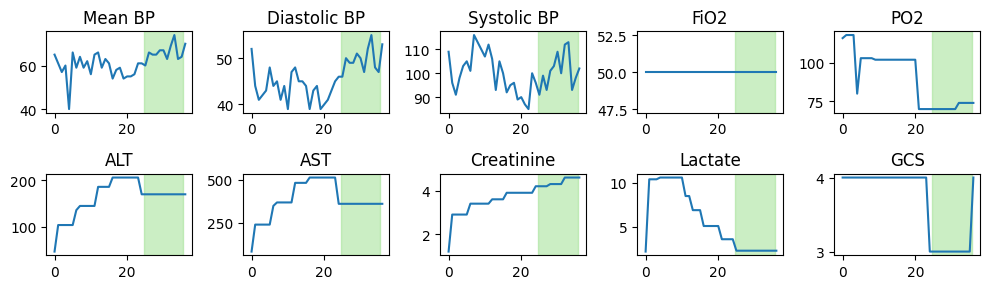

In [156]:
# Region 2
S_sample = S_train[Traj_train[703]:Traj_train[703+1]]
A_sample = A_train[Traj_train[703]:Traj_train[703+1]]
R_sample = R_train[Traj_train[703]:Traj_train[703+1]]
DR_sample = cluster_idx[Traj_train[703]:Traj_train[703+1]]

max_fluid = 0
max_vaso = 0
for a in A_sample[DR_sample == 2]:
    fluid = a // 4
    vasopressor = a % 4
    max_fluid = max(max_fluid, fluid)
    max_vaso = max(max_vaso, vasopressor)
max_action = max_fluid * 4 + max_vaso

unique_regions = np.unique(cluster_idx)
num_regions = len(unique_regions)
colors = plt.cm.tab20(np.linspace(0, 1, min(num_regions, 20)))
colors[-2] = [1, 1, 1, 1]

# Plot the states
fig, ax = plt.subplots(2, 5, figsize=(10, 3))
for i in range(10):
    ax[i//5, i%5].plot(S_sample[:, i])
    ax[i//5, i%5].set_title(state_name[i])

    start_idx = 0
    current_region = DR_sample[0]
    for j in range(1, len(DR_sample)):
        if DR_sample[j] != current_region:
            ax[i//5, i%5].axvspan(start_idx-0.5, j-0.5, color=colors[int(current_region)], alpha=0.5)
            start_idx = j
            current_region = DR_sample[j]
plt.tight_layout()
plt.savefig('figures/Sample.png', dpi=300)
plt.show()

In [62]:
state_name = ['MBP', 'DBP', 'SBP', 'FiO2', 'PO2', 'ALT', 'AST', 'Creat', 'Lact', 'GCS']

region_2_df = pd.DataFrame(S_sample[DR_sample == 2], columns=state_name)

print("Patient's State Features in Decision Region 2\n")
print(region_2_df)
print("\nAction taken:", action_names[max_action])

Patient's State Features in Decision Region 2

     MBP   DBP    SBP  FiO2   PO2    ALT    AST  Creat  Lact  GCS
0   60.0  46.0   91.0  50.0  70.0  170.0  360.0    4.2   2.3  3.0
1   66.0  50.0   99.0  50.0  70.0  170.0  360.0    4.2   2.3  3.0
2   65.0  49.0   93.0  50.0  70.0  170.0  360.0    4.2   2.3  3.0
3   65.0  49.0  101.0  50.0  70.0  170.0  360.0    4.3   2.3  3.0
4   67.0  51.0  103.0  50.0  70.0  170.0  360.0    4.3   2.3  3.0
5   67.0  50.0  109.0  50.0  70.0  170.0  360.0    4.3   2.3  3.0
6   63.0  47.0  100.0  50.0  70.0  170.0  360.0    4.3   2.3  3.0
7   69.0  52.0  112.0  50.0  74.0  170.0  360.0    4.6   2.3  3.0
8   74.0  55.0  113.0  50.0  74.0  170.0  360.0    4.6   2.3  3.0
9   63.0  48.0   93.0  50.0  74.0  170.0  360.0    4.6   2.3  3.0
10  64.0  47.0   98.0  50.0  74.0  170.0  360.0    4.6   2.3  3.0

Action taken: High Fluid, Mid Vaso


In [63]:
# Similar patient same action
S_same = sas_dp[(rar_dp[:, 0] == 2) & (rar_dp[:, 1] == max_action)][:, :10]
R_same = np.array(rar_dp[(rar_dp[:, 0] == 2) & (rar_dp[:, 1] == max_action)][:, 2]).astype(object)
R_same[R_same == n_clusters] = "ALIVE"
R_same[R_same == n_clusters+1] = "DEAD"
same_df = pd.concat([pd.DataFrame(S_same, columns=state_name), pd.DataFrame(R_same, columns=['NextRegion'])], axis=1)

print("Similar Patients' State Features and Next Region with SAME action (", action_names[max_action], ")\n")
print(same_df)
print("\nSurvival rate:\t", np.mean(R_same == "ALIVE"))
print("Mortality rate:\t", np.mean(R_same == "DEAD"))

Similar Patients' State Features and Next Region with SAME action ( High Fluid, Mid Vaso )

     MBP   DBP    SBP  FiO2    PO2    ALT    AST  Creat  Lact  GCS NextRegion
0   63.0  48.0   97.0  50.0  116.0   23.0   47.0    6.8   3.2  3.0      ALIVE
1   68.0  53.0  107.0  60.0   99.0   47.0   82.0    3.2   3.2  1.0      ALIVE
2   67.0  52.0   99.0  40.0   95.0   39.0  175.0    2.2   1.8  3.0          4
3   64.0  50.0   96.0  40.0   95.0   42.0  165.0    2.7   1.8  3.0       DEAD
4   60.0  44.0  113.0  60.0   93.0  121.0  182.0    2.2   2.0  1.0       DEAD
5   57.0  42.0  100.0  50.0  102.0   47.0   82.0    3.0   4.3  1.0       DEAD
6   60.0  46.0   91.0  50.0   70.0  170.0  360.0    4.2   2.3  3.0      ALIVE
7   65.0  50.0   97.0  40.0  122.0   47.0   82.0    2.6   1.8  3.0       DEAD
8   67.0  48.0  101.0  40.0   82.0   99.0  327.0    2.1   2.2  3.0      ALIVE
9   67.0  55.0   90.0  45.0  127.0  223.0  223.0    2.7   1.8  3.0          0
10  59.0  46.0   91.0  60.0   73.0   47.0   82.0  

In [64]:
# Similar patient with recommended action
S_recommended = sas_dp[(rar_dp[:, 0] == 2) & (rar_dp[:, 1] == policy_learned[2].argmax())][:, :10]
R_recommended = np.array(rar_dp[(rar_dp[:, 0] == 2) & (rar_dp[:, 1] == policy_learned[2].argmax())][:, 2]).astype(object)
R_recommended[R_recommended == n_clusters] = "ALIVE"
R_recommended[R_recommended == n_clusters+1] = "DEAD"
recommended_df = pd.concat([pd.DataFrame(S_recommended, columns=state_name), pd.DataFrame(R_recommended, columns=['NextRegion'])], axis=1)

print("Similar Patients' State Features and Next Region with RECOMMENDED action (", action_names[policy_learned[2].argmax()], ")\n")
print(recommended_df)
print("\nSurvival rate:\t", np.mean(R_recommended == "ALIVE"))
print("Mortality rate:\t", np.mean(R_recommended == "DEAD"))

Similar Patients' State Features and Next Region with RECOMMENDED action ( No Fluid, High Vaso )

    MBP   DBP    SBP  FiO2    PO2    ALT    AST  Creat  Lact  GCS NextRegion
0  72.0  54.0  108.0  50.0  125.0   19.0   51.0    2.3   2.8  3.0          4
1  67.0  47.0  113.0  40.0  131.0  110.0  146.0    2.4   2.1  3.0      ALIVE
2  67.0  56.0   95.0  60.0   88.0   14.0   18.0    2.0   2.5  3.0          0
3  67.0  49.0  102.0  50.0   67.0   47.0   82.0    2.5   1.9  1.0          1

Survival rate:	 0.25
Mortality rate:	 0.0


# Test

In [65]:
state_name = ['Mean BP', 'Diastolic BP', 'Systolic BP', 'FiO2', 'PO2', 'ALT', 'AST', 'Creatinine', 'Lactate', 'GCS']

In [166]:
seed = 42
set_seed(seed)

In [167]:
test_learned(knn, n_clusters, clf, policy_learned, S_test_scaled, A_test, R_test, Traj_test, gamma=gamma)

100%|██████████| 100/100 [2:48:32<00:00, 101.13s/it] 


Behaviour Policy:

V_pi_b: -1.077766703947766 +/- 0.03583841520640166
[-1.17122084 -1.10417648 -1.07575652 -1.05193272 -0.97045833]

Proposed Policy:

V_IS: -1.0349331787973013 +/- 0.361108739482521
[-2.08566715 -1.24637794 -0.95570078 -0.76625544 -0.48111518]

V_PDIS: -1.7600425995437763 +/- 0.5823454608994446
[-3.12836238 -2.09517455 -1.71147359 -1.31703151 -0.73564115]

V_WIS: -0.6352341895373441 +/- 0.22430095616078874
[-1.25535988 -0.72275169 -0.57397402 -0.46583222 -0.34219769]

V_PDWIS: -0.010781318941133069 +/- 0.015930007398195792
[-6.64101324e-02 -1.92204176e-02 -8.83457112e-05 -4.26950500e-05
 -1.26707224e-05]

Percentage of Decision Points: 0.10593992457729282 ( 274181 / 2588080 )

Miss: 0


(2756, 12) (25885, 12)
Percentage of Decision Points: 0.1064709291095229 ( 2756 / 25885 )


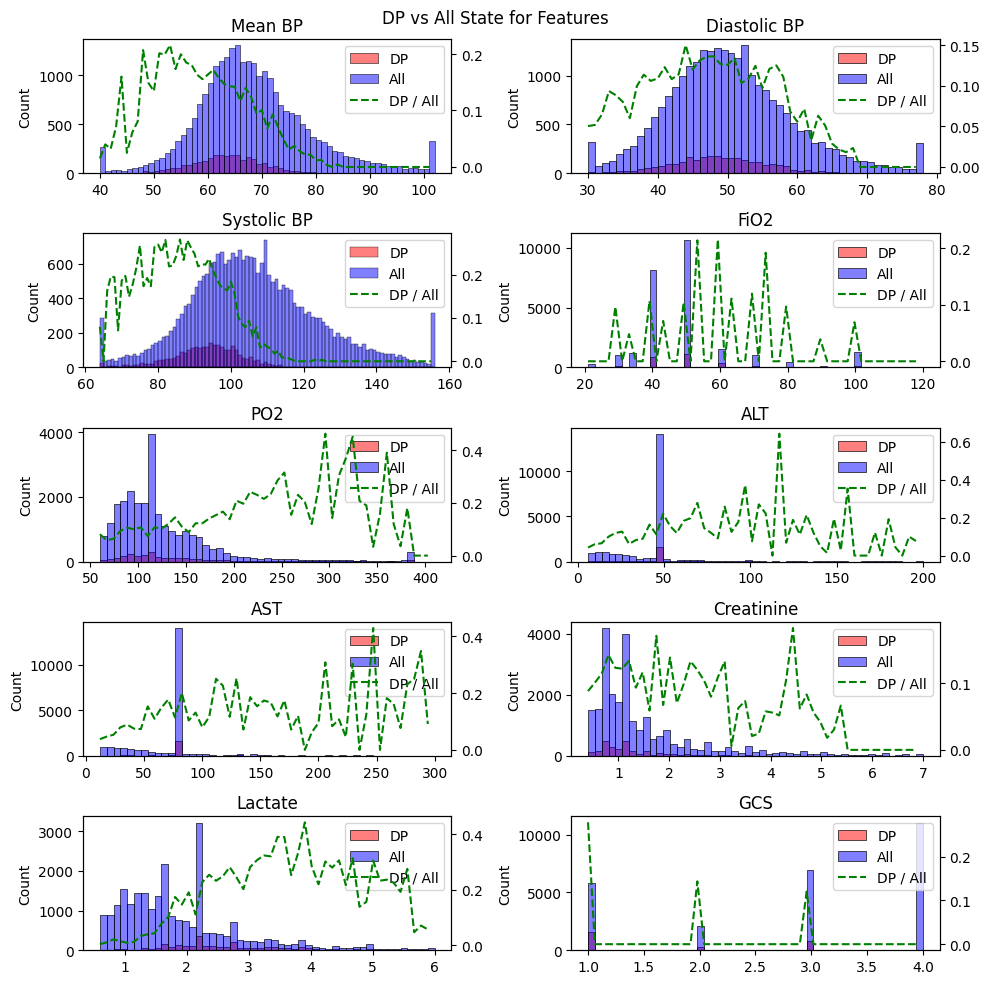

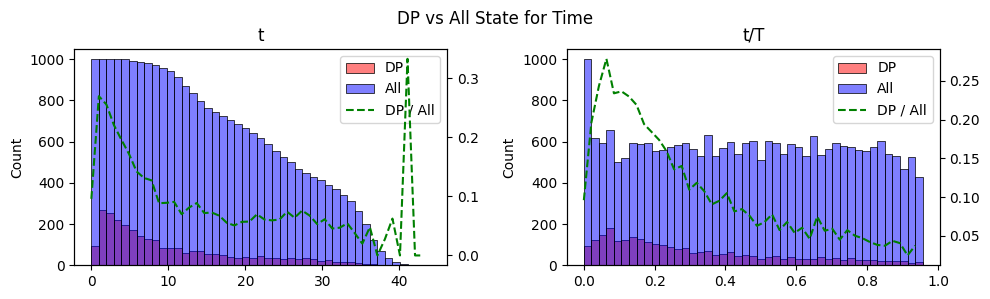

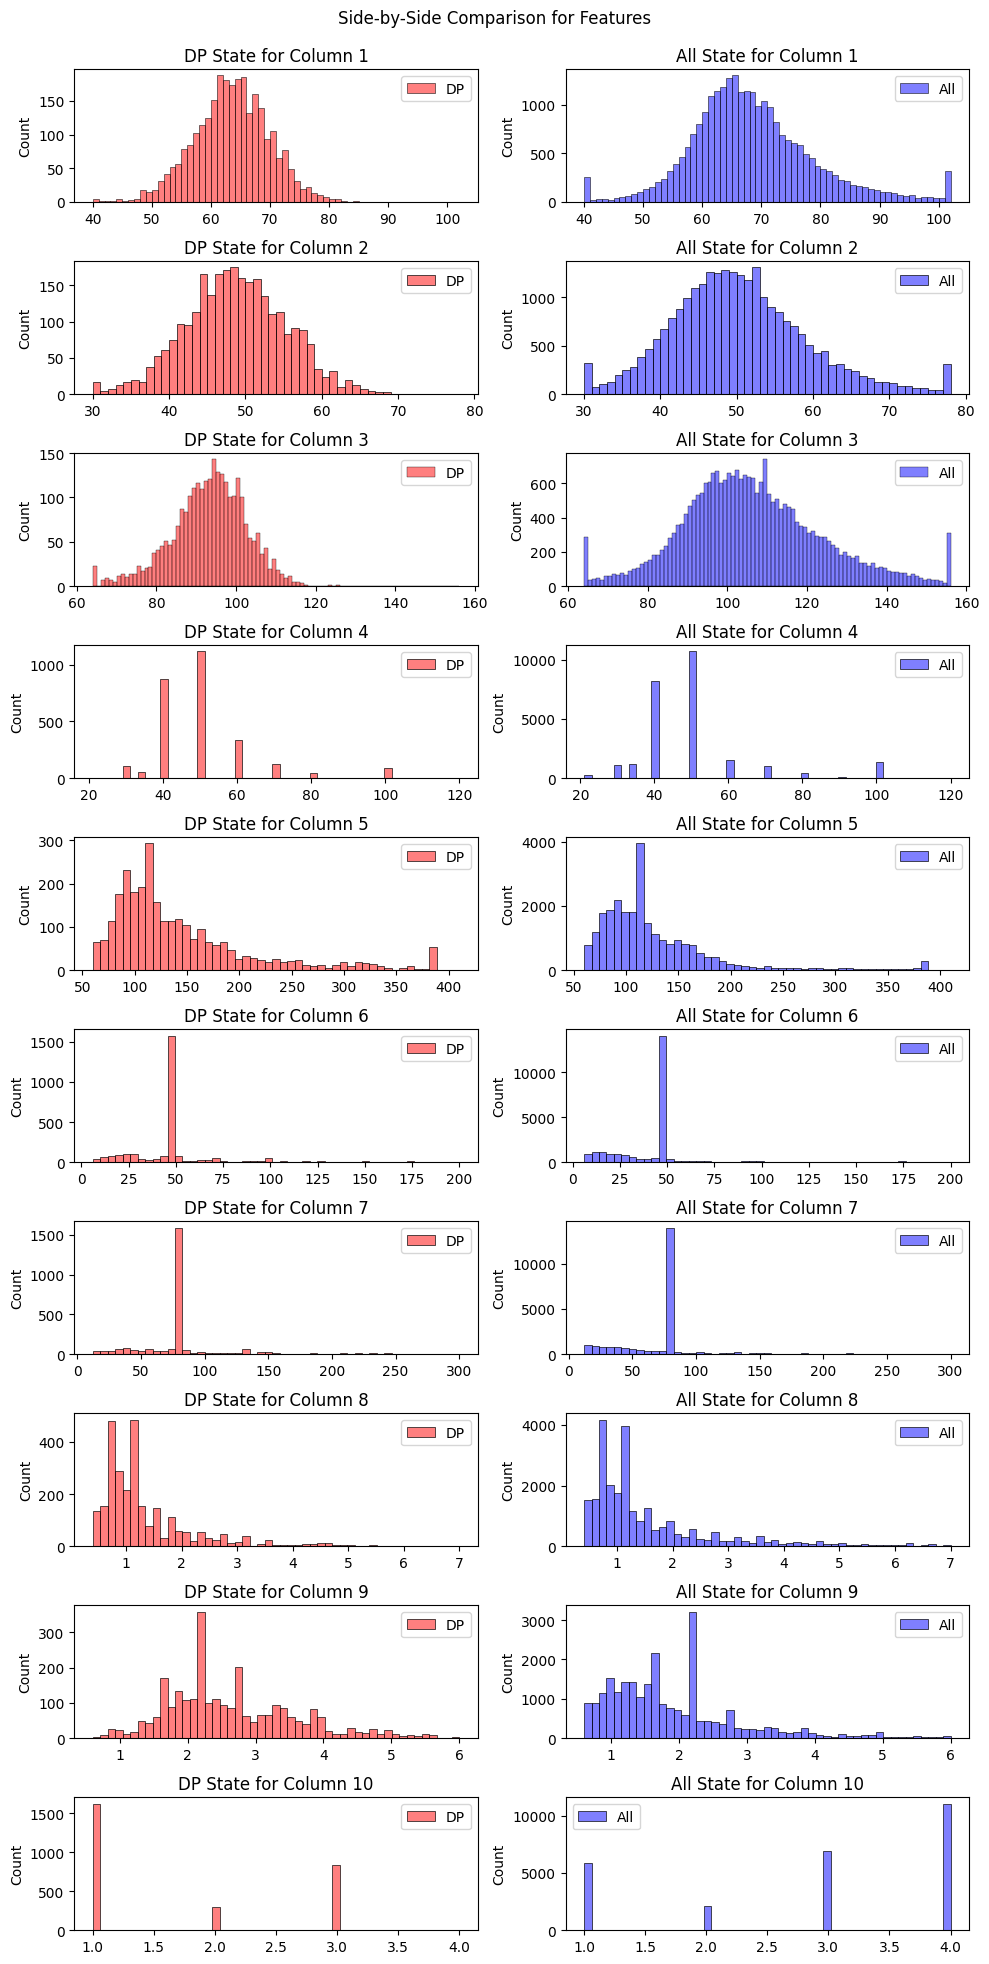

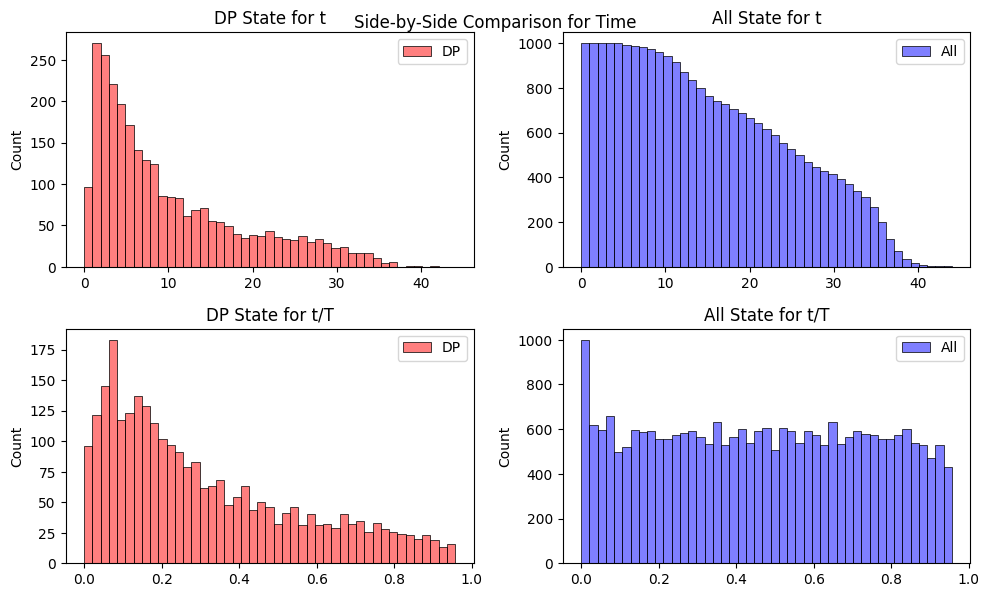

In [106]:
check_test_state(knn, n_clusters, S_test_scaled, A_test, R_test, Traj_test, scaler)